In [37]:
import tensorflow as tf
import numpy as np
import os
import random

import itertools

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
def dense_to_one_hot(labels_dense, num_classes=10):
    """ Convert class labels from scalars to one-hot vectors. """
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def get_xy(start, end, n_frame, vid, labels, feat):
    inp, output = [], []
    for i in range(start,end+1):
        tmp = []
        # check if number of frame in the current video are greater than n_frame
        if len(feat[vid[i]]) > n_frame:
            current_frame = random.randrange(0,len(feat[vid[i]])-n_frame)
            c_start = 0
            c_end = current_frame+n_frame
            
            for frame in sorted(feat[vid[i]]):
                if (c_start > current_frame) and (c_end > current_frame):
                    current_frame += 1
                    tmp.append(feat[vid[i]][frame].flatten())
                c_start += 1
        else:
            for frame in sorted(feat[vid[i]]):
                tmp.append(feat[vid[i]][frame].flatten())
            last_frame_id = sorted(feat[vid[i]])[-1]
            while len(tmp) <= 15:
                tmp.append(feat[vid[i]][last_frame_id].flatten())
        
        inp.append(tmp)
        output.append(labels[vid[i]])
    output = dense_to_one_hot(np.array(output), n_classes)

    return inp, output

In [84]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    classes = ['Ang', 'Dis', 'Fea', 'Hap', 'Neu', 'Sad', 'Sur']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    np.set_printoptions(precision=2)
    
    if normalize:
        cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]
        cm *= 100
        for i in range(0,7):
            for j in range(0,7):
                cm[i][j] = '%.02f' % cm[i][j]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
#     print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
n_epoch = 100
batch_size = 128
display_step = 10

n_input = 4096
# n_steps = 16
n_hidden = 128
n_classes = 7

logs_path = '/output/logs/'
root = '/input/'

In [4]:
feat_train = np.load(root+'feat_train.npy', encoding='latin1').item(0)
feat_val = np.load(root+'feat_val.npy', encoding='latin1').item(0)

vid_train = np.load(root+'vid_train.npy')
vid_val = np.load(root+'vid_val.npy')

labels_train = np.load(root+'labels_train.npy').item(0)
labels_val = np.load(root+'labels_val.npy').item(0)

In [91]:
def lstm_model(n_epoch, batch_size, n_hidden, n_frame, learning_rate, opt_type, init_type, dropout):
    
    tf.reset_default_graph()
    
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, n_frame, n_input])
        y = tf.placeholder(tf.float32, [None, n_classes])
        keep_prob = tf.placeholder(tf.float32)

    with tf.name_scope('lstm_cell'):
#         cell = tf.contrib.rnn.NASCell(n_hidden)
        cell = tf.contrib.rnn.LSTMCell(n_hidden)
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
        val, _ = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
        val_ = tf.transpose(val, [1, 0, 2])
        last = tf.gather(val_, int(val_.get_shape()[0]) - 1)
        if init_type == 'normal':
            initial_W = tf.truncated_normal([n_hidden, int(y.get_shape()[1])], stddev=0.1)
            W = tf.Variable(initial_W, name='W')
        elif init_type == 'xavier':
            W = tf.get_variable(name='W', shape= [n_hidden, int(y.get_shape()[1])], initializer=tf.contrib.layers.xavier_initializer())
        
        initial_b = tf.constant(0.1, shape=[int(y.get_shape()[1])])    
        b = tf.Variable(initial_b, name='b')
        
        out1 = tf.matmul(last, W) + b
        out2 = (tf.matmul(tf.gather(val_, int(val_.get_shape()[0])), W) + b)
        pred3 = tf.nn.softmax(tf.matmul(tf.gather(val_, int(val_.get_shape()[0])), W) + b)
        
        for i in range(1, 16):
#             print(tf.matmul(tf.gather(val_, int(val_.get_shape()[0]) - i), W) + b)
            out2 += (tf.matmul(tf.gather(val_, int(val_.get_shape()[0]) - i), W) + b)
            pred3 += tf.nn.softmax(tf.matmul(tf.gather(val_, int(val_.get_shape()[0]) - i), W) + b)
#         print(out2)
#         out2 = tf.concat(out2, 0)
        
    with tf.name_scope('soft_max'):
        pred = tf.nn.softmax(out1)
        pred2 = tf.nn.softmax(out2)

    with tf.name_scope("cross_entropy"):
        cross_entropy = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        logits=pred, labels=y), name="cross_entropy")
        tf.summary.scalar("cross_entropy", cross_entropy)
        
        cross_entropy2 = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        logits=pred2, labels=y), name="cross_entropy2")
        tf.summary.scalar("cross_entropy2", cross_entropy2)
        
        cross_entropy3 = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
        logits=pred3, labels=y), name="cross_entropy3")
        tf.summary.scalar("cross_entropy3", cross_entropy3)
    
    with tf.name_scope('train'):
        if opt_type == 'adam':
            minimize = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
            minimize2 = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy2)
            minimize3 = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy3)
        elif opt_type == 'sgd':
            minimize = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
            minimize2 = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy2)
            minimize3 = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy3)

    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)
        
        correct_prediction2 = tf.equal(tf.argmax(pred2, 1), tf.argmax(y, 1))
        accuracy2 = tf.reduce_mean(tf.cast(correct_prediction2, tf.float32))
        tf.summary.scalar("accuracy2", accuracy2)
        
        predicted_label = tf.argmax(pred3, 1)
        y_label = tf.argmax(y, 1)
        correct_prediction3 = tf.equal(tf.argmax(pred3, 1), tf.argmax(y, 1))
        accuracy3 = tf.reduce_mean(tf.cast(correct_prediction3, tf.float32))
        tf.summary.scalar("accuracy2", accuracy3)
    
    init = tf.global_variables_initializer()
    # saver = tf.train.Saver()

    # merge all summaries into a single "operation" which we can execute in a session 
    summary_op = tf.summary.merge_all()
    
    subset = ('n_epoch=%d_batchSize=%d_n_hidden=%d_n_frame=%d_lr=%f_opt=%s_init=%s_dropout=%.02f' % 
            (n_epoch, batch_size, n_hidden, n_frame, learning_rate, opt_type, init_type, dropout))
    
    print(subset)
    with tf.Session() as sess:
        sess.run(init)
        no_of_batches = int((len(feat_train)) / batch_size)
        train_writer = tf.summary.FileWriter('%strain_%s/'%(logs_path, subset), sess.graph)
        val_writer = tf.summary.FileWriter('%sval_%s/'%(logs_path, subset), sess.graph)

        for i in range(n_epoch):
            ptr = 0
            np.random.shuffle(vid_train)
            for j in range(no_of_batches):
                input_data, output_data = get_xy(ptr,ptr+batch_size, n_frame, vid_train, labels_train, feat_train)
#                 print(len(inp[0]))
#                 print(ptr, ptr+batch_size)
                ptr+=batch_size
                sess.run([minimize3],{x: input_data, y: output_data, keep_prob: dropout})
#                 o1, o2, p1, p2 = sess.run([out1, out2, pred, pred2],{x: input_data, y: output_data, keep_prob: 0.5})
#             print(np.array(o1).shape)
#             print(np.array(o2).shape)
#             print(['%.02f' % v for v in o1[0]])
#             print(['%.02f' % v for v in o2[0]])
#             print(['%.02f' % v for v in p1[0]])
#             print(['%.02f' % v for v in p2[0]])
#             print(['%.02f' % v for v in output_data[0]])
            
            
#             print(out_t2[0])
            ############################
            r = random.randrange(0, len(feat_train)-300)
            train_input, train_output = get_xy(0,len(feat_train)-1, n_frame, vid_train, labels_train, feat_train)
            val_input, val_output = get_xy(0,len(feat_val)-1, n_frame, vid_val, labels_val, feat_val)

#             loss_trian,  acc_train, summary_train, props_train = sess.run([cross_entropy, accuracy, summary_op, pred],{x: train_input, y: train_output, keep_prob: dropout})
#             train_writer.add_summary(summary_train,i)

#             _, acc_val, summary_val, props_val = sess.run([cross_entropy, accuracy, summary_op, pred],{x: val_input, y: val_output, keep_prob: 1})
#             val_writer.add_summary(summary_val,i)
            
#             loss_trian2,  acc_train2, summary_train2, props_train2 = sess.run([cross_entropy2, accuracy2, summary_op, pred2],{x: train_input, y: train_output, keep_prob: dropout})
#             train_writer.add_summary(summary_train,i)

#             _, acc_val2, summary_val2, props_val2 = sess.run([cross_entropy2, accuracy2, summary_op, pred2],{x: val_input, y: val_output, keep_prob: 1})
#             val_writer.add_summary(summary_val,i)
            
            loss_trian3,  acc_train3, summary_train3, props_train3 = sess.run([cross_entropy3, accuracy3, summary_op, pred3],{x: train_input, y: train_output, keep_prob: dropout})
#             train_writer.add_summary(summary_train,i)

            _, acc_val3, summary_val3, pl, yl = sess.run([cross_entropy3, accuracy3, summary_op, predicted_label, y_label],{x: val_input, y: val_output, keep_prob: 1})
#             val_writer.add_summary(summary_val,i)
            ############################
            # Save the variables to disk.
#             print(pl)
#             print(yl)
            
            conf_mat = np.zeros((7,7))
    
            for j in range(0, len(pl)):
                conf_mat[yl[j]][pl[j]] += 1
#             print(conf_mat)
            np.set_printoptions(precision=2)

#             plt.figure()
            plt.figure(figsize=(5,5))
            plot_confusion_matrix(conf_mat, normalize=True, title='Epoch: %d, acc: %.02f' % (i, acc_val3*100))
            plt.show()
    #         if i %  25 == 0:
    #             save_path = saver.save(sess, "backup/model_%d.ckpt"%i)
    #             print("Model saved in file: %s" % save_path)       
#             print("Epoch ",str(i), ', acc_train: %.7f' % (acc_train*100), 'acc_val: %.7f' % (acc_val*100), ', loss_trian: %.7f' % loss_trian)
#             print("Epoch ",str(i), ', acc_train: %.7f' % (acc_train2*100), 'acc_val: %.7f' % (acc_val2*100), ', loss_trian: %.7f **2' % loss_trian2)
            print("Epoch ",str(i), ', acc_train: %.7f' % (acc_train3*100), 'acc_val: %.7f' % (acc_val3*100), ', loss_trian: %.7f **3' % loss_trian3)
            print('*******************************************************')

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=100_batchSize=160_n_hidden=128_n_frame=16_lr=0.000100_opt=adam_init=normal_dropout=0.25
Normalized confusion matrix


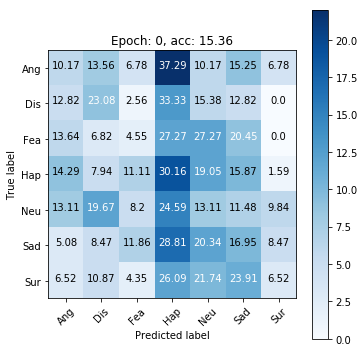

Epoch  0 , acc_train: 21.5608448 acc_val: 15.3638810 , loss_trian: 1.9901950 **3
*******************************************************
Normalized confusion matrix


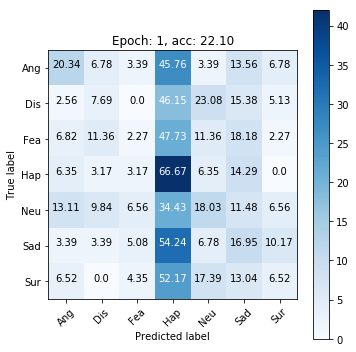

Epoch  1 , acc_train: 28.4391522 acc_val: 22.1024245 , loss_trian: 1.8296860 **3
*******************************************************
Normalized confusion matrix


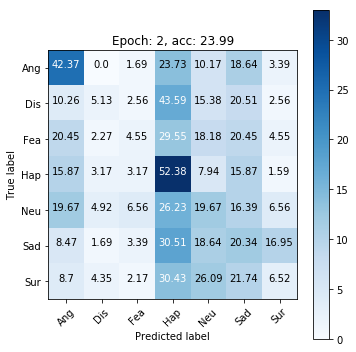

Epoch  2 , acc_train: 34.2592567 acc_val: 23.9892185 , loss_trian: 1.7100520 **3
*******************************************************
Normalized confusion matrix


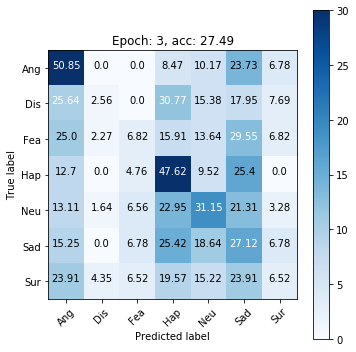

Epoch  3 , acc_train: 42.4603134 acc_val: 27.4932623 , loss_trian: 1.5848945 **3
*******************************************************
Normalized confusion matrix


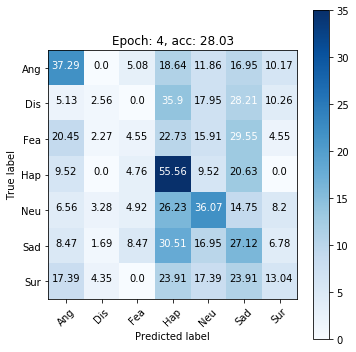

Epoch  4 , acc_train: 48.8095224 acc_val: 28.0323446 , loss_trian: 1.4707786 **3
*******************************************************
Normalized confusion matrix


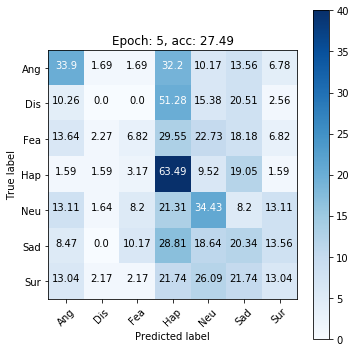

Epoch  5 , acc_train: 50.3968239 acc_val: 27.4932623 , loss_trian: 1.4273190 **3
*******************************************************
Normalized confusion matrix


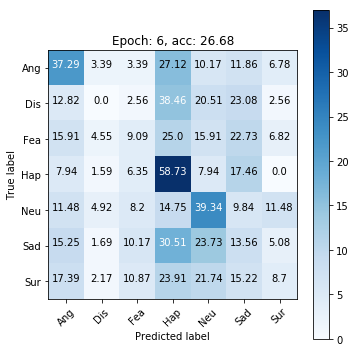

Epoch  6 , acc_train: 52.5132298 acc_val: 26.6846359 , loss_trian: 1.3594998 **3
*******************************************************
Normalized confusion matrix


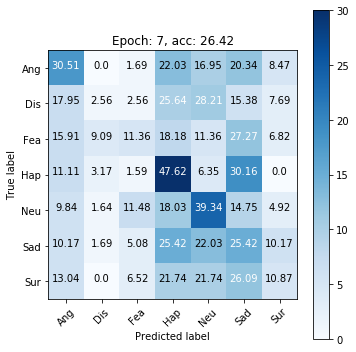

Epoch  7 , acc_train: 57.9365075 acc_val: 26.4150947 , loss_trian: 1.2877388 **3
*******************************************************
Normalized confusion matrix


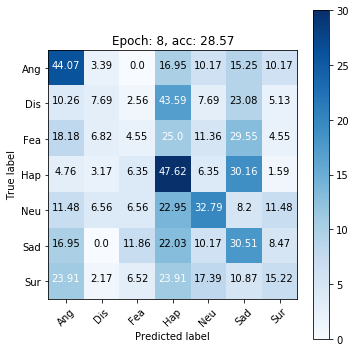

Epoch  8 , acc_train: 58.5978806 acc_val: 28.5714269 , loss_trian: 1.2003510 **3
*******************************************************
Normalized confusion matrix


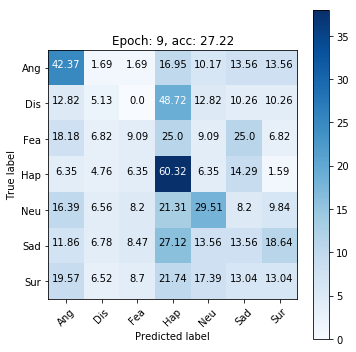

Epoch  9 , acc_train: 63.0952358 acc_val: 27.2237211 , loss_trian: 1.1470466 **3
*******************************************************
Normalized confusion matrix


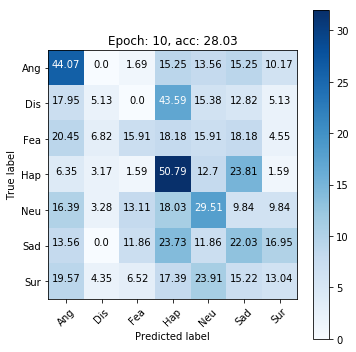

Epoch  10 , acc_train: 67.1957612 acc_val: 28.0323446 , loss_trian: 1.0684260 **3
*******************************************************
Normalized confusion matrix


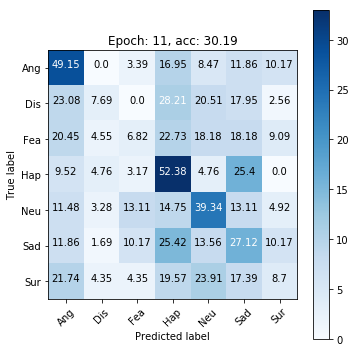

Epoch  11 , acc_train: 66.5343881 acc_val: 30.1886797 , loss_trian: 1.0419538 **3
*******************************************************
Normalized confusion matrix


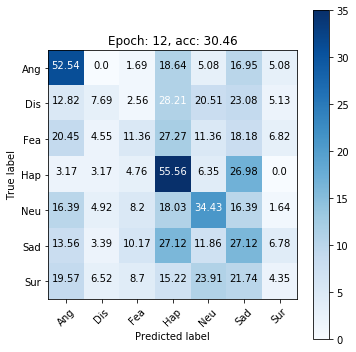

Epoch  12 , acc_train: 68.6507940 acc_val: 30.4582179 , loss_trian: 1.0083761 **3
*******************************************************
Normalized confusion matrix


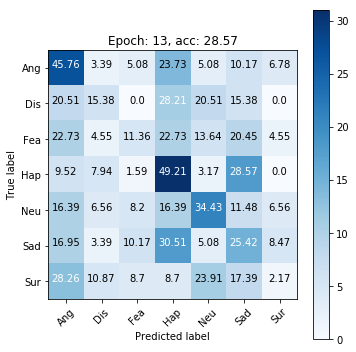

Epoch  13 , acc_train: 73.0158687 acc_val: 28.5714269 , loss_trian: 0.9089028 **3
*******************************************************
Normalized confusion matrix


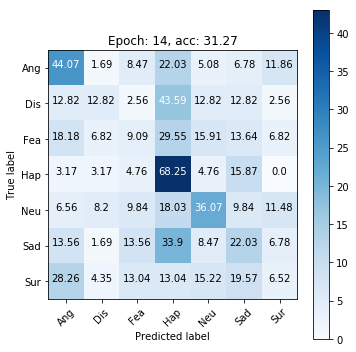

Epoch  14 , acc_train: 74.3386209 acc_val: 31.2668443 , loss_trian: 0.8783920 **3
*******************************************************
Normalized confusion matrix


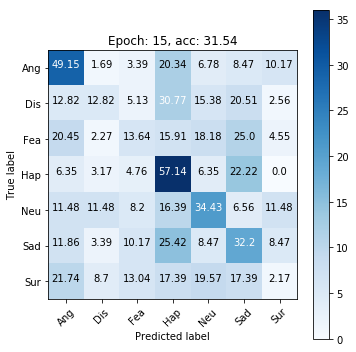

Epoch  15 , acc_train: 76.9841194 acc_val: 31.5363884 , loss_trian: 0.7969621 **3
*******************************************************
Normalized confusion matrix


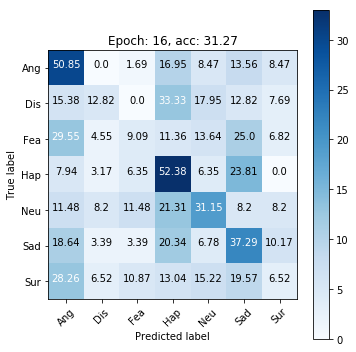

Epoch  16 , acc_train: 77.7777672 acc_val: 31.2668443 , loss_trian: 0.7840918 **3
*******************************************************
Normalized confusion matrix


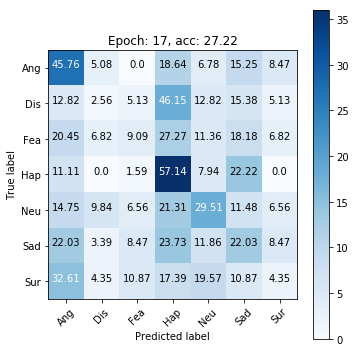

Epoch  17 , acc_train: 80.6878209 acc_val: 27.2237182 , loss_trian: 0.7262441 **3
*******************************************************
Normalized confusion matrix


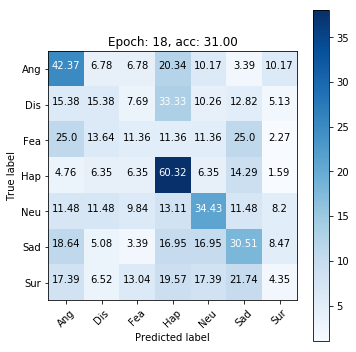

Epoch  18 , acc_train: 82.1428537 acc_val: 30.9973061 , loss_trian: 0.7063228 **3
*******************************************************
Normalized confusion matrix


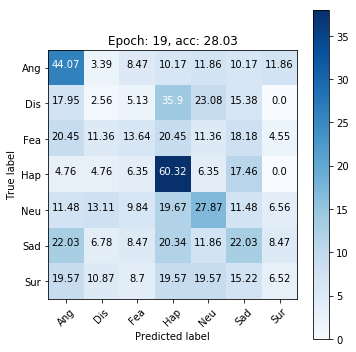

Epoch  19 , acc_train: 84.1269851 acc_val: 28.0323446 , loss_trian: 0.6424543 **3
*******************************************************
Normalized confusion matrix


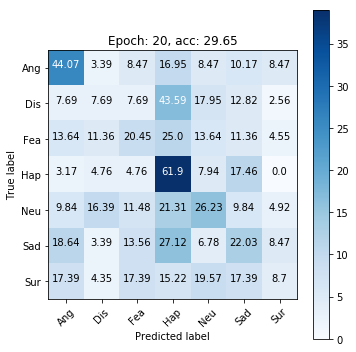

Epoch  20 , acc_train: 85.5820179 acc_val: 29.6495974 , loss_trian: 0.6291355 **3
*******************************************************
Normalized confusion matrix


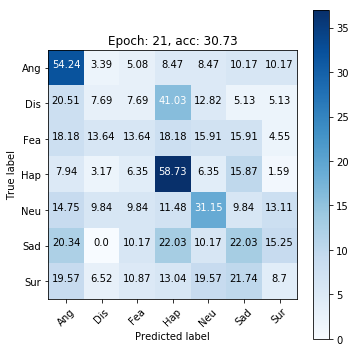

Epoch  21 , acc_train: 85.5820060 acc_val: 30.7277620 , loss_trian: 0.6104368 **3
*******************************************************
Normalized confusion matrix


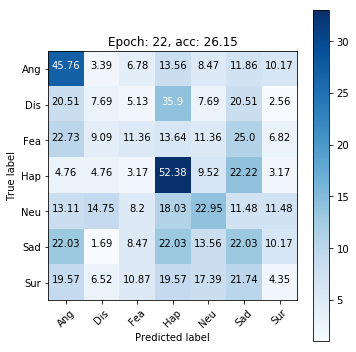

Epoch  22 , acc_train: 85.9788358 acc_val: 26.1455506 , loss_trian: 0.5735559 **3
*******************************************************
Normalized confusion matrix


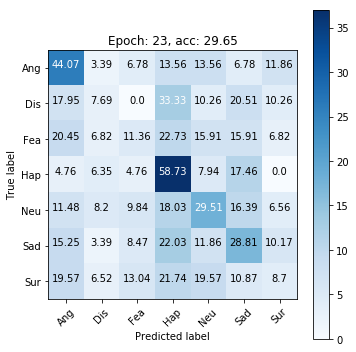

Epoch  23 , acc_train: 87.4338627 acc_val: 29.6495974 , loss_trian: 0.5467622 **3
*******************************************************
Normalized confusion matrix


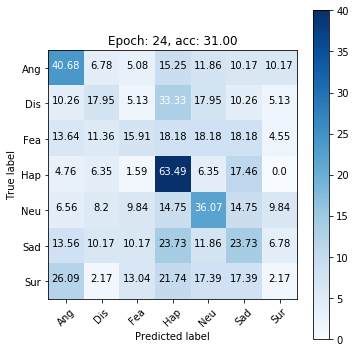

Epoch  24 , acc_train: 87.8306866 acc_val: 30.9973061 , loss_trian: 0.5473508 **3
*******************************************************
Normalized confusion matrix


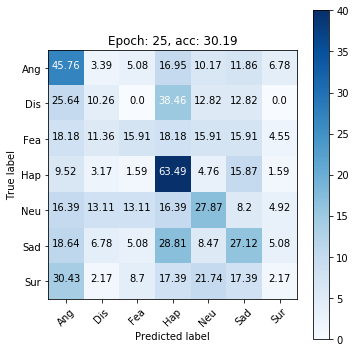

Epoch  25 , acc_train: 88.8888836 acc_val: 30.1886797 , loss_trian: 0.4928600 **3
*******************************************************
Normalized confusion matrix


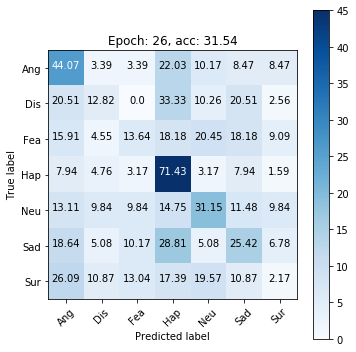

Epoch  26 , acc_train: 88.0952299 acc_val: 31.5363884 , loss_trian: 0.4808062 **3
*******************************************************
Normalized confusion matrix


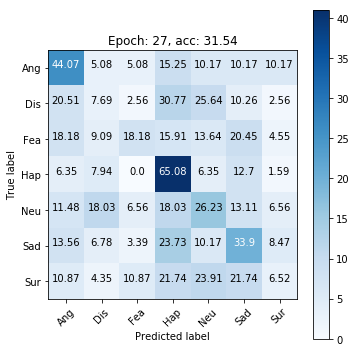

Epoch  27 , acc_train: 91.2698388 acc_val: 31.5363854 , loss_trian: 0.4391803 **3
*******************************************************
Normalized confusion matrix


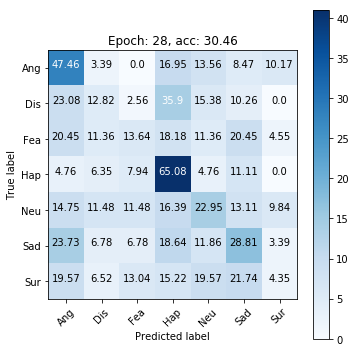

Epoch  28 , acc_train: 91.1375582 acc_val: 30.4582208 , loss_trian: 0.4241135 **3
*******************************************************
Normalized confusion matrix


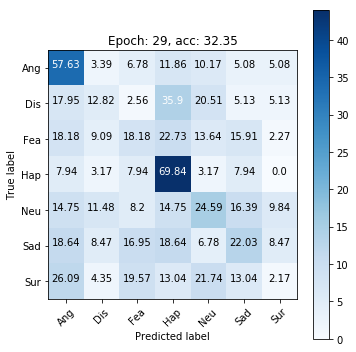

Epoch  29 , acc_train: 89.8148060 acc_val: 32.3450148 , loss_trian: 0.4403754 **3
*******************************************************
Normalized confusion matrix


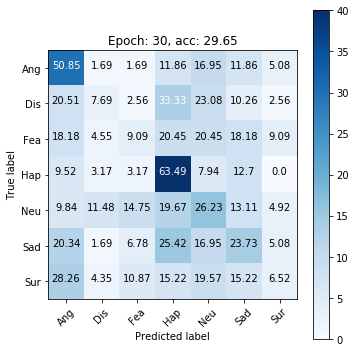

Epoch  30 , acc_train: 92.1957672 acc_val: 29.6495914 , loss_trian: 0.3883609 **3
*******************************************************
Normalized confusion matrix


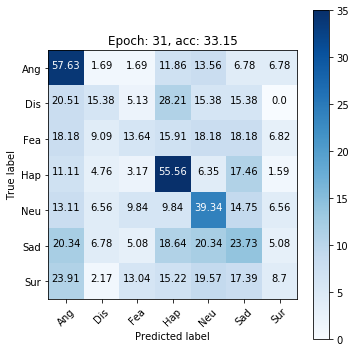

Epoch  31 , acc_train: 93.1217015 acc_val: 33.1536382 , loss_trian: 0.3728288 **3
*******************************************************
Normalized confusion matrix


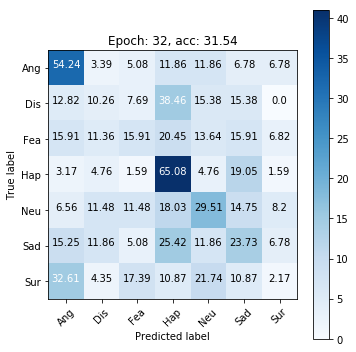

Epoch  32 , acc_train: 95.1058149 acc_val: 31.5363854 , loss_trian: 0.3249055 **3
*******************************************************
Normalized confusion matrix


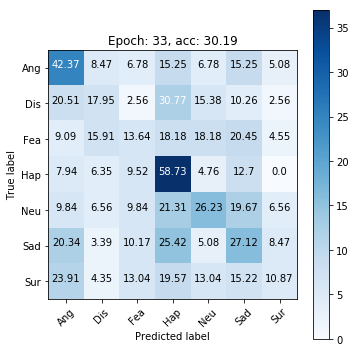

Epoch  33 , acc_train: 93.9153373 acc_val: 30.1886797 , loss_trian: 0.3330832 **3
*******************************************************
Normalized confusion matrix


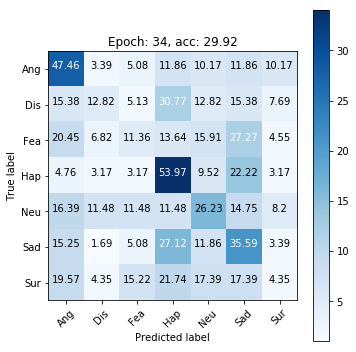

Epoch  34 , acc_train: 94.0476120 acc_val: 29.9191356 , loss_trian: 0.3346345 **3
*******************************************************
Normalized confusion matrix


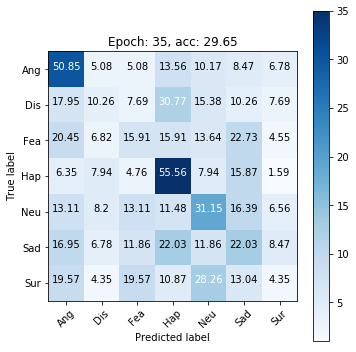

Epoch  35 , acc_train: 93.3862448 acc_val: 29.6495944 , loss_trian: 0.3222040 **3
*******************************************************
Normalized confusion matrix


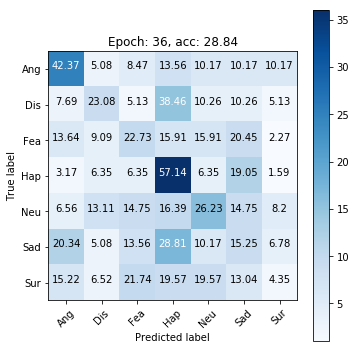

Epoch  36 , acc_train: 95.7672000 acc_val: 28.8409680 , loss_trian: 0.2745470 **3
*******************************************************
Normalized confusion matrix


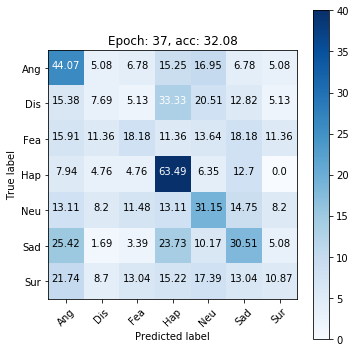

Epoch  37 , acc_train: 95.6349194 acc_val: 32.0754737 , loss_trian: 0.2789177 **3
*******************************************************
Normalized confusion matrix


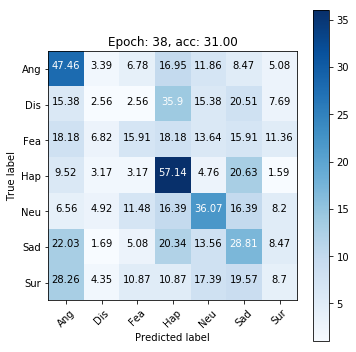

Epoch  38 , acc_train: 95.2380896 acc_val: 30.9973031 , loss_trian: 0.2671576 **3
*******************************************************
Normalized confusion matrix


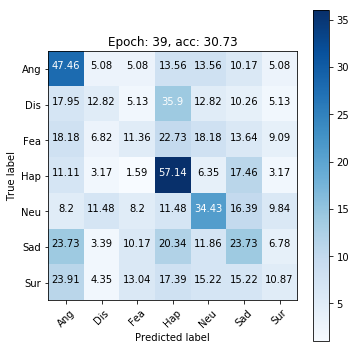

Epoch  39 , acc_train: 94.3121672 acc_val: 30.7277620 , loss_trian: 0.2819352 **3
*******************************************************
Normalized confusion matrix


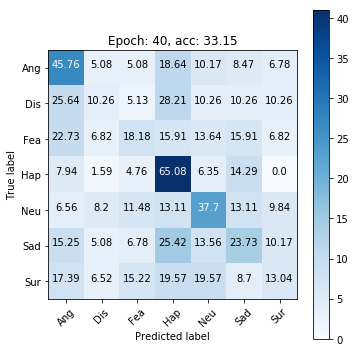

Epoch  40 , acc_train: 96.1640179 acc_val: 33.1536412 , loss_trian: 0.2556273 **3
*******************************************************
Normalized confusion matrix


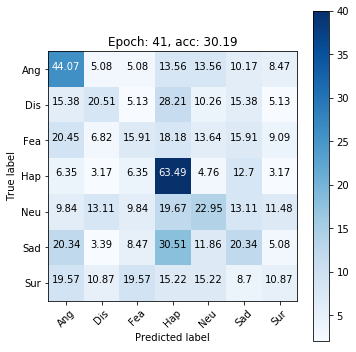

Epoch  41 , acc_train: 96.8253970 acc_val: 30.1886797 , loss_trian: 0.2410514 **3
*******************************************************
Normalized confusion matrix


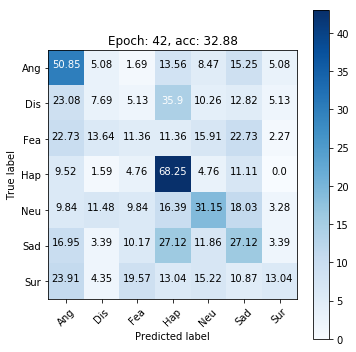

Epoch  42 , acc_train: 96.1640179 acc_val: 32.8840971 , loss_trian: 0.2273468 **3
*******************************************************
Normalized confusion matrix


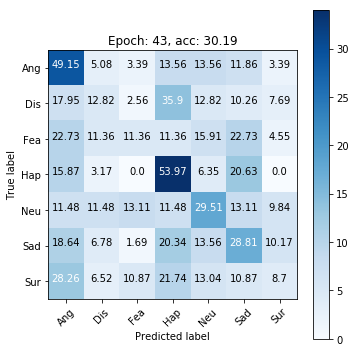

Epoch  43 , acc_train: 96.5608418 acc_val: 30.1886767 , loss_trian: 0.2294610 **3
*******************************************************
Normalized confusion matrix


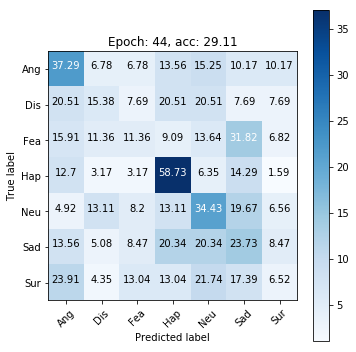

Epoch  44 , acc_train: 97.4867761 acc_val: 29.1105121 , loss_trian: 0.2023004 **3
*******************************************************
Normalized confusion matrix


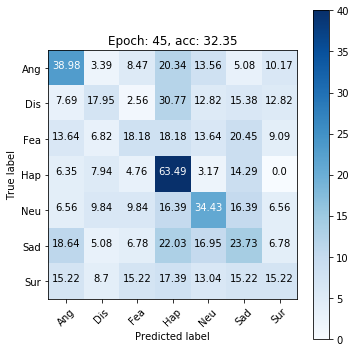

Epoch  45 , acc_train: 96.5608418 acc_val: 32.3450148 , loss_trian: 0.2073577 **3
*******************************************************
Normalized confusion matrix


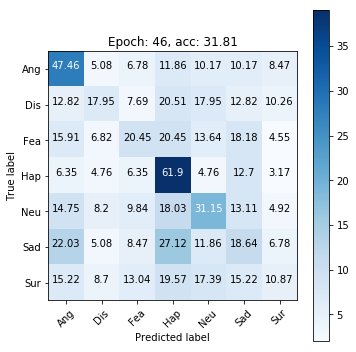

Epoch  46 , acc_train: 97.3544955 acc_val: 31.8059295 , loss_trian: 0.1948731 **3
*******************************************************
Normalized confusion matrix


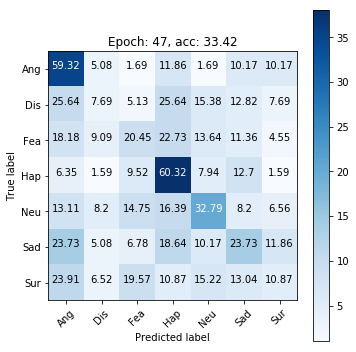

Epoch  47 , acc_train: 98.0158746 acc_val: 33.4231794 , loss_trian: 0.1876054 **3
*******************************************************
Normalized confusion matrix


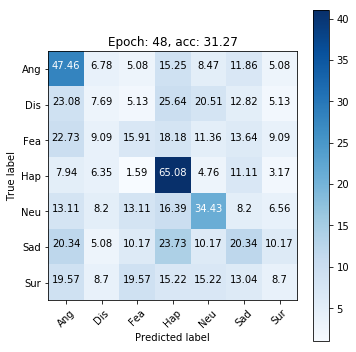

Epoch  48 , acc_train: 97.4867761 acc_val: 31.2668413 , loss_trian: 0.1614619 **3
*******************************************************
Normalized confusion matrix


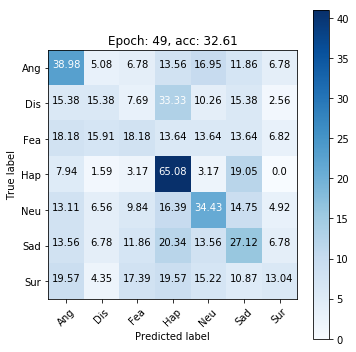

Epoch  49 , acc_train: 98.4126985 acc_val: 32.6145560 , loss_trian: 0.1574520 **3
*******************************************************
Normalized confusion matrix


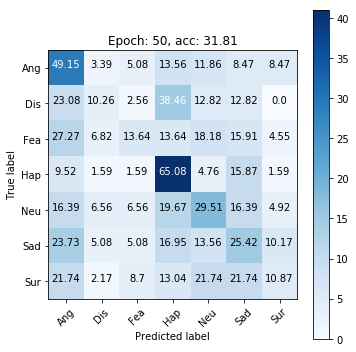

Epoch  50 , acc_train: 97.6190507 acc_val: 31.8059325 , loss_trian: 0.1732225 **3
*******************************************************
Normalized confusion matrix


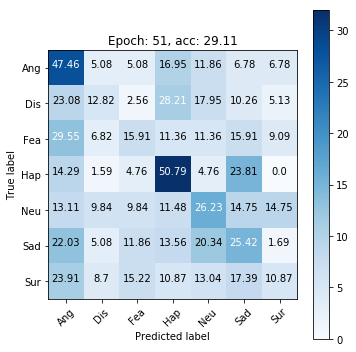

Epoch  51 , acc_train: 97.7513254 acc_val: 29.1105121 , loss_trian: 0.1710714 **3
*******************************************************
Normalized confusion matrix


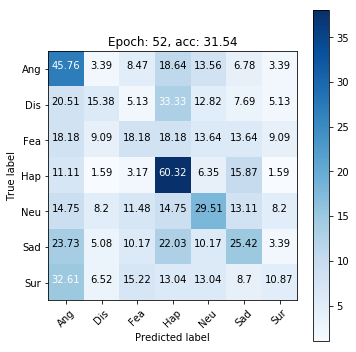

Epoch  52 , acc_train: 97.8836000 acc_val: 31.5363884 , loss_trian: 0.1529304 **3
*******************************************************
Normalized confusion matrix


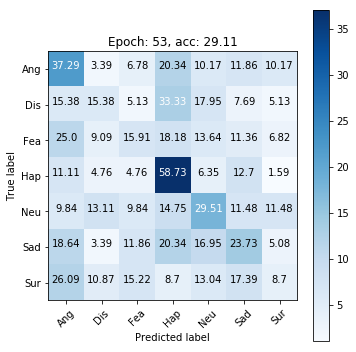

Epoch  53 , acc_train: 98.5449731 acc_val: 29.1105092 , loss_trian: 0.1488190 **3
*******************************************************
Normalized confusion matrix


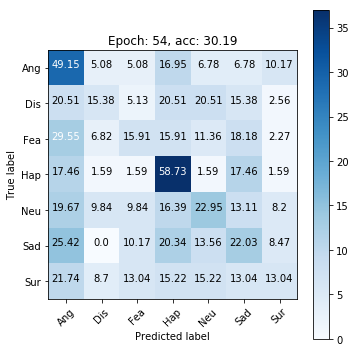

Epoch  54 , acc_train: 98.4126985 acc_val: 30.1886797 , loss_trian: 0.1480428 **3
*******************************************************
Normalized confusion matrix


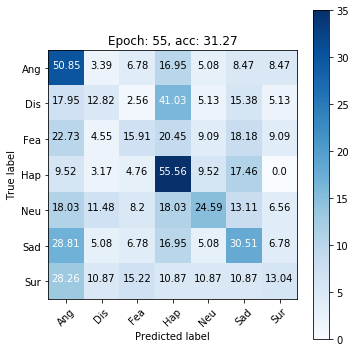

Epoch  55 , acc_train: 98.2804239 acc_val: 31.2668443 , loss_trian: 0.1534425 **3
*******************************************************
Normalized confusion matrix


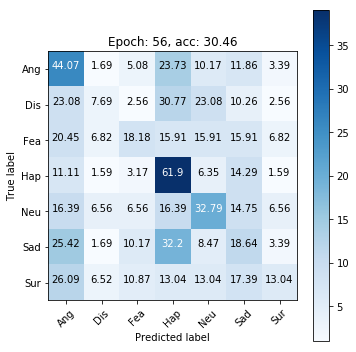

Epoch  56 , acc_train: 98.5449731 acc_val: 30.4582208 , loss_trian: 0.1424268 **3
*******************************************************
Normalized confusion matrix


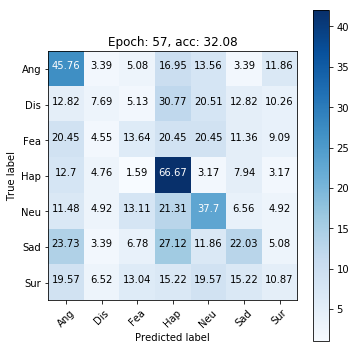

Epoch  57 , acc_train: 98.0158687 acc_val: 32.0754707 , loss_trian: 0.1306297 **3
*******************************************************
Normalized confusion matrix


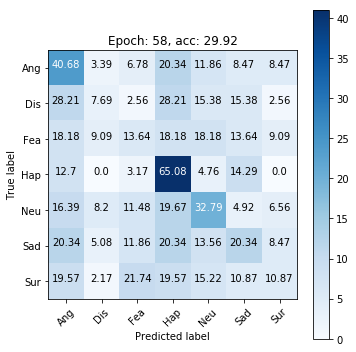

Epoch  58 , acc_train: 98.6772478 acc_val: 29.9191356 , loss_trian: 0.1207035 **3
*******************************************************
Normalized confusion matrix


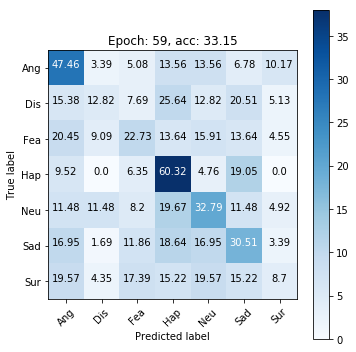

Epoch  59 , acc_train: 98.5449731 acc_val: 33.1536382 , loss_trian: 0.1247333 **3
*******************************************************
Normalized confusion matrix


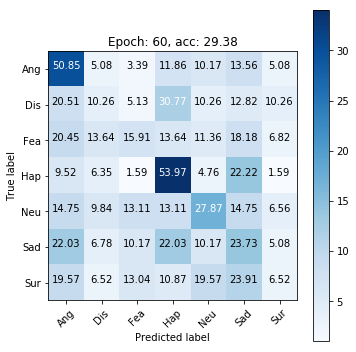

Epoch  60 , acc_train: 98.8095224 acc_val: 29.3800533 , loss_trian: 0.1113865 **3
*******************************************************
Normalized confusion matrix


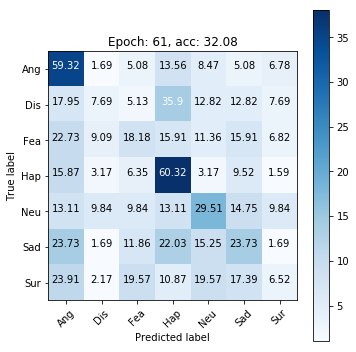

Epoch  61 , acc_train: 99.4708955 acc_val: 32.0754707 , loss_trian: 0.1007413 **3
*******************************************************
Normalized confusion matrix


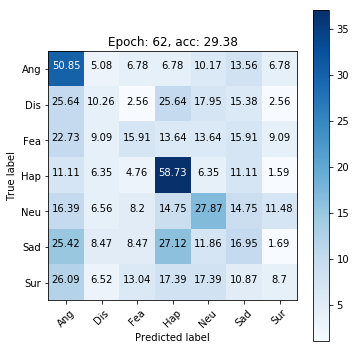

Epoch  62 , acc_train: 98.8095224 acc_val: 29.3800533 , loss_trian: 0.1072568 **3
*******************************************************
Normalized confusion matrix


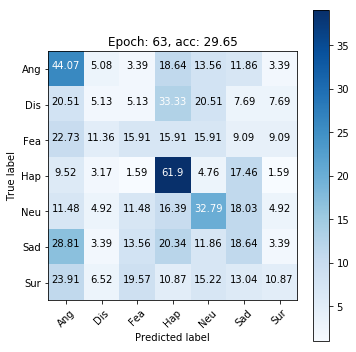

Epoch  63 , acc_train: 99.0740716 acc_val: 29.6495944 , loss_trian: 0.1040685 **3
*******************************************************
Normalized confusion matrix


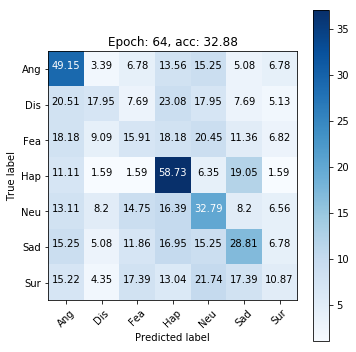

Epoch  64 , acc_train: 98.6772478 acc_val: 32.8840971 , loss_trian: 0.1050838 **3
*******************************************************
Normalized confusion matrix


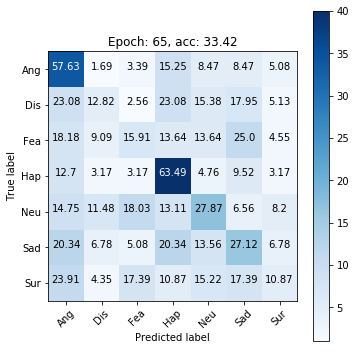

Epoch  65 , acc_train: 98.9417970 acc_val: 33.4231794 , loss_trian: 0.1148039 **3
*******************************************************
Normalized confusion matrix


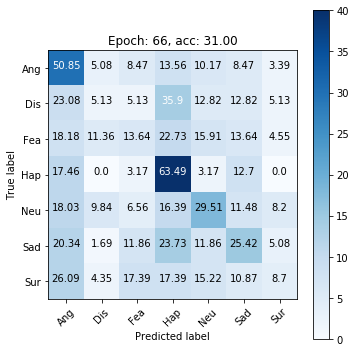

Epoch  66 , acc_train: 98.5449731 acc_val: 30.9973001 , loss_trian: 0.1072404 **3
*******************************************************
Normalized confusion matrix


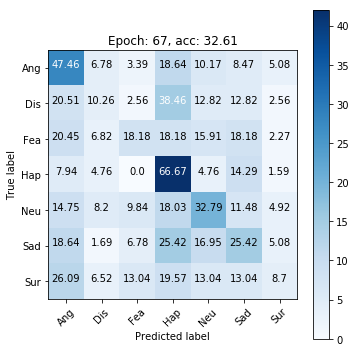

Epoch  67 , acc_train: 98.8095224 acc_val: 32.6145530 , loss_trian: 0.0948564 **3
*******************************************************
Normalized confusion matrix


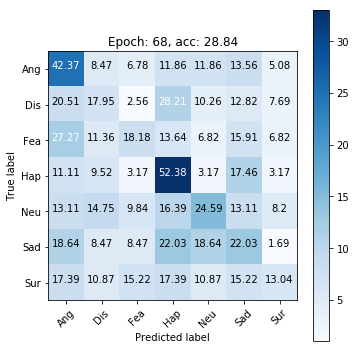

Epoch  68 , acc_train: 99.6031702 acc_val: 28.8409680 , loss_trian: 0.0860606 **3
*******************************************************
Normalized confusion matrix


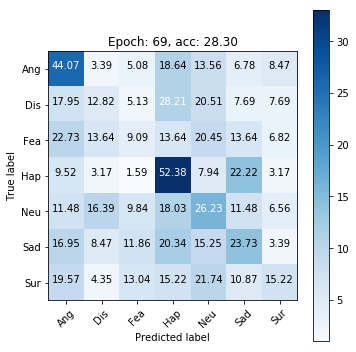

Epoch  69 , acc_train: 99.6031702 acc_val: 28.3018857 , loss_trian: 0.0841957 **3
*******************************************************
Normalized confusion matrix


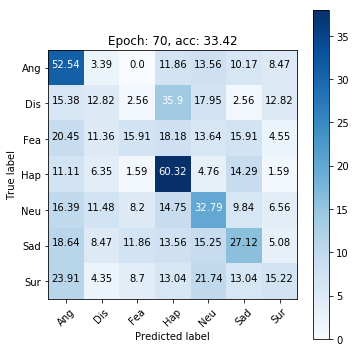

Epoch  70 , acc_train: 99.4708955 acc_val: 33.4231794 , loss_trian: 0.0870560 **3
*******************************************************
Normalized confusion matrix


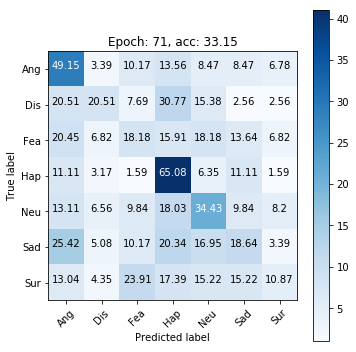

Epoch  71 , acc_train: 99.2063463 acc_val: 33.1536382 , loss_trian: 0.0826350 **3
*******************************************************
Normalized confusion matrix


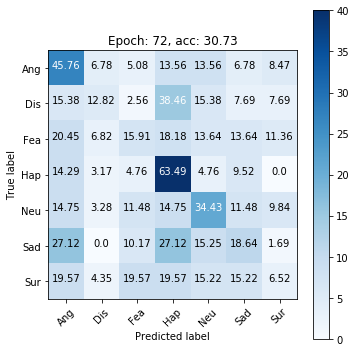

Epoch  72 , acc_train: 99.2063463 acc_val: 30.7277620 , loss_trian: 0.0863840 **3
*******************************************************
Normalized confusion matrix


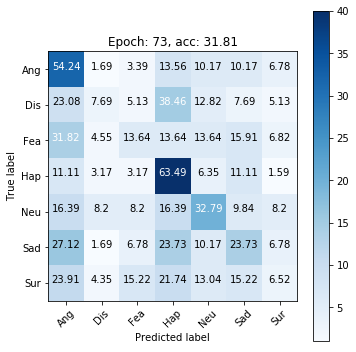

Epoch  73 , acc_train: 99.0740716 acc_val: 31.8059295 , loss_trian: 0.0867629 **3
*******************************************************
Normalized confusion matrix


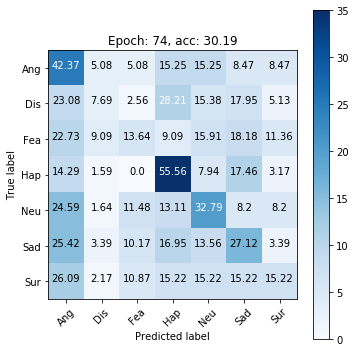

Epoch  74 , acc_train: 99.3386209 acc_val: 30.1886797 , loss_trian: 0.0825293 **3
*******************************************************
Normalized confusion matrix


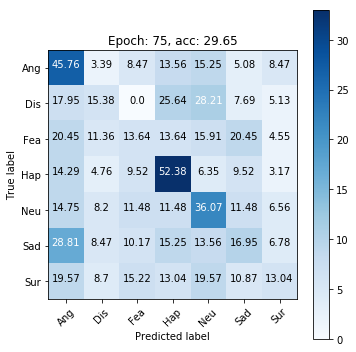

Epoch  75 , acc_train: 99.4708955 acc_val: 29.6495944 , loss_trian: 0.0747239 **3
*******************************************************
Normalized confusion matrix


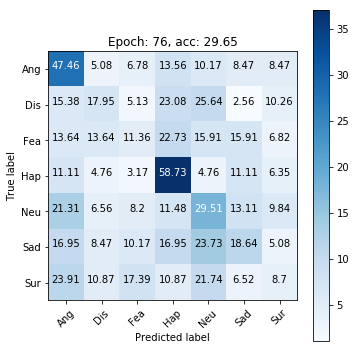

Epoch  76 , acc_train: 99.4708955 acc_val: 29.6495944 , loss_trian: 0.0811206 **3
*******************************************************
Normalized confusion matrix


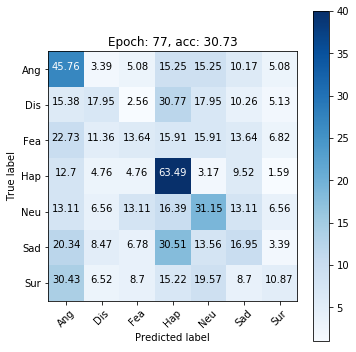

Epoch  77 , acc_train: 99.9999940 acc_val: 30.7277620 , loss_trian: 0.0659069 **3
*******************************************************
Normalized confusion matrix


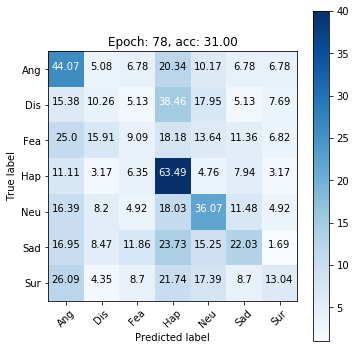

Epoch  78 , acc_train: 99.2063463 acc_val: 30.9973061 , loss_trian: 0.0791077 **3
*******************************************************
Normalized confusion matrix


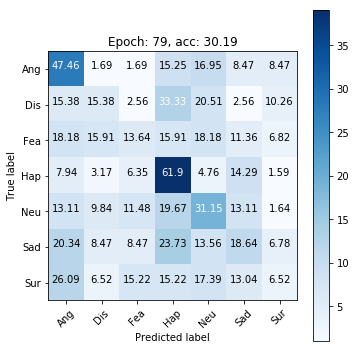

Epoch  79 , acc_train: 99.4708955 acc_val: 30.1886797 , loss_trian: 0.0708010 **3
*******************************************************
Normalized confusion matrix


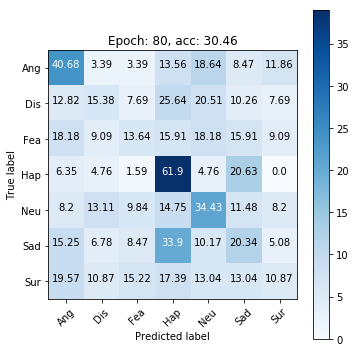

Epoch  80 , acc_train: 99.7354448 acc_val: 30.4582208 , loss_trian: 0.0608068 **3
*******************************************************
Normalized confusion matrix


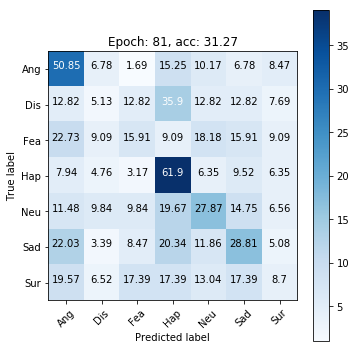

Epoch  81 , acc_train: 99.7354448 acc_val: 31.2668443 , loss_trian: 0.0599419 **3
*******************************************************
Normalized confusion matrix


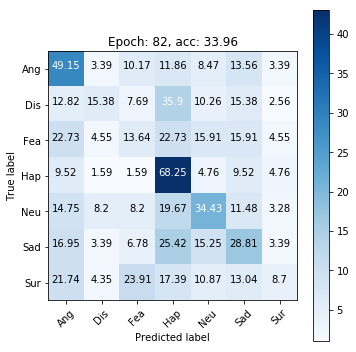

Epoch  82 , acc_train: 99.6031702 acc_val: 33.9622647 , loss_trian: 0.0558157 **3
*******************************************************
Normalized confusion matrix


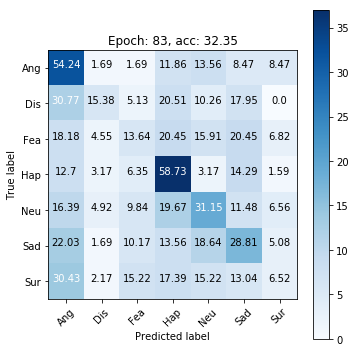

Epoch  83 , acc_train: 99.8677194 acc_val: 32.3450148 , loss_trian: 0.0586829 **3
*******************************************************
Normalized confusion matrix


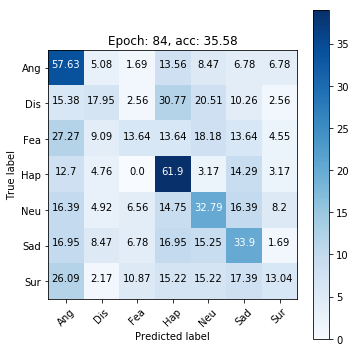

Epoch  84 , acc_train: 99.7354448 acc_val: 35.5795175 , loss_trian: 0.0545620 **3
*******************************************************
Normalized confusion matrix


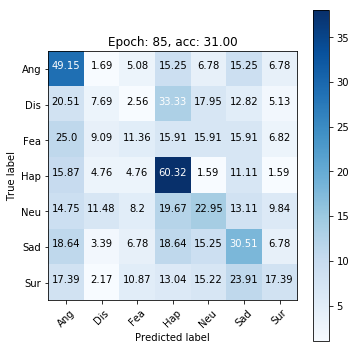

Epoch  85 , acc_train: 99.9999940 acc_val: 30.9973061 , loss_trian: 0.0584446 **3
*******************************************************
Normalized confusion matrix


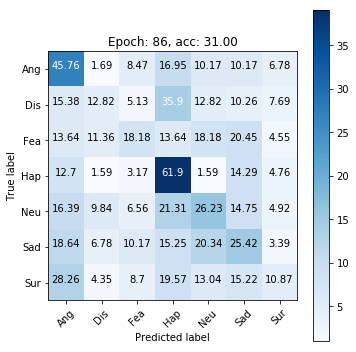

Epoch  86 , acc_train: 99.9999940 acc_val: 30.9973031 , loss_trian: 0.0512334 **3
*******************************************************
Normalized confusion matrix


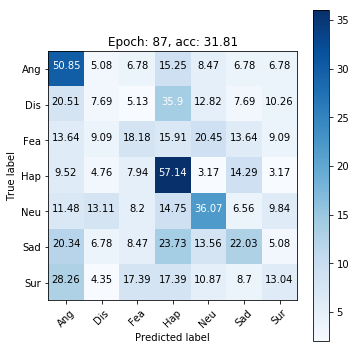

Epoch  87 , acc_train: 99.7354448 acc_val: 31.8059295 , loss_trian: 0.0480625 **3
*******************************************************
Normalized confusion matrix


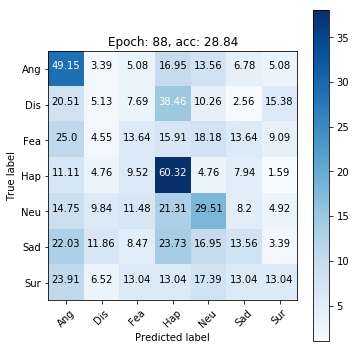

Epoch  88 , acc_train: 99.4708955 acc_val: 28.8409710 , loss_trian: 0.0555984 **3
*******************************************************
Normalized confusion matrix


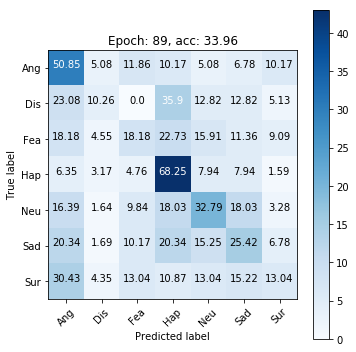

Epoch  89 , acc_train: 99.7354448 acc_val: 33.9622617 , loss_trian: 0.0538073 **3
*******************************************************
Normalized confusion matrix


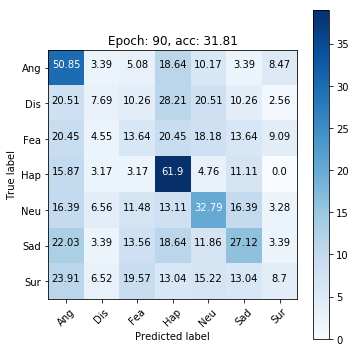

Epoch  90 , acc_train: 99.6031702 acc_val: 31.8059325 , loss_trian: 0.0492923 **3
*******************************************************
Normalized confusion matrix


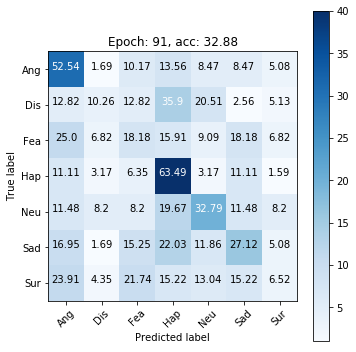

Epoch  91 , acc_train: 99.8677194 acc_val: 32.8840971 , loss_trian: 0.0484735 **3
*******************************************************
Normalized confusion matrix


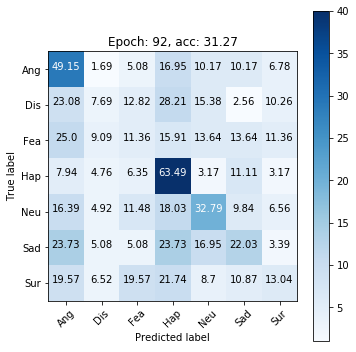

Epoch  92 , acc_train: 99.6031702 acc_val: 31.2668443 , loss_trian: 0.0558301 **3
*******************************************************
Normalized confusion matrix


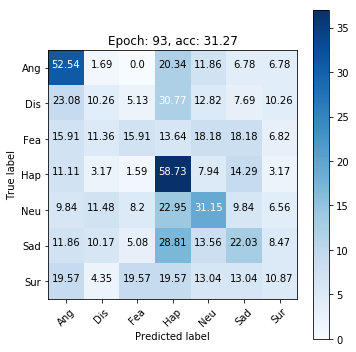

Epoch  93 , acc_train: 99.8677194 acc_val: 31.2668443 , loss_trian: 0.0504677 **3
*******************************************************
Normalized confusion matrix


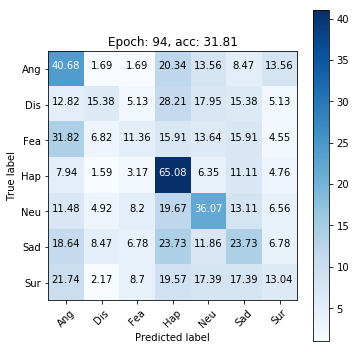

Epoch  94 , acc_train: 99.8677194 acc_val: 31.8059295 , loss_trian: 0.0442249 **3
*******************************************************
Normalized confusion matrix


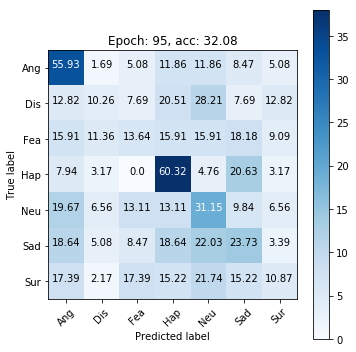

Epoch  95 , acc_train: 99.6031702 acc_val: 32.0754707 , loss_trian: 0.0501269 **3
*******************************************************
Normalized confusion matrix


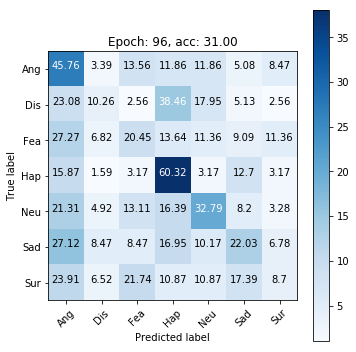

Epoch  96 , acc_train: 99.8677194 acc_val: 30.9973031 , loss_trian: 0.0405983 **3
*******************************************************
Normalized confusion matrix


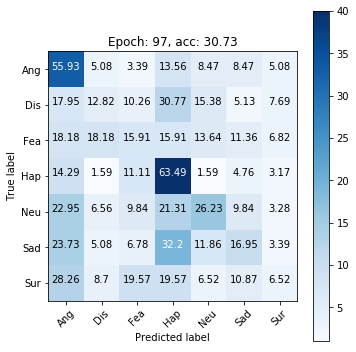

Epoch  97 , acc_train: 99.8677194 acc_val: 30.7277620 , loss_trian: 0.0437645 **3
*******************************************************
Normalized confusion matrix


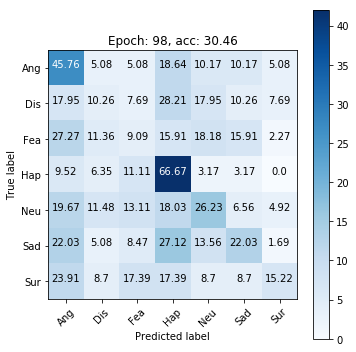

Epoch  98 , acc_train: 99.7354448 acc_val: 30.4582208 , loss_trian: 0.0402136 **3
*******************************************************
Normalized confusion matrix


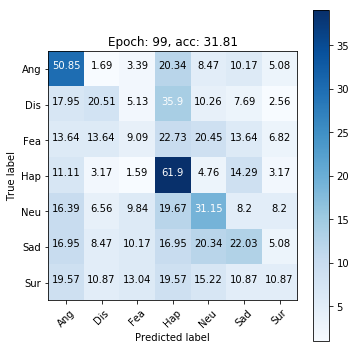

Epoch  99 , acc_train: 99.7354448 acc_val: 31.8059295 , loss_trian: 0.0407840 **3
*******************************************************


In [92]:
lstm_model(100, 160, 128, 16, 0.0001, 'adam', 'normal', 0.25)

In [ ]:
lstm_model(100, 160, 128, 16, 0.0001, 'adam', 'normal', 0.25)

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=100_batchSize=160_n_hidden=128_n_frame=16_lr=0.000100_opt=adam_init=normal_dropout=0.25
Epoch  0 , acc_train: 25.3968269 acc_val: 21.8328834 , loss_trian: 1.9138688
Epoch  0 , acc_train: 30.2910030 acc_val: 21.0242569 , loss_trian: 1.8470767 **2
Epoch  0 , acc_train: 31.7460328 acc_val: 21.0242569 , loss_trian: 1.8578848 **3
*******************************************************
Epoch  1 , acc_train: 25.9259284 acc_val: 19.6765497 , loss_trian: 1.9039503
Epoch  1 , acc_train: 39.4179881 acc_val: 21.2938011 , loss_trian: 1.7719448 **2
Epoch  1 , acc_train: 38.0952388 acc_val: 21.2937996 , loss_trian: 1.6740856 **3
*******************************************************
Epoch  2 , acc_train: 26.7195761 acc_val: 20.4851747 , loss_trian: 1.9016658
Epoch  2 , acc_train: 44.3121672 acc_val: 22.9110509 , loss_trian: 1.7148458 **2
Epoch  2 , acc_train: 44.3121731 acc_val: 22.9110509 , loss_trian: 1.5649315 **3
*******************************************************
Epoch  3 , acc_trai

Epoch  28 , acc_train: 62.1693075 acc_val: 28.8409710 , loss_trian: 1.7063682
Epoch  28 , acc_train: 89.8148060 acc_val: 33.9622647 , loss_trian: 1.2694962 **2
Epoch  28 , acc_train: 89.8148060 acc_val: 33.9622647 , loss_trian: 0.4197327 **3
*******************************************************
Epoch  29 , acc_train: 62.3015821 acc_val: 28.3018857 , loss_trian: 1.7104290
Epoch  29 , acc_train: 89.5502567 acc_val: 32.0754707 , loss_trian: 1.2680694 **2
Epoch  29 , acc_train: 89.5502567 acc_val: 30.7277620 , loss_trian: 0.4198250 **3
*******************************************************
Epoch  30 , acc_train: 63.8888896 acc_val: 32.0754707 , loss_trian: 1.7016399
Epoch  30 , acc_train: 90.6084597 acc_val: 31.5363884 , loss_trian: 1.2595036 **2
Epoch  30 , acc_train: 89.5502567 acc_val: 32.0754707 , loss_trian: 0.3826825 **3
*******************************************************
Epoch  31 , acc_train: 62.6984119 acc_val: 29.3800533 , loss_trian: 1.7022023
Epoch  31 , acc_train: 91.53

Epoch  56 , acc_train: 73.9417911 acc_val: 29.9191356 , loss_trian: 1.5993521
Epoch  56 , acc_train: 97.4867702 acc_val: 31.5363854 , loss_trian: 1.1901304 **2
Epoch  56 , acc_train: 96.6931224 acc_val: 31.8059295 , loss_trian: 0.1393666 **3
*******************************************************
Epoch  57 , acc_train: 75.6613731 acc_val: 29.1105092 , loss_trian: 1.6041425
Epoch  57 , acc_train: 97.0899463 acc_val: 31.8059266 , loss_trian: 1.1949079 **2
Epoch  57 , acc_train: 97.0899463 acc_val: 31.8059325 , loss_trian: 0.1350532 **3
*******************************************************
Epoch  58 , acc_train: 75.0000000 acc_val: 34.7708881 , loss_trian: 1.5934784
Epoch  58 , acc_train: 97.6190448 acc_val: 33.9622617 , loss_trian: 1.1910573 **2
Epoch  58 , acc_train: 96.6931224 acc_val: 33.4231764 , loss_trian: 0.1395414 **3
*******************************************************
Epoch  59 , acc_train: 77.7777731 acc_val: 32.3450118 , loss_trian: 1.5816587
Epoch  59 , acc_train: 97.61

Epoch  84 , acc_train: 82.4074090 acc_val: 33.4231794 , loss_trian: 1.5110539
Epoch  84 , acc_train: 98.8095224 acc_val: 33.4231794 , loss_trian: 1.1769120 **2
Epoch  84 , acc_train: 98.4126985 acc_val: 33.1536353 , loss_trian: 0.0676415 **3
*******************************************************
Epoch  85 , acc_train: 80.5555522 acc_val: 31.5363884 , loss_trian: 1.5229083
Epoch  85 , acc_train: 99.0740716 acc_val: 32.3450118 , loss_trian: 1.1749856 **2
Epoch  85 , acc_train: 98.8095224 acc_val: 32.3450118 , loss_trian: 0.0557365 **3
*******************************************************
Epoch  86 , acc_train: 80.1587224 acc_val: 32.8840971 , loss_trian: 1.5200218
Epoch  86 , acc_train: 98.8095224 acc_val: 33.1536382 , loss_trian: 1.1757632 **2
Epoch  86 , acc_train: 99.2063463 acc_val: 33.9622617 , loss_trian: 0.0571527 **3
*******************************************************
Epoch  87 , acc_train: 82.1428537 acc_val: 31.5363884 , loss_trian: 1.5028256
Epoch  87 , acc_train: 99.47

In [165]:
lstm_model(100, 160, 128, 16, 0.001, 'sgd', 'normal') # after adding dropout, n_frame

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=100_batchSize=160_n_hidden=128_n_frame=16_lr=0.001000_opt=sgd_init=normal
Epoch  0 , acc_train: 18.2539687 acc_val: 15.9029648 , loss_trian: 1.9379660
Epoch  0 , acc_train: 18.9153418 acc_val: 16.4420471 , loss_trian: 1.9667076 **2
Epoch  0 , acc_train: 18.2539672 acc_val: 16.4420471 , loss_trian: 1.9769113 **3
*******************************************************
Epoch  1 , acc_train: 18.2539687 acc_val: 15.3638810 , loss_trian: 1.9384118
Epoch  1 , acc_train: 17.7248672 acc_val: 16.1725074 , loss_trian: 1.9655797 **2
Epoch  1 , acc_train: 18.1216940 acc_val: 16.1725074 , loss_trian: 1.9567860 **3
*******************************************************
Epoch  2 , acc_train: 19.8412701 acc_val: 16.7115897 , loss_trian: 1.9343934
Epoch  2 , acc_train: 20.5026463 acc_val: 17.5202146 , loss_trian: 1.9409460 **2
Epoch  2 , acc_train: 21.1640194 acc_val: 17.5202146 , loss_trian: 1.9226303 **3
*******************************************************
Epoch  3 , acc_train: 19.1798940 

Epoch  28 , acc_train: 38.7566149 acc_val: 22.3719686 , loss_trian: 1.8794165
Epoch  28 , acc_train: 48.4127015 acc_val: 25.8760095 , loss_trian: 1.6799805 **2
Epoch  28 , acc_train: 49.9999940 acc_val: 26.1455536 , loss_trian: 1.5978891 **3
*******************************************************
Epoch  29 , acc_train: 34.5238060 acc_val: 22.9110509 , loss_trian: 1.8807839
Epoch  29 , acc_train: 48.2804239 acc_val: 25.0673860 , loss_trian: 1.6762965 **2
Epoch  29 , acc_train: 48.5449731 acc_val: 24.7978449 , loss_trian: 1.5997931 **3
*******************************************************
Epoch  30 , acc_train: 32.5396776 acc_val: 24.7978419 , loss_trian: 1.8798177
Epoch  30 , acc_train: 50.1322746 acc_val: 26.4150918 , loss_trian: 1.6621999 **2
Epoch  30 , acc_train: 50.1322746 acc_val: 26.4150918 , loss_trian: 1.5829171 **3
*******************************************************
Epoch  31 , acc_train: 34.9206328 acc_val: 24.5283037 , loss_trian: 1.8839585
Epoch  31 , acc_train: 51.58

Epoch  56 , acc_train: 43.5185134 acc_val: 26.4150947 , loss_trian: 1.8382658
Epoch  56 , acc_train: 61.9047642 acc_val: 29.6495974 , loss_trian: 1.5498949 **2
Epoch  56 , acc_train: 59.5238090 acc_val: 29.3800533 , loss_trian: 1.3826815 **3
*******************************************************
Epoch  57 , acc_train: 44.1798955 acc_val: 26.9541740 , loss_trian: 1.8347660
Epoch  57 , acc_train: 59.1269851 acc_val: 26.1455536 , loss_trian: 1.5618675 **2
Epoch  57 , acc_train: 59.9206328 acc_val: 26.4150947 , loss_trian: 1.3862095 **3
*******************************************************
Epoch  58 , acc_train: 46.0317433 acc_val: 27.7628034 , loss_trian: 1.8383045
Epoch  58 , acc_train: 60.5820060 acc_val: 28.3018827 , loss_trian: 1.5554867 **2
Epoch  58 , acc_train: 60.8465612 acc_val: 28.5714298 , loss_trian: 1.3706479 **3
*******************************************************
Epoch  59 , acc_train: 44.5767164 acc_val: 28.8409710 , loss_trian: 1.8340490
Epoch  59 , acc_train: 60.84

Epoch  84 , acc_train: 46.6931224 acc_val: 25.3369272 , loss_trian: 1.8179182
Epoch  84 , acc_train: 69.1798925 acc_val: 27.2237182 , loss_trian: 1.4765766 **2
Epoch  84 , acc_train: 68.5185254 acc_val: 27.4932593 , loss_trian: 1.2096516 **3
*******************************************************
Epoch  85 , acc_train: 54.1005254 acc_val: 30.4582179 , loss_trian: 1.8012536
Epoch  85 , acc_train: 68.3862388 acc_val: 29.3800533 , loss_trian: 1.4798579 **2
Epoch  85 , acc_train: 69.0476179 acc_val: 29.1105121 , loss_trian: 1.1991358 **3
*******************************************************
Epoch  86 , acc_train: 50.1322746 acc_val: 31.8059295 , loss_trian: 1.8038721
Epoch  86 , acc_train: 69.0476120 acc_val: 29.3800533 , loss_trian: 1.4757168 **2
Epoch  86 , acc_train: 68.2539642 acc_val: 29.6495944 , loss_trian: 1.1996331 **3
*******************************************************
Epoch  87 , acc_train: 53.0423284 acc_val: 27.2237182 , loss_trian: 1.7964059
Epoch  87 , acc_train: 68.65

In [164]:
lstm_model(100, 160, 128, 16, 0.0001, 'adam', 'normal') # after adding dropout, n_frame

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=100_batchSize=160_n_hidden=128_n_frame=16_lr=0.000100_opt=adam_init=normal
Epoch  0 , acc_train: 29.3650776 acc_val: 23.4501332 , loss_trian: 1.9027983
Epoch  0 , acc_train: 32.4074090 acc_val: 20.7547158 , loss_trian: 1.8257152 **2
Epoch  0 , acc_train: 32.4074060 acc_val: 21.0242569 , loss_trian: 1.7584713 **3
*******************************************************
Epoch  1 , acc_train: 35.3174567 acc_val: 25.3369272 , loss_trian: 1.8747981
Epoch  1 , acc_train: 39.8148149 acc_val: 24.2587596 , loss_trian: 1.7533777 **2
Epoch  1 , acc_train: 40.8730149 acc_val: 24.2587596 , loss_trian: 1.6374508 **3
*******************************************************
Epoch  2 , acc_train: 38.3597851 acc_val: 27.7628005 , loss_trian: 1.8646985
Epoch  2 , acc_train: 46.5608448 acc_val: 28.3018887 , loss_trian: 1.6903660 **2
Epoch  2 , acc_train: 46.9576687 acc_val: 28.8409710 , loss_trian: 1.5465703 **3
*******************************************************
Epoch  3 , acc_train: 42.1957642

Epoch  28 , acc_train: 79.8941731 acc_val: 34.5013499 , loss_trian: 1.5685073
Epoch  28 , acc_train: 91.0052896 acc_val: 33.9622617 , loss_trian: 1.2568936 **2
Epoch  28 , acc_train: 90.0793552 acc_val: 34.2318058 , loss_trian: 0.4508327 **3
*******************************************************
Epoch  29 , acc_train: 81.7460299 acc_val: 35.5795145 , loss_trian: 1.5589592
Epoch  29 , acc_train: 92.1957612 acc_val: 36.6576821 , loss_trian: 1.2434427 **2
Epoch  29 , acc_train: 92.5925851 acc_val: 36.3881409 , loss_trian: 0.4005598 **3
*******************************************************
Epoch  30 , acc_train: 84.7883582 acc_val: 33.9622617 , loss_trian: 1.5480891
Epoch  30 , acc_train: 92.8571343 acc_val: 35.5795145 , loss_trian: 1.2405593 **2
Epoch  30 , acc_train: 92.7248597 acc_val: 34.7708911 , loss_trian: 0.3825054 **3
*******************************************************
Epoch  31 , acc_train: 85.5820060 acc_val: 32.3450118 , loss_trian: 1.5371760
Epoch  31 , acc_train: 93.38

Epoch  56 , acc_train: 94.3121672 acc_val: 32.6145530 , loss_trian: 1.3804991
Epoch  56 , acc_train: 98.5449731 acc_val: 32.8840941 , loss_trian: 1.1795378 **2
Epoch  56 , acc_train: 98.8095224 acc_val: 32.3450148 , loss_trian: 0.1181150 **3
*******************************************************
Epoch  57 , acc_train: 95.7671940 acc_val: 33.9622647 , loss_trian: 1.3838936
Epoch  57 , acc_train: 98.8095224 acc_val: 36.1185968 , loss_trian: 1.1768239 **2
Epoch  57 , acc_train: 98.8095224 acc_val: 36.1185998 , loss_trian: 0.1122626 **3
*******************************************************
Epoch  58 , acc_train: 93.2539701 acc_val: 30.1886797 , loss_trian: 1.3894861
Epoch  58 , acc_train: 98.9417970 acc_val: 30.9973061 , loss_trian: 1.1761943 **2
Epoch  58 , acc_train: 99.0740716 acc_val: 31.5363884 , loss_trian: 0.1187567 **3
*******************************************************
Epoch  59 , acc_train: 94.4444478 acc_val: 35.3099734 , loss_trian: 1.3892571
Epoch  59 , acc_train: 98.54

Epoch  84 , acc_train: 97.2222209 acc_val: 33.6927205 , loss_trian: 1.3134750
Epoch  84 , acc_train: 99.7354448 acc_val: 31.2668473 , loss_trian: 1.1680299 **2
Epoch  84 , acc_train: 99.7354448 acc_val: 31.8059295 , loss_trian: 0.0577755 **3
*******************************************************
Epoch  85 , acc_train: 97.7513254 acc_val: 33.4231794 , loss_trian: 1.3034939
Epoch  85 , acc_train: 99.7354448 acc_val: 35.0404292 , loss_trian: 1.1679881 **2
Epoch  85 , acc_train: 99.7354448 acc_val: 35.3099734 , loss_trian: 0.0477608 **3
*******************************************************
Epoch  86 , acc_train: 98.4126985 acc_val: 35.0404322 , loss_trian: 1.2936630
Epoch  86 , acc_train: 99.7354448 acc_val: 35.5795145 , loss_trian: 1.1674722 **2
Epoch  86 , acc_train: 99.9999940 acc_val: 35.3099763 , loss_trian: 0.0440661 **3
*******************************************************
Epoch  87 , acc_train: 97.4867702 acc_val: 33.1536382 , loss_trian: 1.2942981
Epoch  87 , acc_train: 99.86

In [46]:
lstm_model(500, 128, 128, 16, 0.0001, 'adam', 'normal') # after adding dropout, n_frame, NASCell

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=500_batchSize=128_n_hidden=128_n_frame=16_lr=0.000100_opt=adam_init=normal
Epoch  0 , acc_train: 21.8253955 acc_val: 18.5983822 , loss_trian: 1.9231350
Epoch  1 , acc_train: 26.0582030 acc_val: 22.6415098 , loss_trian: 1.9055421
Epoch  2 , acc_train: 28.4391522 acc_val: 24.7978434 , loss_trian: 1.8925402
Epoch  3 , acc_train: 29.1005284 acc_val: 23.9892185 , loss_trian: 1.8807662
Epoch  4 , acc_train: 34.2592597 acc_val: 24.2587596 , loss_trian: 1.8562856
Epoch  5 , acc_train: 35.1851821 acc_val: 26.4150918 , loss_trian: 1.8483690
Epoch  6 , acc_train: 34.7883612 acc_val: 25.8760124 , loss_trian: 1.8384455
Epoch  7 , acc_train: 37.9629612 acc_val: 27.4932593 , loss_trian: 1.8288916
Epoch  8 , acc_train: 39.4179910 acc_val: 26.1455536 , loss_trian: 1.8126833
Epoch  9 , acc_train: 43.5185194 acc_val: 29.3800533 , loss_trian: 1.7908747
Epoch  10 , acc_train: 43.2539642 acc_val: 30.9973031 , loss_trian: 1.7899970
Epoch  11 , acc_train: 43.6507940 acc_val: 28.8409680 , loss_trian: 1

Epoch  105 , acc_train: 83.8624299 acc_val: 35.0404292 , loss_trian: 1.4014119
Epoch  106 , acc_train: 84.3915284 acc_val: 33.4231824 , loss_trian: 1.3969346
Epoch  107 , acc_train: 84.5238030 acc_val: 32.3450118 , loss_trian: 1.3935072
Epoch  108 , acc_train: 84.1269791 acc_val: 34.5013469 , loss_trian: 1.3955001
Epoch  109 , acc_train: 85.3174567 acc_val: 33.9622647 , loss_trian: 1.3880799
Epoch  110 , acc_train: 86.6402090 acc_val: 34.5013469 , loss_trian: 1.3852656
Epoch  111 , acc_train: 86.2433851 acc_val: 35.8490586 , loss_trian: 1.3874280
Epoch  112 , acc_train: 84.9206328 acc_val: 34.5013469 , loss_trian: 1.3877192
Epoch  113 , acc_train: 85.8465612 acc_val: 34.5013440 , loss_trian: 1.3806682
Epoch  114 , acc_train: 86.1111104 acc_val: 33.1536382 , loss_trian: 1.3774246
Epoch  115 , acc_train: 87.1693075 acc_val: 33.1536382 , loss_trian: 1.3725839
Epoch  116 , acc_train: 87.6984119 acc_val: 32.6145530 , loss_trian: 1.3730115
Epoch  117 , acc_train: 86.6402090 acc_val: 32.88409

Epoch  209 , acc_train: 96.9576657 acc_val: 31.5363884 , loss_trian: 1.2478689
Epoch  210 , acc_train: 96.8253970 acc_val: 30.4582208 , loss_trian: 1.2436336
Epoch  211 , acc_train: 98.0158687 acc_val: 32.6145530 , loss_trian: 1.2371116
Epoch  212 , acc_train: 97.7513254 acc_val: 35.5795145 , loss_trian: 1.2359952
Epoch  213 , acc_train: 97.4867702 acc_val: 33.1536382 , loss_trian: 1.2424164
Epoch  214 , acc_train: 96.8253911 acc_val: 33.6927205 , loss_trian: 1.2447751
Epoch  215 , acc_train: 97.3544896 acc_val: 32.8840971 , loss_trian: 1.2395742
Epoch  216 , acc_train: 97.8836000 acc_val: 31.8059295 , loss_trian: 1.2314087
Epoch  217 , acc_train: 97.8835940 acc_val: 32.0754707 , loss_trian: 1.2352374
Epoch  218 , acc_train: 97.7513194 acc_val: 30.9973061 , loss_trian: 1.2312468
Epoch  219 , acc_train: 97.3544955 acc_val: 34.7708881 , loss_trian: 1.2380996
Epoch  220 , acc_train: 97.3544955 acc_val: 30.7277620 , loss_trian: 1.2347634
Epoch  221 , acc_train: 97.6190388 acc_val: 32.61455

Epoch  313 , acc_train: 99.2063463 acc_val: 32.0754737 , loss_trian: 1.1972181
Epoch  314 , acc_train: 99.3386209 acc_val: 32.8840971 , loss_trian: 1.1935028
Epoch  315 , acc_train: 99.2063463 acc_val: 33.1536382 , loss_trian: 1.1960857
Epoch  316 , acc_train: 99.4708955 acc_val: 36.3881409 , loss_trian: 1.1945175
Epoch  317 , acc_train: 99.4708955 acc_val: 34.7708881 , loss_trian: 1.1931756
Epoch  318 , acc_train: 99.2063463 acc_val: 32.3450148 , loss_trian: 1.1942145
Epoch  319 , acc_train: 99.3386209 acc_val: 32.6145560 , loss_trian: 1.1988766
Epoch  320 , acc_train: 99.4708955 acc_val: 31.5363884 , loss_trian: 1.1929847
Epoch  321 , acc_train: 99.2063463 acc_val: 30.4582208 , loss_trian: 1.1919355
Epoch  322 , acc_train: 99.4708955 acc_val: 33.6927205 , loss_trian: 1.1904802
Epoch  323 , acc_train: 99.2063463 acc_val: 33.1536382 , loss_trian: 1.1933041
Epoch  324 , acc_train: 99.6031702 acc_val: 30.1886797 , loss_trian: 1.1920619
Epoch  325 , acc_train: 99.2063463 acc_val: 33.69272

Epoch  417 , acc_train: 99.9999940 acc_val: 32.6145560 , loss_trian: 1.1789087
Epoch  418 , acc_train: 99.8677194 acc_val: 32.3450089 , loss_trian: 1.1795273
Epoch  419 , acc_train: 99.6031702 acc_val: 34.7708911 , loss_trian: 1.1802177
Epoch  420 , acc_train: 99.7354448 acc_val: 32.0754707 , loss_trian: 1.1820356
Epoch  421 , acc_train: 99.7354448 acc_val: 30.9973061 , loss_trian: 1.1792288
Epoch  422 , acc_train: 99.8677194 acc_val: 33.6927205 , loss_trian: 1.1773314
Epoch  423 , acc_train: 99.6031702 acc_val: 33.1536382 , loss_trian: 1.1807544
Epoch  424 , acc_train: 99.8677194 acc_val: 32.3450118 , loss_trian: 1.1798491
Epoch  425 , acc_train: 99.8677194 acc_val: 30.7277620 , loss_trian: 1.1797763
Epoch  426 , acc_train: 99.8677194 acc_val: 30.9973061 , loss_trian: 1.1788532
Epoch  427 , acc_train: 99.8677194 acc_val: 32.8840971 , loss_trian: 1.1771593
Epoch  428 , acc_train: 99.3386209 acc_val: 30.7277620 , loss_trian: 1.1823766
Epoch  429 , acc_train: 99.8677194 acc_val: 29.38005

In [48]:
lstm_model(500, 160, 128, 16, 0.0001, 'adam', 'normal') # after adding dropout, n_frame

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=500_batchSize=160_n_hidden=128_n_frame=16_lr=0.000100_opt=adam_init=normal
Epoch  0 , acc_train: 21.5608463 acc_val: 17.5202161 , loss_trian: 1.9280668
Epoch  1 , acc_train: 25.1322746 acc_val: 19.6765497 , loss_trian: 1.9096766
Epoch  2 , acc_train: 27.7777761 acc_val: 21.5633422 , loss_trian: 1.8985084
Epoch  3 , acc_train: 31.0846537 acc_val: 22.1024245 , loss_trian: 1.8805956
Epoch  4 , acc_train: 31.3492060 acc_val: 25.3369242 , loss_trian: 1.8698257
Epoch  5 , acc_train: 33.3333313 acc_val: 23.1805950 , loss_trian: 1.8586841
Epoch  6 , acc_train: 33.4656060 acc_val: 25.0673860 , loss_trian: 1.8529631
Epoch  7 , acc_train: 38.4920627 acc_val: 25.6064713 , loss_trian: 1.8283765
Epoch  8 , acc_train: 39.1534418 acc_val: 27.4932623 , loss_trian: 1.8252538
Epoch  9 , acc_train: 40.7407403 acc_val: 26.6846359 , loss_trian: 1.8041123
Epoch  10 , acc_train: 41.0052896 acc_val: 25.3369272 , loss_trian: 1.8032408
Epoch  11 , acc_train: 44.7089911 acc_val: 25.0673860 , loss_trian: 1

Epoch  105 , acc_train: 81.7460299 acc_val: 33.4231794 , loss_trian: 1.4252915
Epoch  106 , acc_train: 82.5396776 acc_val: 33.4231794 , loss_trian: 1.4178994
Epoch  107 , acc_train: 83.9947104 acc_val: 31.5363884 , loss_trian: 1.4059212
Epoch  108 , acc_train: 82.8042269 acc_val: 32.0754707 , loss_trian: 1.4068164
Epoch  109 , acc_train: 82.1428597 acc_val: 34.2318058 , loss_trian: 1.4096067
Epoch  110 , acc_train: 82.9365075 acc_val: 33.4231824 , loss_trian: 1.4063201
Epoch  111 , acc_train: 83.5978806 acc_val: 32.8840971 , loss_trian: 1.4133320
Epoch  112 , acc_train: 82.8042328 acc_val: 33.6927205 , loss_trian: 1.4105259
Epoch  113 , acc_train: 84.3915343 acc_val: 34.2318058 , loss_trian: 1.4037967
Epoch  114 , acc_train: 83.8624299 acc_val: 32.8840971 , loss_trian: 1.4076452
Epoch  115 , acc_train: 85.3174567 acc_val: 34.2318058 , loss_trian: 1.3940477
Epoch  116 , acc_train: 84.5238090 acc_val: 34.5013469 , loss_trian: 1.3954341
Epoch  117 , acc_train: 84.7883582 acc_val: 34.50134

Epoch  209 , acc_train: 96.2962985 acc_val: 34.7708881 , loss_trian: 1.2564604
Epoch  210 , acc_train: 95.7672000 acc_val: 35.8490586 , loss_trian: 1.2612541
Epoch  211 , acc_train: 96.2962925 acc_val: 36.6576791 , loss_trian: 1.2592546
Epoch  212 , acc_train: 95.5026448 acc_val: 34.7708881 , loss_trian: 1.2579894
Epoch  213 , acc_train: 95.1058209 acc_val: 35.3099734 , loss_trian: 1.2542483
Epoch  214 , acc_train: 94.4444418 acc_val: 35.3099734 , loss_trian: 1.2695953
Epoch  215 , acc_train: 96.4285672 acc_val: 35.0404292 , loss_trian: 1.2539172
Epoch  216 , acc_train: 96.6931224 acc_val: 34.5013469 , loss_trian: 1.2518557
Epoch  217 , acc_train: 96.9576657 acc_val: 34.7708911 , loss_trian: 1.2492100
Epoch  218 , acc_train: 95.7671940 acc_val: 34.5013499 , loss_trian: 1.2575653
Epoch  219 , acc_train: 95.3703642 acc_val: 34.7708881 , loss_trian: 1.2545710
Epoch  220 , acc_train: 97.0899463 acc_val: 34.7708881 , loss_trian: 1.2527916
Epoch  221 , acc_train: 95.8994687 acc_val: 34.77088

Epoch  313 , acc_train: 99.2063463 acc_val: 32.0754737 , loss_trian: 1.2014918
Epoch  314 , acc_train: 98.9417970 acc_val: 34.2318058 , loss_trian: 1.2082007
Epoch  315 , acc_train: 99.4708955 acc_val: 32.6145560 , loss_trian: 1.2017899
Epoch  316 , acc_train: 99.3386209 acc_val: 31.5363884 , loss_trian: 1.2003070
Epoch  317 , acc_train: 99.3386209 acc_val: 35.0404322 , loss_trian: 1.1977839
Epoch  318 , acc_train: 99.2063463 acc_val: 31.2668443 , loss_trian: 1.2038784
Epoch  319 , acc_train: 99.2063463 acc_val: 33.9622647 , loss_trian: 1.1998740
Epoch  320 , acc_train: 99.2063463 acc_val: 31.5363884 , loss_trian: 1.2014270
Epoch  321 , acc_train: 99.0740716 acc_val: 32.8840971 , loss_trian: 1.2017357
Epoch  322 , acc_train: 99.4708955 acc_val: 32.8840971 , loss_trian: 1.1966376
Epoch  323 , acc_train: 99.4708955 acc_val: 30.1886797 , loss_trian: 1.1992571
Epoch  324 , acc_train: 99.4708955 acc_val: 37.1967643 , loss_trian: 1.2047886
Epoch  325 , acc_train: 99.2063463 acc_val: 31.53638

Epoch  417 , acc_train: 99.7354448 acc_val: 32.3450089 , loss_trian: 1.1871811
Epoch  418 , acc_train: 99.6031702 acc_val: 30.4582208 , loss_trian: 1.1844810
Epoch  419 , acc_train: 99.7354448 acc_val: 31.2668473 , loss_trian: 1.1829118
Epoch  420 , acc_train: 99.8677194 acc_val: 33.9622617 , loss_trian: 1.1836019
Epoch  421 , acc_train: 99.3386209 acc_val: 35.8490556 , loss_trian: 1.1861327
Epoch  422 , acc_train: 99.7354448 acc_val: 32.8840971 , loss_trian: 1.1835074
Epoch  423 , acc_train: 99.7354448 acc_val: 33.9622647 , loss_trian: 1.1872706
Epoch  424 , acc_train: 99.7354448 acc_val: 31.8059295 , loss_trian: 1.1838304
Epoch  425 , acc_train: 99.8677194 acc_val: 32.8840971 , loss_trian: 1.1817967
Epoch  426 , acc_train: 99.6031702 acc_val: 33.6927205 , loss_trian: 1.1825106
Epoch  427 , acc_train: 99.6031702 acc_val: 33.4231824 , loss_trian: 1.1830574
Epoch  428 , acc_train: 99.7354448 acc_val: 32.8840941 , loss_trian: 1.1818880
Epoch  429 , acc_train: 99.8677194 acc_val: 33.15364

In [45]:
lstm_model(500, 128, 128, 16, 0.0001, 'adam', 'normal') # after adding dropout, n_frame

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=500_batchSize=128_n_hidden=128_n_frame=16_lr=0.000100_opt=adam_init=normal
Epoch  0 , acc_train: 23.2804239 acc_val: 19.6765482 , loss_trian: 1.9197533
Epoch  1 , acc_train: 27.6455015 acc_val: 24.2587596 , loss_trian: 1.9046153
Epoch  2 , acc_train: 28.8359791 acc_val: 24.2587596 , loss_trian: 1.8891180
Epoch  3 , acc_train: 34.9206358 acc_val: 24.7978434 , loss_trian: 1.8701513
Epoch  4 , acc_train: 36.1111075 acc_val: 24.5283037 , loss_trian: 1.8500569
Epoch  5 , acc_train: 37.5661343 acc_val: 23.9892185 , loss_trian: 1.8437414
Epoch  6 , acc_train: 37.4338627 acc_val: 26.6846389 , loss_trian: 1.8412255
Epoch  7 , acc_train: 40.2116418 acc_val: 28.5714269 , loss_trian: 1.8229398
Epoch  8 , acc_train: 40.7407343 acc_val: 26.6846359 , loss_trian: 1.8106711
Epoch  9 , acc_train: 40.0793672 acc_val: 28.0323446 , loss_trian: 1.8088065
Epoch  10 , acc_train: 41.0052896 acc_val: 29.1105092 , loss_trian: 1.7973984
Epoch  11 , acc_train: 43.2539672 acc_val: 25.6064683 , loss_trian: 1

Epoch  105 , acc_train: 85.1851821 acc_val: 30.7277590 , loss_trian: 1.3901936
Epoch  106 , acc_train: 86.2433851 acc_val: 32.6145530 , loss_trian: 1.3927659
Epoch  107 , acc_train: 85.7142806 acc_val: 33.1536382 , loss_trian: 1.3865634
Epoch  108 , acc_train: 86.3756597 acc_val: 30.9973001 , loss_trian: 1.3921341
Epoch  109 , acc_train: 85.8465612 acc_val: 31.5363854 , loss_trian: 1.3887532
Epoch  110 , acc_train: 87.3015821 acc_val: 32.6145530 , loss_trian: 1.3712240
Epoch  111 , acc_train: 86.5079343 acc_val: 32.8840941 , loss_trian: 1.3819429
Epoch  112 , acc_train: 86.7724836 acc_val: 33.6927205 , loss_trian: 1.3788639
Epoch  113 , acc_train: 88.3597851 acc_val: 32.0754707 , loss_trian: 1.3644818
Epoch  114 , acc_train: 86.7724836 acc_val: 32.0754707 , loss_trian: 1.3691145
Epoch  115 , acc_train: 87.6984000 acc_val: 32.8840971 , loss_trian: 1.3633678
Epoch  116 , acc_train: 87.9629552 acc_val: 31.8059295 , loss_trian: 1.3656301
Epoch  117 , acc_train: 87.9629552 acc_val: 29.38005

KeyboardInterrupt: 

In [43]:
lstm_model(500, 128, 128, 16, 0.001, 'adam', 'normal') # after adding dropout, n_frame

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=500_batchSize=128_n_hidden=128_n_frame=16_lr=0.001000_opt=adam_init=normal
Epoch  0 , acc_train: 24.9999985 acc_val: 21.5633422 , loss_trian: 1.9084761
Epoch  1 , acc_train: 26.9841254 acc_val: 22.6415113 , loss_trian: 1.8939244
Epoch  2 , acc_train: 30.5555552 acc_val: 22.3719656 , loss_trian: 1.8764613
Epoch  3 , acc_train: 31.6137552 acc_val: 22.3719686 , loss_trian: 1.8651932
Epoch  4 , acc_train: 35.8465582 acc_val: 25.8760095 , loss_trian: 1.8458222
Epoch  5 , acc_train: 34.1269821 acc_val: 26.9541770 , loss_trian: 1.8446252
Epoch  6 , acc_train: 38.2275134 acc_val: 25.8760095 , loss_trian: 1.8274748
Epoch  7 , acc_train: 37.9629612 acc_val: 26.9541770 , loss_trian: 1.8232334
Epoch  8 , acc_train: 38.6243403 acc_val: 29.6495974 , loss_trian: 1.8123589
Epoch  9 , acc_train: 38.3597851 acc_val: 29.3800563 , loss_trian: 1.8131362
Epoch  10 , acc_train: 36.7724836 acc_val: 28.5714298 , loss_trian: 1.8056670
Epoch  11 , acc_train: 40.4761881 acc_val: 29.6495944 , loss_trian: 1

Epoch  105 , acc_train: 64.8148060 acc_val: 33.6927205 , loss_trian: 1.5489196
Epoch  106 , acc_train: 64.9470866 acc_val: 34.5013469 , loss_trian: 1.5449632
Epoch  107 , acc_train: 66.2698388 acc_val: 32.6145560 , loss_trian: 1.5442612
Epoch  108 , acc_train: 65.8730149 acc_val: 33.6927205 , loss_trian: 1.5489450
Epoch  109 , acc_train: 64.8148179 acc_val: 31.8059295 , loss_trian: 1.5499980
Epoch  110 , acc_train: 64.9470866 acc_val: 35.5795115 , loss_trian: 1.5430486
Epoch  111 , acc_train: 65.8730149 acc_val: 32.3450118 , loss_trian: 1.5375406
Epoch  112 , acc_train: 64.2857134 acc_val: 37.1967614 , loss_trian: 1.5537722
Epoch  113 , acc_train: 66.4021075 acc_val: 34.2318058 , loss_trian: 1.5357044
Epoch  114 , acc_train: 67.4603164 acc_val: 32.8840971 , loss_trian: 1.5277200
Epoch  115 , acc_train: 66.7989433 acc_val: 34.5013469 , loss_trian: 1.5371853
Epoch  116 , acc_train: 67.9894149 acc_val: 35.0404322 , loss_trian: 1.5262529
Epoch  117 , acc_train: 66.6666627 acc_val: 34.77088

Epoch  209 , acc_train: 70.3703642 acc_val: 33.6927176 , loss_trian: 1.4735500
Epoch  210 , acc_train: 73.4126985 acc_val: 34.2318058 , loss_trian: 1.4578302
Epoch  211 , acc_train: 71.9576657 acc_val: 35.5795145 , loss_trian: 1.4687778
Epoch  212 , acc_train: 71.1640239 acc_val: 34.5013469 , loss_trian: 1.4742264
Epoch  213 , acc_train: 73.1481493 acc_val: 35.5795145 , loss_trian: 1.4580804
Epoch  214 , acc_train: 70.7671940 acc_val: 35.8490556 , loss_trian: 1.4743321
Epoch  215 , acc_train: 72.4867761 acc_val: 34.7708881 , loss_trian: 1.4642162
Epoch  216 , acc_train: 72.0899403 acc_val: 34.5013469 , loss_trian: 1.4732356
Epoch  217 , acc_train: 71.6931224 acc_val: 34.2318028 , loss_trian: 1.4696985
Epoch  218 , acc_train: 70.1058209 acc_val: 35.8490586 , loss_trian: 1.4788463
Epoch  219 , acc_train: 71.9576776 acc_val: 36.1185998 , loss_trian: 1.4680175
Epoch  220 , acc_train: 73.5449731 acc_val: 35.0404292 , loss_trian: 1.4510015
Epoch  221 , acc_train: 73.8095224 acc_val: 35.04043

Epoch  313 , acc_train: 74.6031761 acc_val: 33.4231794 , loss_trian: 1.4342941
Epoch  314 , acc_train: 75.9259224 acc_val: 36.3881379 , loss_trian: 1.4237078
Epoch  315 , acc_train: 75.6613731 acc_val: 34.7708881 , loss_trian: 1.4290394
Epoch  316 , acc_train: 73.8095224 acc_val: 34.5013469 , loss_trian: 1.4387801
Epoch  317 , acc_train: 75.5290926 acc_val: 33.6927235 , loss_trian: 1.4228042
Epoch  318 , acc_train: 74.4709015 acc_val: 34.2318058 , loss_trian: 1.4332373
Epoch  319 , acc_train: 75.7936478 acc_val: 34.7708881 , loss_trian: 1.4215245
Epoch  320 , acc_train: 75.2645433 acc_val: 35.3099704 , loss_trian: 1.4276013
Epoch  321 , acc_train: 74.8677254 acc_val: 32.6145530 , loss_trian: 1.4270935
Epoch  322 , acc_train: 74.6031761 acc_val: 35.5795145 , loss_trian: 1.4281902
Epoch  323 , acc_train: 75.1322746 acc_val: 33.1536382 , loss_trian: 1.4247911
Epoch  324 , acc_train: 74.2063463 acc_val: 33.9622647 , loss_trian: 1.4316580
Epoch  325 , acc_train: 75.5290926 acc_val: 32.07547

Epoch  417 , acc_train: 75.9259224 acc_val: 33.9622647 , loss_trian: 1.4122452
Epoch  418 , acc_train: 75.7936478 acc_val: 33.4231794 , loss_trian: 1.4126197
Epoch  419 , acc_train: 75.6613731 acc_val: 32.8840941 , loss_trian: 1.4153715
Epoch  420 , acc_train: 74.7354507 acc_val: 33.1536382 , loss_trian: 1.4243765
Epoch  421 , acc_train: 75.7936478 acc_val: 35.8490586 , loss_trian: 1.4163167
Epoch  422 , acc_train: 76.7195702 acc_val: 32.6145530 , loss_trian: 1.4094594
Epoch  423 , acc_train: 76.7195821 acc_val: 34.7708881 , loss_trian: 1.4094912
Epoch  424 , acc_train: 75.2645493 acc_val: 35.0404322 , loss_trian: 1.4168622
Epoch  425 , acc_train: 76.7195761 acc_val: 33.6927205 , loss_trian: 1.4071069
Epoch  426 , acc_train: 76.7195702 acc_val: 33.1536382 , loss_trian: 1.4082876
Epoch  427 , acc_train: 76.8518448 acc_val: 33.1536382 , loss_trian: 1.4076737
Epoch  428 , acc_train: 75.2645493 acc_val: 32.8840941 , loss_trian: 1.4186500
Epoch  429 , acc_train: 76.1904716 acc_val: 33.42317

In [44]:
lstm_model(500, 128, 32, 16, 0.001, 'adam', 'normal') # after adding dropout, n_frame
lstm_model(500, 128, 64, 16, 0.001, 'adam', 'normal') # after adding dropout, n_frame

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=500_batchSize=128_n_hidden=32_n_frame=16_lr=0.001000_opt=adam_init=normal
Epoch  0 , acc_train: 21.6931194 acc_val: 18.0592999 , loss_trian: 1.9321927
Epoch  1 , acc_train: 21.9576716 acc_val: 16.9811323 , loss_trian: 1.9301417
Epoch  2 , acc_train: 23.4126970 acc_val: 18.8679233 , loss_trian: 1.9250784
Epoch  3 , acc_train: 23.0158716 acc_val: 20.4851747 , loss_trian: 1.9178386
Epoch  4 , acc_train: 23.5449731 acc_val: 18.8679233 , loss_trian: 1.9155152
Epoch  5 , acc_train: 24.8677239 acc_val: 18.5983822 , loss_trian: 1.9083023
Epoch  6 , acc_train: 27.1164000 acc_val: 19.6765497 , loss_trian: 1.9068433
Epoch  7 , acc_train: 27.2486746 acc_val: 20.2156335 , loss_trian: 1.9024857
Epoch  8 , acc_train: 26.0582000 acc_val: 20.4851732 , loss_trian: 1.8988631
Epoch  9 , acc_train: 28.3068776 acc_val: 21.8328848 , loss_trian: 1.8896912
Epoch  10 , acc_train: 28.8359791 acc_val: 21.2937996 , loss_trian: 1.8891329
Epoch  11 , acc_train: 29.3650806 acc_val: 20.2156320 , loss_trian: 1.

Epoch  105 , acc_train: 53.0423284 acc_val: 32.8840971 , loss_trian: 1.6677116
Epoch  106 , acc_train: 54.8941791 acc_val: 34.7708881 , loss_trian: 1.6749830
Epoch  107 , acc_train: 54.7619045 acc_val: 35.5795145 , loss_trian: 1.6679255
Epoch  108 , acc_train: 53.8359761 acc_val: 35.0404292 , loss_trian: 1.6674786
Epoch  109 , acc_train: 54.1005313 acc_val: 32.6145530 , loss_trian: 1.6705116
Epoch  110 , acc_train: 56.3492060 acc_val: 34.2318058 , loss_trian: 1.6586118
Epoch  111 , acc_train: 54.6296239 acc_val: 36.6576821 , loss_trian: 1.6588230
Epoch  112 , acc_train: 53.0423284 acc_val: 35.3099704 , loss_trian: 1.6689980
Epoch  113 , acc_train: 53.7037015 acc_val: 35.0404322 , loss_trian: 1.6767933
Epoch  114 , acc_train: 52.9100537 acc_val: 32.6145530 , loss_trian: 1.6743782
Epoch  115 , acc_train: 54.8941791 acc_val: 32.6145560 , loss_trian: 1.6555431
Epoch  116 , acc_train: 54.1005254 acc_val: 35.5795145 , loss_trian: 1.6656471
Epoch  117 , acc_train: 51.3227463 acc_val: 32.34500

Epoch  209 , acc_train: 60.8465612 acc_val: 32.3450118 , loss_trian: 1.5823648
Epoch  210 , acc_train: 58.9947104 acc_val: 34.2318058 , loss_trian: 1.5996540
Epoch  211 , acc_train: 59.3915343 acc_val: 35.0404292 , loss_trian: 1.6024987
Epoch  212 , acc_train: 59.2592597 acc_val: 33.9622617 , loss_trian: 1.6016432
Epoch  213 , acc_train: 57.6719582 acc_val: 33.1536412 , loss_trian: 1.6057792
Epoch  214 , acc_train: 59.3915343 acc_val: 35.3099704 , loss_trian: 1.6058069
Epoch  215 , acc_train: 58.8624358 acc_val: 34.2318058 , loss_trian: 1.5980445
Epoch  216 , acc_train: 61.5079403 acc_val: 33.4231794 , loss_trian: 1.5809602
Epoch  217 , acc_train: 60.7142866 acc_val: 34.5013440 , loss_trian: 1.5801166
Epoch  218 , acc_train: 60.8465612 acc_val: 34.5013469 , loss_trian: 1.5846533
Epoch  219 , acc_train: 60.4497313 acc_val: 34.2318058 , loss_trian: 1.5873969
Epoch  220 , acc_train: 59.7883582 acc_val: 33.6927205 , loss_trian: 1.5948036
Epoch  221 , acc_train: 61.6402090 acc_val: 33.96226

Epoch  313 , acc_train: 60.4497313 acc_val: 33.9622617 , loss_trian: 1.5732195
Epoch  314 , acc_train: 62.9629612 acc_val: 33.9622647 , loss_trian: 1.5566664
Epoch  315 , acc_train: 63.6243343 acc_val: 31.8059266 , loss_trian: 1.5531547
Epoch  316 , acc_train: 62.8306866 acc_val: 35.0404292 , loss_trian: 1.5589914
Epoch  317 , acc_train: 62.1693075 acc_val: 34.2318028 , loss_trian: 1.5610415
Epoch  318 , acc_train: 63.4920597 acc_val: 31.8059295 , loss_trian: 1.5511137
Epoch  319 , acc_train: 64.0211701 acc_val: 31.8059295 , loss_trian: 1.5471723
Epoch  320 , acc_train: 62.6984119 acc_val: 33.4231794 , loss_trian: 1.5539318
Epoch  321 , acc_train: 61.2433851 acc_val: 30.1886797 , loss_trian: 1.5663980
Epoch  322 , acc_train: 62.1693134 acc_val: 32.8840971 , loss_trian: 1.5500746
Epoch  323 , acc_train: 62.9629612 acc_val: 32.0754707 , loss_trian: 1.5570019
Epoch  324 , acc_train: 61.2433851 acc_val: 32.6145530 , loss_trian: 1.5718031
Epoch  325 , acc_train: 62.8306866 acc_val: 32.34501

Epoch  417 , acc_train: 64.4179821 acc_val: 32.8840941 , loss_trian: 1.5454566
Epoch  418 , acc_train: 66.0052896 acc_val: 32.6145560 , loss_trian: 1.5211587
Epoch  419 , acc_train: 64.6825433 acc_val: 31.2668473 , loss_trian: 1.5331774
Epoch  420 , acc_train: 64.2857134 acc_val: 34.5013469 , loss_trian: 1.5400720
Epoch  421 , acc_train: 64.9470866 acc_val: 33.6927235 , loss_trian: 1.5350598
Epoch  422 , acc_train: 64.8148119 acc_val: 33.9622617 , loss_trian: 1.5371841
Epoch  423 , acc_train: 65.3439105 acc_val: 31.2668443 , loss_trian: 1.5353247
Epoch  424 , acc_train: 64.4179821 acc_val: 31.2668443 , loss_trian: 1.5397394
Epoch  425 , acc_train: 64.0211582 acc_val: 32.0754707 , loss_trian: 1.5459682
Epoch  426 , acc_train: 63.7566090 acc_val: 33.1536382 , loss_trian: 1.5465722
Epoch  427 , acc_train: 64.6825373 acc_val: 31.8059295 , loss_trian: 1.5368371
Epoch  428 , acc_train: 64.9470925 acc_val: 33.6927205 , loss_trian: 1.5317726
Epoch  429 , acc_train: 65.6084657 acc_val: 35.04043

Epoch  21 , acc_train: 37.6984119 acc_val: 29.1105121 , loss_trian: 1.8210107
Epoch  22 , acc_train: 38.3597851 acc_val: 27.2237211 , loss_trian: 1.8152637
Epoch  23 , acc_train: 37.5661373 acc_val: 30.4582208 , loss_trian: 1.8189211
Epoch  24 , acc_train: 39.6825373 acc_val: 29.6495944 , loss_trian: 1.8083506
Epoch  25 , acc_train: 39.6825373 acc_val: 28.5714269 , loss_trian: 1.8072917
Epoch  26 , acc_train: 39.4179881 acc_val: 27.7628034 , loss_trian: 1.8080534
Epoch  27 , acc_train: 39.4179881 acc_val: 27.2237182 , loss_trian: 1.8046644
Epoch  28 , acc_train: 41.9312179 acc_val: 29.3800533 , loss_trian: 1.7918613
Epoch  29 , acc_train: 40.4761881 acc_val: 30.1886797 , loss_trian: 1.7942131
Epoch  30 , acc_train: 41.7989373 acc_val: 28.3018857 , loss_trian: 1.7752827
Epoch  31 , acc_train: 41.0052896 acc_val: 28.0323446 , loss_trian: 1.7804866
Epoch  32 , acc_train: 41.9312149 acc_val: 29.9191356 , loss_trian: 1.7836791
Epoch  33 , acc_train: 40.0793642 acc_val: 28.5714298 , loss_tri

Epoch  126 , acc_train: 57.1428537 acc_val: 34.2318058 , loss_trian: 1.6205140
Epoch  127 , acc_train: 57.0105851 acc_val: 34.5013469 , loss_trian: 1.6311464
Epoch  128 , acc_train: 57.8042328 acc_val: 33.1536382 , loss_trian: 1.6283457
Epoch  129 , acc_train: 57.1428597 acc_val: 34.5013469 , loss_trian: 1.6251940
Epoch  130 , acc_train: 56.6137552 acc_val: 35.0404292 , loss_trian: 1.6257114
Epoch  131 , acc_train: 56.2169313 acc_val: 34.2318058 , loss_trian: 1.6313369
Epoch  132 , acc_train: 58.2010627 acc_val: 32.8840941 , loss_trian: 1.6236664
Epoch  133 , acc_train: 57.1428597 acc_val: 36.3881379 , loss_trian: 1.6158597
Epoch  134 , acc_train: 57.5396836 acc_val: 36.6576821 , loss_trian: 1.6272762
Epoch  135 , acc_train: 59.1269791 acc_val: 34.7708911 , loss_trian: 1.6118529
Epoch  136 , acc_train: 58.2010508 acc_val: 33.6927235 , loss_trian: 1.6138598
Epoch  137 , acc_train: 57.8042328 acc_val: 33.1536382 , loss_trian: 1.6147972
Epoch  138 , acc_train: 56.7460239 acc_val: 36.65768

Epoch  230 , acc_train: 62.6984119 acc_val: 33.6927205 , loss_trian: 1.5549780
Epoch  231 , acc_train: 60.5820060 acc_val: 33.4231794 , loss_trian: 1.5666636
Epoch  232 , acc_train: 61.6402090 acc_val: 32.8840971 , loss_trian: 1.5650436
Epoch  233 , acc_train: 61.9047642 acc_val: 32.0754707 , loss_trian: 1.5624784
Epoch  234 , acc_train: 62.8306866 acc_val: 32.6145530 , loss_trian: 1.5520246
Epoch  235 , acc_train: 62.6984119 acc_val: 30.7277620 , loss_trian: 1.5589707
Epoch  236 , acc_train: 64.0211642 acc_val: 31.8059295 , loss_trian: 1.5377954
Epoch  237 , acc_train: 63.2275105 acc_val: 31.8059325 , loss_trian: 1.5476792
Epoch  238 , acc_train: 62.5661433 acc_val: 33.6927205 , loss_trian: 1.5525100
Epoch  239 , acc_train: 63.3597851 acc_val: 32.3450148 , loss_trian: 1.5484712
Epoch  240 , acc_train: 63.8888896 acc_val: 33.1536382 , loss_trian: 1.5518500
Epoch  241 , acc_train: 62.9629612 acc_val: 32.0754707 , loss_trian: 1.5515468
Epoch  242 , acc_train: 63.0952358 acc_val: 33.96226

Epoch  334 , acc_train: 66.2698388 acc_val: 33.6927235 , loss_trian: 1.5231935
Epoch  335 , acc_train: 68.3862448 acc_val: 33.9622617 , loss_trian: 1.5062859
Epoch  336 , acc_train: 66.9312119 acc_val: 35.3099704 , loss_trian: 1.5120137
Epoch  337 , acc_train: 66.9312119 acc_val: 32.0754707 , loss_trian: 1.5211532
Epoch  338 , acc_train: 66.5343940 acc_val: 31.8059295 , loss_trian: 1.5203593
Epoch  339 , acc_train: 67.7248657 acc_val: 32.8840941 , loss_trian: 1.5084052
Epoch  340 , acc_train: 69.3121672 acc_val: 32.0754707 , loss_trian: 1.5021631
Epoch  341 , acc_train: 67.8571403 acc_val: 33.9622647 , loss_trian: 1.4978964
Epoch  342 , acc_train: 66.7989373 acc_val: 33.4231794 , loss_trian: 1.5145059
Epoch  343 , acc_train: 69.0476179 acc_val: 31.2668473 , loss_trian: 1.5008363
Epoch  344 , acc_train: 70.7671940 acc_val: 31.8059325 , loss_trian: 1.5025442
Epoch  345 , acc_train: 69.8412657 acc_val: 32.3450118 , loss_trian: 1.4910607
Epoch  346 , acc_train: 68.7830627 acc_val: 33.42317

Epoch  438 , acc_train: 70.6349254 acc_val: 32.6145530 , loss_trian: 1.4745073
Epoch  439 , acc_train: 70.1058149 acc_val: 34.7708881 , loss_trian: 1.4770142
Epoch  440 , acc_train: 69.7089911 acc_val: 32.0754707 , loss_trian: 1.4806780
Epoch  441 , acc_train: 69.7089911 acc_val: 35.0404292 , loss_trian: 1.4893444
Epoch  442 , acc_train: 70.3703701 acc_val: 30.9973061 , loss_trian: 1.4815680
Epoch  443 , acc_train: 71.4285612 acc_val: 32.6145530 , loss_trian: 1.4721727
Epoch  444 , acc_train: 70.2380896 acc_val: 33.6927205 , loss_trian: 1.4809185
Epoch  445 , acc_train: 70.2380896 acc_val: 32.3450118 , loss_trian: 1.4763490
Epoch  446 , acc_train: 71.2962925 acc_val: 32.6145560 , loss_trian: 1.4742340
Epoch  447 , acc_train: 71.5608418 acc_val: 33.6927235 , loss_trian: 1.4676059
Epoch  448 , acc_train: 69.7089911 acc_val: 34.5013440 , loss_trian: 1.4842577
Epoch  449 , acc_train: 71.2962925 acc_val: 32.6145560 , loss_trian: 1.4750794
Epoch  450 , acc_train: 70.3703701 acc_val: 30.99730

In [37]:
lstm_model(150, 64, 64, 16, 0.0001, 'adam', 'normal') # after adding dropout, n_frame

# inp, out = get_xy(1,1, 17, vid_train, labels_train, feat_train)
# inp[0]

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=150_batchSize=64_n_hidden=64_n_frame=16_lr=0.000100_opt=adam_init=normal
Epoch  0 , acc_train: 19.1798940 acc_val: 16.9811323 , loss_trian: 1.9339366
Epoch  1 , acc_train: 21.4285716 acc_val: 21.0242569 , loss_trian: 1.9254534
Epoch  2 , acc_train: 24.3386239 acc_val: 20.4851747 , loss_trian: 1.9209316
Epoch  3 , acc_train: 28.0423254 acc_val: 22.3719671 , loss_trian: 1.9102582
Epoch  4 , acc_train: 27.5132239 acc_val: 23.4501332 , loss_trian: 1.9059994
Epoch  5 , acc_train: 29.7619045 acc_val: 23.1805936 , loss_trian: 1.8954962
Epoch  6 , acc_train: 35.0529075 acc_val: 22.6415083 , loss_trian: 1.8826128
Epoch  7 , acc_train: 37.9629612 acc_val: 25.0673831 , loss_trian: 1.8713162
Epoch  8 , acc_train: 38.3597910 acc_val: 24.5283023 , loss_trian: 1.8634169
Epoch  9 , acc_train: 39.8148119 acc_val: 27.2237182 , loss_trian: 1.8556877
Epoch  10 , acc_train: 39.0211642 acc_val: 26.4150947 , loss_trian: 1.8498588
Epoch  11 , acc_train: 42.4603164 acc_val: 26.1455506 , loss_trian: 1.8

Epoch  105 , acc_train: 79.3650806 acc_val: 32.3450118 , loss_trian: 1.4701471
Epoch  106 , acc_train: 79.2328060 acc_val: 32.6145530 , loss_trian: 1.4660999
Epoch  107 , acc_train: 77.6454926 acc_val: 32.8840971 , loss_trian: 1.4750458
Epoch  108 , acc_train: 78.0423224 acc_val: 30.7277620 , loss_trian: 1.4713086
Epoch  109 , acc_train: 79.6296239 acc_val: 29.3800533 , loss_trian: 1.4662625
Epoch  110 , acc_train: 79.2328000 acc_val: 33.1536382 , loss_trian: 1.4645392
Epoch  111 , acc_train: 78.1746030 acc_val: 34.2318058 , loss_trian: 1.4658090
Epoch  112 , acc_train: 81.4814866 acc_val: 33.4231794 , loss_trian: 1.4588500
Epoch  113 , acc_train: 80.9523821 acc_val: 33.6927235 , loss_trian: 1.4539591
Epoch  114 , acc_train: 78.4391463 acc_val: 33.6927205 , loss_trian: 1.4602003
Epoch  115 , acc_train: 80.4232776 acc_val: 32.8840941 , loss_trian: 1.4541583
Epoch  116 , acc_train: 80.5555522 acc_val: 29.9191386 , loss_trian: 1.4570773
Epoch  117 , acc_train: 79.8941791 acc_val: 30.99730

In [14]:
lr = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
batch_size = [16, 32, 64, 128]
algo = ['sgd']
init_type = ['normal', 'xavier']

for i in init_type:
    for a in algo:
        for b in batch_size:
            for l in lr:
                lstm_model(150, b, l, a, i)


/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


150_16_0.100000_sgd_normal
Epoch  0 , acc_train: 21.6931194 acc_val: 19.9460909 , loss_trian: 1.8996516
Epoch  1 , acc_train: 26.7195731 acc_val: 20.2156335 , loss_trian: 1.8771926
Epoch  2 , acc_train: 28.1746030 acc_val: 19.9460924 , loss_trian: 1.8700906
Epoch  3 , acc_train: 31.8783045 acc_val: 23.7196773 , loss_trian: 1.8368825
Epoch  4 , acc_train: 30.4232776 acc_val: 23.1805921 , loss_trian: 1.8526222
Epoch  5 , acc_train: 36.6402090 acc_val: 28.0323446 , loss_trian: 1.7970272
Epoch  6 , acc_train: 36.7724836 acc_val: 26.1455536 , loss_trian: 1.7962471
Epoch  7 , acc_train: 37.9629642 acc_val: 25.3369272 , loss_trian: 1.7949954
Epoch  8 , acc_train: 32.8042299 acc_val: 21.0242584 , loss_trian: 1.8206692
Epoch  9 , acc_train: 35.7142836 acc_val: 23.4501332 , loss_trian: 1.7983714
Epoch  10 , acc_train: 39.4179881 acc_val: 28.0323446 , loss_trian: 1.7692150
Epoch  11 , acc_train: 34.7883582 acc_val: 25.0673860 , loss_trian: 1.8106406
Epoch  12 , acc_train: 38.2275134 acc_val: 26.6

Epoch  105 , acc_train: 51.1904776 acc_val: 28.8409710 , loss_trian: 1.6630783
Epoch  106 , acc_train: 49.3386239 acc_val: 28.8409710 , loss_trian: 1.6855021
Epoch  107 , acc_train: 48.9417970 acc_val: 28.5714269 , loss_trian: 1.6845552
Epoch  108 , acc_train: 49.7354448 acc_val: 30.9973031 , loss_trian: 1.6745994
Epoch  109 , acc_train: 43.7830687 acc_val: 23.9892185 , loss_trian: 1.7149267
Epoch  110 , acc_train: 52.2486746 acc_val: 31.2668443 , loss_trian: 1.6478736
Epoch  111 , acc_train: 46.4285731 acc_val: 25.8760095 , loss_trian: 1.7141036
Epoch  112 , acc_train: 47.4867702 acc_val: 28.0323416 , loss_trian: 1.6959118
Epoch  113 , acc_train: 50.1322746 acc_val: 29.6495944 , loss_trian: 1.6751229
Epoch  114 , acc_train: 42.7248657 acc_val: 25.3369272 , loss_trian: 1.7358476
Epoch  115 , acc_train: 49.0740776 acc_val: 29.1105092 , loss_trian: 1.6789638
Epoch  116 , acc_train: 49.2063493 acc_val: 26.4150947 , loss_trian: 1.6859074
Epoch  117 , acc_train: 53.0423224 acc_val: 30.18867

Epoch  60 , acc_train: 48.6772478 acc_val: 29.6495974 , loss_trian: 1.7130095
Epoch  61 , acc_train: 49.9999970 acc_val: 30.4582208 , loss_trian: 1.6961752
Epoch  62 , acc_train: 49.6031761 acc_val: 27.7628005 , loss_trian: 1.7044586
Epoch  63 , acc_train: 49.4708985 acc_val: 27.4932623 , loss_trian: 1.7054337
Epoch  64 , acc_train: 45.1058179 acc_val: 25.6064683 , loss_trian: 1.7354947
Epoch  65 , acc_train: 51.0582030 acc_val: 26.4150947 , loss_trian: 1.7050186
Epoch  66 , acc_train: 48.1481493 acc_val: 26.6846359 , loss_trian: 1.7215929
Epoch  67 , acc_train: 47.4867731 acc_val: 28.5714298 , loss_trian: 1.7293686
Epoch  68 , acc_train: 51.1904776 acc_val: 31.2668443 , loss_trian: 1.6975453
Epoch  69 , acc_train: 45.5026448 acc_val: 26.1455536 , loss_trian: 1.7302990
Epoch  70 , acc_train: 51.9841194 acc_val: 29.3800533 , loss_trian: 1.7023640
Epoch  71 , acc_train: 49.4708985 acc_val: 31.2668443 , loss_trian: 1.7149918
Epoch  72 , acc_train: 50.7936537 acc_val: 29.1105092 , loss_tri

Epoch  15 , acc_train: 30.9523791 acc_val: 21.8328834 , loss_trian: 1.8745199
Epoch  16 , acc_train: 31.7460299 acc_val: 23.9892185 , loss_trian: 1.8739293
Epoch  17 , acc_train: 33.5978836 acc_val: 22.9110494 , loss_trian: 1.8704954
Epoch  18 , acc_train: 32.8042328 acc_val: 22.9110494 , loss_trian: 1.8666154
Epoch  19 , acc_train: 32.4074060 acc_val: 23.9892185 , loss_trian: 1.8647628
Epoch  20 , acc_train: 34.9206328 acc_val: 24.5283008 , loss_trian: 1.8570662
Epoch  21 , acc_train: 33.3333313 acc_val: 22.1024245 , loss_trian: 1.8649381
Epoch  22 , acc_train: 35.0529075 acc_val: 23.1805936 , loss_trian: 1.8576640
Epoch  23 , acc_train: 33.5978806 acc_val: 25.0673831 , loss_trian: 1.8565055
Epoch  24 , acc_train: 33.5978806 acc_val: 22.3719671 , loss_trian: 1.8578287
Epoch  25 , acc_train: 36.6402090 acc_val: 23.9892185 , loss_trian: 1.8495938
Epoch  26 , acc_train: 37.9629612 acc_val: 26.9541800 , loss_trian: 1.8446871
Epoch  27 , acc_train: 38.7566119 acc_val: 26.9541770 , loss_tri

Epoch  120 , acc_train: 54.1005254 acc_val: 32.8840971 , loss_trian: 1.6917211
Epoch  121 , acc_train: 56.7460299 acc_val: 32.6145530 , loss_trian: 1.6842330
Epoch  122 , acc_train: 54.1005313 acc_val: 32.0754707 , loss_trian: 1.6871936
Epoch  123 , acc_train: 56.6137552 acc_val: 34.5013440 , loss_trian: 1.6726120
Epoch  124 , acc_train: 54.1005254 acc_val: 33.9622617 , loss_trian: 1.6877367
Epoch  125 , acc_train: 56.4814806 acc_val: 32.8840941 , loss_trian: 1.6750784
Epoch  126 , acc_train: 55.9523821 acc_val: 36.1185998 , loss_trian: 1.6654752
Epoch  127 , acc_train: 53.8359761 acc_val: 33.1536382 , loss_trian: 1.6754310
Epoch  128 , acc_train: 54.1005254 acc_val: 32.8840941 , loss_trian: 1.6916274
Epoch  129 , acc_train: 56.2169313 acc_val: 32.0754737 , loss_trian: 1.6757374
Epoch  130 , acc_train: 51.1904716 acc_val: 31.2668443 , loss_trian: 1.6923276
Epoch  131 , acc_train: 56.6137493 acc_val: 33.9622617 , loss_trian: 1.6657118
Epoch  132 , acc_train: 57.5396836 acc_val: 33.15363

Epoch  75 , acc_train: 27.1164000 acc_val: 19.4070086 , loss_trian: 1.9111090
Epoch  76 , acc_train: 28.4391522 acc_val: 21.0242584 , loss_trian: 1.9109032
Epoch  77 , acc_train: 26.3227522 acc_val: 19.6765497 , loss_trian: 1.9109576
Epoch  78 , acc_train: 27.6455015 acc_val: 19.6765512 , loss_trian: 1.9104775
Epoch  79 , acc_train: 28.3068776 acc_val: 20.2156320 , loss_trian: 1.9083718
Epoch  80 , acc_train: 27.6455015 acc_val: 20.4851747 , loss_trian: 1.9102033
Epoch  81 , acc_train: 26.4550269 acc_val: 20.7547158 , loss_trian: 1.9078665
Epoch  82 , acc_train: 26.7195761 acc_val: 18.5983822 , loss_trian: 1.9087348
Epoch  83 , acc_train: 26.9841254 acc_val: 17.7897573 , loss_trian: 1.9082700
Epoch  84 , acc_train: 27.2486776 acc_val: 19.9460924 , loss_trian: 1.9087700
Epoch  85 , acc_train: 27.6454985 acc_val: 18.5983822 , loss_trian: 1.9057986
Epoch  86 , acc_train: 28.1746030 acc_val: 19.9460909 , loss_trian: 1.9080770
Epoch  87 , acc_train: 27.1164000 acc_val: 20.4851761 , loss_tri

Epoch  30 , acc_train: 12.9629627 acc_val: 12.9380047 , loss_trian: 1.9487094
Epoch  31 , acc_train: 12.6984119 acc_val: 12.9380047 , loss_trian: 1.9501668
Epoch  32 , acc_train: 11.5079366 acc_val: 13.7466297 , loss_trian: 1.9506539
Epoch  33 , acc_train: 12.3015873 acc_val: 13.2075474 , loss_trian: 1.9497821
Epoch  34 , acc_train: 12.8306881 acc_val: 12.6684636 , loss_trian: 1.9492431
Epoch  35 , acc_train: 11.9047627 acc_val: 13.7466297 , loss_trian: 1.9509126
Epoch  36 , acc_train: 12.0370373 acc_val: 13.2075474 , loss_trian: 1.9489814
Epoch  37 , acc_train: 11.1111119 acc_val: 14.0161723 , loss_trian: 1.9501592
Epoch  38 , acc_train: 11.2433858 acc_val: 12.6684636 , loss_trian: 1.9500146
Epoch  39 , acc_train: 11.5079358 acc_val: 13.4770885 , loss_trian: 1.9491925
Epoch  40 , acc_train: 13.4920627 acc_val: 13.4770885 , loss_trian: 1.9485818
Epoch  41 , acc_train: 11.2433858 acc_val: 13.4770900 , loss_trian: 1.9500508
Epoch  42 , acc_train: 12.9629627 acc_val: 10.5121285 , loss_tri

Epoch  135 , acc_train: 16.0052896 acc_val: 12.6684636 , loss_trian: 1.9449872
Epoch  136 , acc_train: 15.3439149 acc_val: 12.9380062 , loss_trian: 1.9437042
Epoch  137 , acc_train: 15.2116388 acc_val: 11.8598387 , loss_trian: 1.9446282
Epoch  138 , acc_train: 12.6984119 acc_val: 15.3638825 , loss_trian: 1.9446378
Epoch  139 , acc_train: 15.8730149 acc_val: 12.6684636 , loss_trian: 1.9439328
Epoch  140 , acc_train: 15.2116388 acc_val: 12.3989217 , loss_trian: 1.9431996
Epoch  141 , acc_train: 15.2116388 acc_val: 13.2075459 , loss_trian: 1.9430825
Epoch  142 , acc_train: 16.1375657 acc_val: 15.3638810 , loss_trian: 1.9433250
Epoch  143 , acc_train: 15.0793657 acc_val: 15.0943398 , loss_trian: 1.9438976
Epoch  144 , acc_train: 15.3439149 acc_val: 13.4770885 , loss_trian: 1.9429646
Epoch  145 , acc_train: 15.2116388 acc_val: 12.3989217 , loss_trian: 1.9435682
Epoch  146 , acc_train: 13.4920627 acc_val: 14.8247957 , loss_trian: 1.9451177
Epoch  147 , acc_train: 13.8888896 acc_val: 13.47709

Epoch  90 , acc_train: 10.4497351 acc_val: 12.6684636 , loss_trian: 1.9576560
Epoch  91 , acc_train: 11.1111097 acc_val: 13.4770885 , loss_trian: 1.9567552
Epoch  92 , acc_train: 12.6984119 acc_val: 11.8598372 , loss_trian: 1.9537815
Epoch  93 , acc_train: 10.4497351 acc_val: 14.2857134 , loss_trian: 1.9571377
Epoch  94 , acc_train: 10.9788358 acc_val: 11.5902968 , loss_trian: 1.9572380
Epoch  95 , acc_train: 10.8465612 acc_val: 12.9380047 , loss_trian: 1.9573718
Epoch  96 , acc_train: 12.0370373 acc_val: 11.8598372 , loss_trian: 1.9561292
Epoch  97 , acc_train: 12.1693112 acc_val: 12.1293798 , loss_trian: 1.9567180
Epoch  98 , acc_train: 11.5079358 acc_val: 14.8247972 , loss_trian: 1.9566689
Epoch  99 , acc_train: 11.1111112 acc_val: 15.6334236 , loss_trian: 1.9559941
Epoch  100 , acc_train: 9.3915343 acc_val: 13.4770885 , loss_trian: 1.9572272
Epoch  101 , acc_train: 12.0370366 acc_val: 14.0161723 , loss_trian: 1.9560663
Epoch  102 , acc_train: 11.6402112 acc_val: 13.4770885 , loss_t

Epoch  45 , acc_train: 62.9629612 acc_val: 32.0754707 , loss_trian: 1.5648694
Epoch  46 , acc_train: 64.6825373 acc_val: 31.5363884 , loss_trian: 1.5516216
Epoch  47 , acc_train: 62.9629612 acc_val: 30.7277620 , loss_trian: 1.5772625
Epoch  48 , acc_train: 64.0211582 acc_val: 33.6927205 , loss_trian: 1.5545328
Epoch  49 , acc_train: 62.0370328 acc_val: 33.9622647 , loss_trian: 1.5727428
Epoch  50 , acc_train: 64.6825373 acc_val: 30.9973001 , loss_trian: 1.5673259
Epoch  51 , acc_train: 64.9470866 acc_val: 30.9973001 , loss_trian: 1.5621563
Epoch  52 , acc_train: 66.1375642 acc_val: 29.6495944 , loss_trian: 1.5496571
Epoch  53 , acc_train: 58.0687821 acc_val: 26.1455536 , loss_trian: 1.6248280
Epoch  54 , acc_train: 63.6243403 acc_val: 32.6145530 , loss_trian: 1.5682125
Epoch  55 , acc_train: 61.6402030 acc_val: 32.3450118 , loss_trian: 1.5723760
Epoch  56 , acc_train: 66.1375701 acc_val: 32.0754707 , loss_trian: 1.5572340
Epoch  57 , acc_train: 65.3439164 acc_val: 26.6846359 , loss_tri

150_32_0.010000_sgd_normal
Epoch  0 , acc_train: 23.5449716 acc_val: 19.4070086 , loss_trian: 1.9224535
Epoch  1 , acc_train: 25.0000000 acc_val: 15.9029648 , loss_trian: 1.9186064
Epoch  2 , acc_train: 27.5132239 acc_val: 18.0592984 , loss_trian: 1.9024773
Epoch  3 , acc_train: 26.9841254 acc_val: 18.0592984 , loss_trian: 1.9093584
Epoch  4 , acc_train: 25.7936507 acc_val: 19.6765482 , loss_trian: 1.9057802
Epoch  5 , acc_train: 26.9841254 acc_val: 19.1374660 , loss_trian: 1.8839310
Epoch  6 , acc_train: 28.4391522 acc_val: 24.5283008 , loss_trian: 1.8769069
Epoch  7 , acc_train: 31.4814806 acc_val: 20.4851747 , loss_trian: 1.8682781
Epoch  8 , acc_train: 35.3174597 acc_val: 25.3369272 , loss_trian: 1.8484361
Epoch  9 , acc_train: 37.0370328 acc_val: 25.3369272 , loss_trian: 1.8400047
Epoch  10 , acc_train: 34.5238090 acc_val: 19.6765482 , loss_trian: 1.8605558
Epoch  11 , acc_train: 35.7142806 acc_val: 23.7196773 , loss_trian: 1.8436921
Epoch  12 , acc_train: 40.2116418 acc_val: 24.5

Epoch  105 , acc_train: 66.5343940 acc_val: 31.5363854 , loss_trian: 1.5788236
Epoch  106 , acc_train: 62.8306806 acc_val: 30.1886797 , loss_trian: 1.6037419
Epoch  107 , acc_train: 66.4021134 acc_val: 28.5714269 , loss_trian: 1.5862229
Epoch  108 , acc_train: 62.8306925 acc_val: 29.1105092 , loss_trian: 1.5951943
Epoch  109 , acc_train: 67.1957672 acc_val: 29.1105121 , loss_trian: 1.5778804
Epoch  110 , acc_train: 67.4603164 acc_val: 31.8059295 , loss_trian: 1.5761132
Epoch  111 , acc_train: 62.4338627 acc_val: 30.1886797 , loss_trian: 1.6078641
Epoch  112 , acc_train: 65.8730149 acc_val: 32.3450118 , loss_trian: 1.5862488
Epoch  113 , acc_train: 65.7407343 acc_val: 33.1536353 , loss_trian: 1.5829089
Epoch  114 , acc_train: 68.3862388 acc_val: 31.5363854 , loss_trian: 1.5662063
Epoch  115 , acc_train: 67.4603164 acc_val: 32.6145530 , loss_trian: 1.5628600
Epoch  116 , acc_train: 67.0634925 acc_val: 31.2668473 , loss_trian: 1.5709478
Epoch  117 , acc_train: 63.0952358 acc_val: 31.80592

Epoch  60 , acc_train: 39.0211642 acc_val: 25.0673860 , loss_trian: 1.8505938
Epoch  61 , acc_train: 38.2275105 acc_val: 23.7196758 , loss_trian: 1.8493958
Epoch  62 , acc_train: 38.3597881 acc_val: 23.4501347 , loss_trian: 1.8493239
Epoch  63 , acc_train: 39.8148119 acc_val: 24.5283008 , loss_trian: 1.8435693
Epoch  64 , acc_train: 39.6825403 acc_val: 25.0673860 , loss_trian: 1.8399609
Epoch  65 , acc_train: 38.3597881 acc_val: 25.3369272 , loss_trian: 1.8415455
Epoch  66 , acc_train: 40.0793672 acc_val: 24.2587611 , loss_trian: 1.8388916
Epoch  67 , acc_train: 40.2116388 acc_val: 24.7978434 , loss_trian: 1.8348948
Epoch  68 , acc_train: 40.3439164 acc_val: 23.7196758 , loss_trian: 1.8355060
Epoch  69 , acc_train: 42.3280388 acc_val: 25.8760095 , loss_trian: 1.8309965
Epoch  70 , acc_train: 42.4603164 acc_val: 27.2237182 , loss_trian: 1.8273258
Epoch  71 , acc_train: 43.3862448 acc_val: 25.6064683 , loss_trian: 1.8300931
Epoch  72 , acc_train: 42.1957672 acc_val: 25.6064683 , loss_tri

Epoch  15 , acc_train: 16.9312164 acc_val: 14.8247987 , loss_trian: 1.9434167
Epoch  16 , acc_train: 17.7248672 acc_val: 15.6334236 , loss_trian: 1.9420302
Epoch  17 , acc_train: 15.8730164 acc_val: 18.0592999 , loss_trian: 1.9409862
Epoch  18 , acc_train: 17.0634925 acc_val: 13.7466311 , loss_trian: 1.9421093
Epoch  19 , acc_train: 17.9894164 acc_val: 15.3638810 , loss_trian: 1.9418168
Epoch  20 , acc_train: 18.3862433 acc_val: 14.5552561 , loss_trian: 1.9415727
Epoch  21 , acc_train: 18.2539687 acc_val: 17.5202161 , loss_trian: 1.9406700
Epoch  22 , acc_train: 16.2698403 acc_val: 13.4770885 , loss_trian: 1.9405075
Epoch  23 , acc_train: 17.0634910 acc_val: 15.6334221 , loss_trian: 1.9415393
Epoch  24 , acc_train: 16.7989403 acc_val: 16.7115897 , loss_trian: 1.9399211
Epoch  25 , acc_train: 17.8571433 acc_val: 15.3638810 , loss_trian: 1.9409027
Epoch  26 , acc_train: 16.6666657 acc_val: 17.2506735 , loss_trian: 1.9395769
Epoch  27 , acc_train: 18.2539687 acc_val: 16.7115897 , loss_tri

Epoch  120 , acc_train: 23.1481478 acc_val: 20.4851732 , loss_trian: 1.9222913
Epoch  121 , acc_train: 22.8835970 acc_val: 21.0242599 , loss_trian: 1.9208374
Epoch  122 , acc_train: 24.8677254 acc_val: 20.7547158 , loss_trian: 1.9202878
Epoch  123 , acc_train: 24.2063478 acc_val: 19.9460924 , loss_trian: 1.9199688
Epoch  124 , acc_train: 23.6772493 acc_val: 19.1374674 , loss_trian: 1.9190816
Epoch  125 , acc_train: 23.8095209 acc_val: 21.8328834 , loss_trian: 1.9200519
Epoch  126 , acc_train: 24.0740731 acc_val: 21.5633407 , loss_trian: 1.9204835
Epoch  127 , acc_train: 24.8677224 acc_val: 18.8679233 , loss_trian: 1.9168133
Epoch  128 , acc_train: 23.8095224 acc_val: 24.5283008 , loss_trian: 1.9190466
Epoch  129 , acc_train: 25.3968239 acc_val: 19.4070071 , loss_trian: 1.9180593
Epoch  130 , acc_train: 22.8835970 acc_val: 18.3288395 , loss_trian: 1.9185127
Epoch  131 , acc_train: 26.4550239 acc_val: 16.9811308 , loss_trian: 1.9164302
Epoch  132 , acc_train: 24.3386239 acc_val: 20.21563

Epoch  75 , acc_train: 14.4179896 acc_val: 12.9380047 , loss_trian: 1.9465549
Epoch  76 , acc_train: 14.6825388 acc_val: 14.2857134 , loss_trian: 1.9465455
Epoch  77 , acc_train: 14.0211642 acc_val: 14.0161723 , loss_trian: 1.9460393
Epoch  78 , acc_train: 12.5661373 acc_val: 12.1293798 , loss_trian: 1.9478346
Epoch  79 , acc_train: 14.8148149 acc_val: 12.1293798 , loss_trian: 1.9451032
Epoch  80 , acc_train: 14.9470896 acc_val: 11.5902960 , loss_trian: 1.9451150
Epoch  81 , acc_train: 14.5502642 acc_val: 15.3638810 , loss_trian: 1.9461491
Epoch  82 , acc_train: 13.8888896 acc_val: 14.8247987 , loss_trian: 1.9479116
Epoch  83 , acc_train: 14.0211642 acc_val: 14.2857134 , loss_trian: 1.9469212
Epoch  84 , acc_train: 14.0211642 acc_val: 15.3638810 , loss_trian: 1.9474952
Epoch  85 , acc_train: 14.5502642 acc_val: 13.4770885 , loss_trian: 1.9456412
Epoch  86 , acc_train: 15.8730149 acc_val: 14.2857149 , loss_trian: 1.9453486
Epoch  87 , acc_train: 14.0211642 acc_val: 13.7466311 , loss_tri

Epoch  30 , acc_train: 14.9470896 acc_val: 11.8598379 , loss_trian: 1.9486715
Epoch  31 , acc_train: 16.4021164 acc_val: 12.6684636 , loss_trian: 1.9487330
Epoch  32 , acc_train: 13.3597881 acc_val: 12.9380047 , loss_trian: 1.9511700
Epoch  33 , acc_train: 14.0211627 acc_val: 12.3989217 , loss_trian: 1.9500920
Epoch  34 , acc_train: 14.2857149 acc_val: 14.2857149 , loss_trian: 1.9501219
Epoch  35 , acc_train: 14.4179896 acc_val: 11.8598379 , loss_trian: 1.9489164
Epoch  36 , acc_train: 14.4179896 acc_val: 11.3207541 , loss_trian: 1.9498304
Epoch  37 , acc_train: 14.2857134 acc_val: 13.2075474 , loss_trian: 1.9488803
Epoch  38 , acc_train: 13.8888896 acc_val: 14.0161723 , loss_trian: 1.9501163
Epoch  39 , acc_train: 14.5502642 acc_val: 13.7466297 , loss_trian: 1.9494058
Epoch  40 , acc_train: 15.7407403 acc_val: 13.7466311 , loss_trian: 1.9502161
Epoch  41 , acc_train: 13.8888896 acc_val: 14.5552561 , loss_trian: 1.9500653
Epoch  42 , acc_train: 15.0793642 acc_val: 14.5552561 , loss_tri

Epoch  135 , acc_train: 13.6243373 acc_val: 12.3989210 , loss_trian: 1.9496466
Epoch  136 , acc_train: 13.4920627 acc_val: 12.3989210 , loss_trian: 1.9498581
Epoch  137 , acc_train: 14.2857149 acc_val: 14.0161723 , loss_trian: 1.9502068
Epoch  138 , acc_train: 13.6243373 acc_val: 11.3207541 , loss_trian: 1.9512837
Epoch  139 , acc_train: 14.9470896 acc_val: 13.2075474 , loss_trian: 1.9501380
Epoch  140 , acc_train: 14.1534388 acc_val: 13.4770885 , loss_trian: 1.9506162
Epoch  141 , acc_train: 14.6825403 acc_val: 12.1293798 , loss_trian: 1.9494117
Epoch  142 , acc_train: 14.1534388 acc_val: 12.3989217 , loss_trian: 1.9515982
Epoch  143 , acc_train: 14.4179896 acc_val: 12.3989210 , loss_trian: 1.9504008
Epoch  144 , acc_train: 14.0211642 acc_val: 14.2857149 , loss_trian: 1.9490978
Epoch  145 , acc_train: 12.4338627 acc_val: 13.7466297 , loss_trian: 1.9504043
Epoch  146 , acc_train: 14.5502642 acc_val: 14.8247972 , loss_trian: 1.9492780
Epoch  147 , acc_train: 13.8888896 acc_val: 10.78167

Epoch  90 , acc_train: 88.3597851 acc_val: 33.6927205 , loss_trian: 1.3383870
Epoch  91 , acc_train: 87.0370328 acc_val: 30.7277590 , loss_trian: 1.3490206
Epoch  92 , acc_train: 87.3015761 acc_val: 33.1536412 , loss_trian: 1.3459566
Epoch  93 , acc_train: 87.5661314 acc_val: 36.3881439 , loss_trian: 1.3427479
Epoch  94 , acc_train: 84.5238090 acc_val: 30.9973031 , loss_trian: 1.3589817
Epoch  95 , acc_train: 89.8148060 acc_val: 32.8840941 , loss_trian: 1.3226146
Epoch  96 , acc_train: 67.0634866 acc_val: 28.5714269 , loss_trian: 1.5174108
Epoch  97 , acc_train: 89.2857134 acc_val: 32.0754707 , loss_trian: 1.3548721
Epoch  98 , acc_train: 88.7566090 acc_val: 32.8840941 , loss_trian: 1.3421741
Epoch  99 , acc_train: 90.7407343 acc_val: 33.6927205 , loss_trian: 1.3235129
Epoch  100 , acc_train: 89.5502627 acc_val: 33.9622617 , loss_trian: 1.3202878
Epoch  101 , acc_train: 90.8730090 acc_val: 34.2318058 , loss_trian: 1.3147397
Epoch  102 , acc_train: 90.6084538 acc_val: 36.3881379 , loss_

Epoch  45 , acc_train: 52.3809552 acc_val: 30.4582179 , loss_trian: 1.7016129
Epoch  46 , acc_train: 51.8518507 acc_val: 29.3800533 , loss_trian: 1.7059158
Epoch  47 , acc_train: 55.4232836 acc_val: 26.9541740 , loss_trian: 1.7086233
Epoch  48 , acc_train: 51.5872955 acc_val: 30.4582208 , loss_trian: 1.7161252
Epoch  49 , acc_train: 53.4391522 acc_val: 28.5714298 , loss_trian: 1.6982250
Epoch  50 , acc_train: 55.8201075 acc_val: 30.9973031 , loss_trian: 1.6845496
Epoch  51 , acc_train: 56.7460299 acc_val: 29.1105151 , loss_trian: 1.6890355
Epoch  52 , acc_train: 56.0846508 acc_val: 26.9541770 , loss_trian: 1.6852895
Epoch  53 , acc_train: 54.2328060 acc_val: 26.4150918 , loss_trian: 1.6849159
Epoch  54 , acc_train: 56.8783045 acc_val: 29.1105121 , loss_trian: 1.6794720
Epoch  55 , acc_train: 55.2910089 acc_val: 28.8409680 , loss_trian: 1.6778461
Epoch  56 , acc_train: 58.5978866 acc_val: 25.6064683 , loss_trian: 1.6685464
Epoch  57 , acc_train: 56.7460299 acc_val: 31.5363884 , loss_tri

150_64_0.001000_sgd_normal
Epoch  0 , acc_train: 15.2116388 acc_val: 15.3638810 , loss_trian: 1.9436231
Epoch  1 , acc_train: 15.6084657 acc_val: 14.8247987 , loss_trian: 1.9424827
Epoch  2 , acc_train: 16.2698418 acc_val: 17.2506735 , loss_trian: 1.9424225
Epoch  3 , acc_train: 15.6084657 acc_val: 17.5202146 , loss_trian: 1.9408190
Epoch  4 , acc_train: 15.4761910 acc_val: 20.2156320 , loss_trian: 1.9379667
Epoch  5 , acc_train: 16.6666672 acc_val: 16.7115897 , loss_trian: 1.9396310
Epoch  6 , acc_train: 17.1957672 acc_val: 18.0592999 , loss_trian: 1.9362015
Epoch  7 , acc_train: 19.1798955 acc_val: 19.9460909 , loss_trian: 1.9361912
Epoch  8 , acc_train: 18.1216925 acc_val: 17.5202161 , loss_trian: 1.9376912
Epoch  9 , acc_train: 19.8412716 acc_val: 16.4420471 , loss_trian: 1.9311398
Epoch  10 , acc_train: 19.4444433 acc_val: 19.9460909 , loss_trian: 1.9309996
Epoch  11 , acc_train: 20.7671955 acc_val: 18.8679248 , loss_trian: 1.9340695
Epoch  12 , acc_train: 21.0317463 acc_val: 16.4

Epoch  105 , acc_train: 40.4761881 acc_val: 27.4932623 , loss_trian: 1.8450503
Epoch  106 , acc_train: 41.2698388 acc_val: 27.2237211 , loss_trian: 1.8443177
Epoch  107 , acc_train: 41.9312179 acc_val: 25.3369272 , loss_trian: 1.8396841
Epoch  108 , acc_train: 41.9312179 acc_val: 24.7978419 , loss_trian: 1.8391727
Epoch  109 , acc_train: 40.7407403 acc_val: 25.3369272 , loss_trian: 1.8388368
Epoch  110 , acc_train: 42.3280418 acc_val: 26.9541800 , loss_trian: 1.8371524
Epoch  111 , acc_train: 42.0634925 acc_val: 26.9541770 , loss_trian: 1.8360698
Epoch  112 , acc_train: 45.5026448 acc_val: 28.0323446 , loss_trian: 1.8353541
Epoch  113 , acc_train: 43.6507940 acc_val: 24.5283008 , loss_trian: 1.8352436
Epoch  114 , acc_train: 44.0476179 acc_val: 25.8760095 , loss_trian: 1.8343315
Epoch  115 , acc_train: 42.8571403 acc_val: 26.9541770 , loss_trian: 1.8353575
Epoch  116 , acc_train: 43.1216955 acc_val: 22.9110509 , loss_trian: 1.8320818
Epoch  117 , acc_train: 43.7830657 acc_val: 26.68463

Epoch  60 , acc_train: 21.1640209 acc_val: 16.7115897 , loss_trian: 1.9330895
Epoch  61 , acc_train: 19.4444448 acc_val: 15.0943384 , loss_trian: 1.9374534
Epoch  62 , acc_train: 21.4285716 acc_val: 15.6334221 , loss_trian: 1.9321254
Epoch  63 , acc_train: 19.7089940 acc_val: 16.4420485 , loss_trian: 1.9351771
Epoch  64 , acc_train: 19.8412701 acc_val: 18.5983822 , loss_trian: 1.9365290
Epoch  65 , acc_train: 20.2380940 acc_val: 14.5552561 , loss_trian: 1.9334860
Epoch  66 , acc_train: 20.3703716 acc_val: 16.9811308 , loss_trian: 1.9350094
Epoch  67 , acc_train: 19.8412701 acc_val: 15.3638810 , loss_trian: 1.9357939
Epoch  68 , acc_train: 23.0158702 acc_val: 18.3288395 , loss_trian: 1.9319763
Epoch  69 , acc_train: 19.3121687 acc_val: 16.9811323 , loss_trian: 1.9332526
Epoch  70 , acc_train: 19.5767194 acc_val: 17.7897573 , loss_trian: 1.9332951
Epoch  71 , acc_train: 19.8412687 acc_val: 15.0943398 , loss_trian: 1.9345819
Epoch  72 , acc_train: 20.2380955 acc_val: 17.5202146 , loss_tri

Epoch  15 , acc_train: 14.8148134 acc_val: 20.2156335 , loss_trian: 1.9442558
Epoch  16 , acc_train: 14.9470896 acc_val: 17.7897558 , loss_trian: 1.9445392
Epoch  17 , acc_train: 14.4179896 acc_val: 17.7897558 , loss_trian: 1.9441888
Epoch  18 , acc_train: 14.8148149 acc_val: 16.7115897 , loss_trian: 1.9461284
Epoch  19 , acc_train: 15.8730164 acc_val: 17.7897573 , loss_trian: 1.9439027
Epoch  20 , acc_train: 16.6666657 acc_val: 17.7897573 , loss_trian: 1.9426619
Epoch  21 , acc_train: 16.5343910 acc_val: 17.2506720 , loss_trian: 1.9421370
Epoch  22 , acc_train: 14.0211642 acc_val: 20.4851747 , loss_trian: 1.9459362
Epoch  23 , acc_train: 14.0211627 acc_val: 17.7897573 , loss_trian: 1.9453421
Epoch  24 , acc_train: 14.4179896 acc_val: 16.7115912 , loss_trian: 1.9447498
Epoch  25 , acc_train: 13.7566134 acc_val: 19.4070086 , loss_trian: 1.9446276
Epoch  26 , acc_train: 14.4179896 acc_val: 16.9811323 , loss_trian: 1.9442868
Epoch  27 , acc_train: 14.1534388 acc_val: 17.7897573 , loss_tri

Epoch  120 , acc_train: 15.6084657 acc_val: 18.5983822 , loss_trian: 1.9458022
Epoch  121 , acc_train: 15.0793642 acc_val: 16.9811323 , loss_trian: 1.9429606
Epoch  122 , acc_train: 14.5502642 acc_val: 18.3288395 , loss_trian: 1.9459430
Epoch  123 , acc_train: 16.2698418 acc_val: 16.7115897 , loss_trian: 1.9429922
Epoch  124 , acc_train: 13.6243388 acc_val: 16.7115897 , loss_trian: 1.9442129
Epoch  125 , acc_train: 15.4761896 acc_val: 18.3288410 , loss_trian: 1.9414248
Epoch  126 , acc_train: 15.2116403 acc_val: 17.7897573 , loss_trian: 1.9438411
Epoch  127 , acc_train: 16.7989418 acc_val: 18.5983837 , loss_trian: 1.9411390
Epoch  128 , acc_train: 14.8148134 acc_val: 16.4420485 , loss_trian: 1.9415836
Epoch  129 , acc_train: 14.5502642 acc_val: 18.3288395 , loss_trian: 1.9438660
Epoch  130 , acc_train: 15.8730149 acc_val: 17.5202161 , loss_trian: 1.9428980
Epoch  131 , acc_train: 13.8888896 acc_val: 17.5202146 , loss_trian: 1.9449519
Epoch  132 , acc_train: 14.6825403 acc_val: 18.86792

Epoch  75 , acc_train: 12.4338619 acc_val: 15.9029648 , loss_trian: 1.9461439
Epoch  76 , acc_train: 14.6825403 acc_val: 16.1725059 , loss_trian: 1.9443836
Epoch  77 , acc_train: 15.2116388 acc_val: 18.0592984 , loss_trian: 1.9455938
Epoch  78 , acc_train: 14.5502657 acc_val: 14.0161723 , loss_trian: 1.9448428
Epoch  79 , acc_train: 15.0793642 acc_val: 15.6334236 , loss_trian: 1.9446266
Epoch  80 , acc_train: 14.8148149 acc_val: 15.6334236 , loss_trian: 1.9449118
Epoch  81 , acc_train: 15.6084657 acc_val: 15.6334221 , loss_trian: 1.9440157
Epoch  82 , acc_train: 14.8148149 acc_val: 14.0161723 , loss_trian: 1.9431398
Epoch  83 , acc_train: 14.4179896 acc_val: 14.0161723 , loss_trian: 1.9443126
Epoch  84 , acc_train: 14.9470896 acc_val: 15.3638810 , loss_trian: 1.9439051
Epoch  85 , acc_train: 13.6243388 acc_val: 16.4420471 , loss_trian: 1.9469744
Epoch  86 , acc_train: 14.0211642 acc_val: 14.5552546 , loss_trian: 1.9436480
Epoch  87 , acc_train: 14.6825403 acc_val: 17.7897558 , loss_tri

Epoch  30 , acc_train: 50.1322746 acc_val: 29.3800533 , loss_trian: 1.6879489
Epoch  31 , acc_train: 57.5396836 acc_val: 28.5714269 , loss_trian: 1.6568029
Epoch  32 , acc_train: 59.6560836 acc_val: 32.0754677 , loss_trian: 1.6431651
Epoch  33 , acc_train: 56.6137552 acc_val: 27.4932623 , loss_trian: 1.6418674
Epoch  34 , acc_train: 60.3174567 acc_val: 32.3450118 , loss_trian: 1.6362116
Epoch  35 , acc_train: 54.6296239 acc_val: 28.5714269 , loss_trian: 1.6524124
Epoch  36 , acc_train: 61.2433791 acc_val: 33.9622647 , loss_trian: 1.6180369
Epoch  37 , acc_train: 55.8201075 acc_val: 29.6495944 , loss_trian: 1.6559105
Epoch  38 , acc_train: 58.5978806 acc_val: 30.7277650 , loss_trian: 1.6350365
Epoch  39 , acc_train: 60.4497313 acc_val: 32.3450148 , loss_trian: 1.6215765
Epoch  40 , acc_train: 61.6402030 acc_val: 35.5795145 , loss_trian: 1.6133871
Epoch  41 , acc_train: 63.3597851 acc_val: 31.5363884 , loss_trian: 1.6058381
Epoch  42 , acc_train: 62.4338567 acc_val: 32.8840971 , loss_tri

Epoch  135 , acc_train: 85.7142806 acc_val: 33.4231794 , loss_trian: 1.3531785
Epoch  136 , acc_train: 86.7724895 acc_val: 31.2668443 , loss_trian: 1.3465304
Epoch  137 , acc_train: 86.6402090 acc_val: 32.8840941 , loss_trian: 1.3439274
Epoch  138 , acc_train: 82.1428537 acc_val: 31.5363884 , loss_trian: 1.3931105
Epoch  139 , acc_train: 86.2433791 acc_val: 36.9272232 , loss_trian: 1.3427694
Epoch  140 , acc_train: 86.6402090 acc_val: 33.4231824 , loss_trian: 1.3369224
Epoch  141 , acc_train: 85.4497313 acc_val: 31.5363884 , loss_trian: 1.3611765
Epoch  142 , acc_train: 84.9206328 acc_val: 33.4231794 , loss_trian: 1.3610078
Epoch  143 , acc_train: 86.2433851 acc_val: 32.0754707 , loss_trian: 1.3436160
Epoch  144 , acc_train: 87.3015881 acc_val: 33.4231794 , loss_trian: 1.3327973
Epoch  145 , acc_train: 86.5079343 acc_val: 35.3099704 , loss_trian: 1.3384569
Epoch  146 , acc_train: 87.5661314 acc_val: 30.9973061 , loss_trian: 1.3271834
Epoch  147 , acc_train: 86.6402030 acc_val: 35.30997

Epoch  90 , acc_train: 59.9206328 acc_val: 32.0754707 , loss_trian: 1.6445274
Epoch  91 , acc_train: 60.1851821 acc_val: 29.3800533 , loss_trian: 1.6379814
Epoch  92 , acc_train: 62.4338627 acc_val: 32.8840971 , loss_trian: 1.6470420
Epoch  93 , acc_train: 60.3174567 acc_val: 29.6495944 , loss_trian: 1.6443872
Epoch  94 , acc_train: 57.6719582 acc_val: 30.7277620 , loss_trian: 1.6419163
Epoch  95 , acc_train: 60.8465612 acc_val: 30.4582208 , loss_trian: 1.6329780
Epoch  96 , acc_train: 60.8465552 acc_val: 28.8409710 , loss_trian: 1.6337619
Epoch  97 , acc_train: 60.1851821 acc_val: 30.9973031 , loss_trian: 1.6349988
Epoch  98 , acc_train: 61.1111164 acc_val: 30.4582179 , loss_trian: 1.6258683
Epoch  99 , acc_train: 61.6402149 acc_val: 32.0754707 , loss_trian: 1.6263555
Epoch  100 , acc_train: 62.1693134 acc_val: 31.2668443 , loss_trian: 1.6224544
Epoch  101 , acc_train: 61.1111104 acc_val: 33.6927176 , loss_trian: 1.6252385
Epoch  102 , acc_train: 62.3015821 acc_val: 29.1105121 , loss_

Epoch  45 , acc_train: 24.6031746 acc_val: 20.2156335 , loss_trian: 1.9210278
Epoch  46 , acc_train: 24.0740746 acc_val: 17.7897573 , loss_trian: 1.9211304
Epoch  47 , acc_train: 24.6031731 acc_val: 20.4851761 , loss_trian: 1.9208887
Epoch  48 , acc_train: 27.2486776 acc_val: 16.9811323 , loss_trian: 1.9177639
Epoch  49 , acc_train: 25.3968239 acc_val: 18.3288410 , loss_trian: 1.9181168
Epoch  50 , acc_train: 25.6613731 acc_val: 18.8679233 , loss_trian: 1.9194558
Epoch  51 , acc_train: 26.8518507 acc_val: 20.4851747 , loss_trian: 1.9177734
Epoch  52 , acc_train: 26.4550269 acc_val: 21.8328834 , loss_trian: 1.9170990
Epoch  53 , acc_train: 24.8677254 acc_val: 19.9460909 , loss_trian: 1.9177030
Epoch  54 , acc_train: 26.1904746 acc_val: 21.5633422 , loss_trian: 1.9148864
Epoch  55 , acc_train: 26.3227522 acc_val: 21.0242569 , loss_trian: 1.9183923
Epoch  56 , acc_train: 25.9259254 acc_val: 19.6765512 , loss_trian: 1.9170330
Epoch  57 , acc_train: 28.8359791 acc_val: 20.2156335 , loss_tri

150_128_0.000100_sgd_normal
Epoch  0 , acc_train: 18.5185164 acc_val: 15.0943384 , loss_trian: 1.9418236
Epoch  1 , acc_train: 16.4021164 acc_val: 12.9380062 , loss_trian: 1.9422624
Epoch  2 , acc_train: 17.4603179 acc_val: 17.2506720 , loss_trian: 1.9422575
Epoch  3 , acc_train: 15.0793642 acc_val: 13.4770885 , loss_trian: 1.9456364
Epoch  4 , acc_train: 18.6507925 acc_val: 14.8247972 , loss_trian: 1.9400626
Epoch  5 , acc_train: 18.5185179 acc_val: 15.3638810 , loss_trian: 1.9401953
Epoch  6 , acc_train: 16.7989418 acc_val: 15.6334221 , loss_trian: 1.9412189
Epoch  7 , acc_train: 16.0052910 acc_val: 12.3989210 , loss_trian: 1.9431863
Epoch  8 , acc_train: 15.6084642 acc_val: 14.5552546 , loss_trian: 1.9405731
Epoch  9 , acc_train: 17.5925925 acc_val: 13.2075459 , loss_trian: 1.9393940
Epoch  10 , acc_train: 15.7407403 acc_val: 15.6334221 , loss_trian: 1.9438682
Epoch  11 , acc_train: 18.1216925 acc_val: 15.0943398 , loss_trian: 1.9418466
Epoch  12 , acc_train: 15.7407388 acc_val: 14.

Epoch  105 , acc_train: 19.5767194 acc_val: 15.0943384 , loss_trian: 1.9368885
Epoch  106 , acc_train: 21.1640209 acc_val: 14.2857134 , loss_trian: 1.9353348
Epoch  107 , acc_train: 21.1640209 acc_val: 13.7466311 , loss_trian: 1.9352911
Epoch  108 , acc_train: 21.1640209 acc_val: 14.0161723 , loss_trian: 1.9356240
Epoch  109 , acc_train: 21.1640209 acc_val: 16.1725074 , loss_trian: 1.9361461
Epoch  110 , acc_train: 19.5767194 acc_val: 14.2857134 , loss_trian: 1.9361478
Epoch  111 , acc_train: 17.7248687 acc_val: 12.9380047 , loss_trian: 1.9364973
Epoch  112 , acc_train: 20.1058194 acc_val: 16.4420485 , loss_trian: 1.9354069
Epoch  113 , acc_train: 19.7089955 acc_val: 13.7466311 , loss_trian: 1.9363215
Epoch  114 , acc_train: 20.3703701 acc_val: 14.8247987 , loss_trian: 1.9385090
Epoch  115 , acc_train: 19.8412701 acc_val: 14.2857134 , loss_trian: 1.9368086
Epoch  116 , acc_train: 21.0317463 acc_val: 16.7115897 , loss_trian: 1.9345047
Epoch  117 , acc_train: 20.6349209 acc_val: 15.63342

Epoch  60 , acc_train: 16.7989418 acc_val: 16.9811323 , loss_trian: 1.9437199
Epoch  61 , acc_train: 15.7407418 acc_val: 18.3288395 , loss_trian: 1.9442410
Epoch  62 , acc_train: 15.2116403 acc_val: 16.7115897 , loss_trian: 1.9456366
Epoch  63 , acc_train: 16.1375672 acc_val: 15.9029648 , loss_trian: 1.9438434
Epoch  64 , acc_train: 15.6084657 acc_val: 18.3288410 , loss_trian: 1.9445581
Epoch  65 , acc_train: 16.0052896 acc_val: 15.9029648 , loss_trian: 1.9446117
Epoch  66 , acc_train: 17.1957672 acc_val: 13.4770885 , loss_trian: 1.9436496
Epoch  67 , acc_train: 16.0052910 acc_val: 15.3638810 , loss_trian: 1.9451163
Epoch  68 , acc_train: 15.0793657 acc_val: 16.7115912 , loss_trian: 1.9444878
Epoch  69 , acc_train: 15.0793657 acc_val: 16.1725059 , loss_trian: 1.9455991
Epoch  70 , acc_train: 14.0211642 acc_val: 17.5202161 , loss_trian: 1.9468734
Epoch  71 , acc_train: 14.1534388 acc_val: 17.7897558 , loss_trian: 1.9461155
Epoch  72 , acc_train: 16.7989403 acc_val: 15.6334236 , loss_tri

Epoch  15 , acc_train: 11.3756612 acc_val: 13.2075474 , loss_trian: 1.9533422
Epoch  16 , acc_train: 10.7142851 acc_val: 11.8598379 , loss_trian: 1.9534340
Epoch  17 , acc_train: 10.9788358 acc_val: 12.1293798 , loss_trian: 1.9523029
Epoch  18 , acc_train: 10.3174604 acc_val: 11.5902953 , loss_trian: 1.9540750
Epoch  19 , acc_train: 12.3015873 acc_val: 11.5902968 , loss_trian: 1.9530399
Epoch  20 , acc_train: 10.9788358 acc_val: 14.2857134 , loss_trian: 1.9525086
Epoch  21 , acc_train: 12.3015866 acc_val: 11.3207549 , loss_trian: 1.9533415
Epoch  22 , acc_train: 10.4497351 acc_val: 12.1293798 , loss_trian: 1.9521314
Epoch  23 , acc_train: 12.3015873 acc_val: 11.0512130 , loss_trian: 1.9526014
Epoch  24 , acc_train: 11.5079358 acc_val: 11.8598372 , loss_trian: 1.9531004
Epoch  25 , acc_train: 10.8465597 acc_val: 12.1293791 , loss_trian: 1.9527853
Epoch  26 , acc_train: 12.1693119 acc_val: 10.2425873 , loss_trian: 1.9521987
Epoch  27 , acc_train: 12.1693119 acc_val: 12.3989217 , loss_tri

Epoch  120 , acc_train: 12.5661373 acc_val: 10.5121292 , loss_trian: 1.9526832
Epoch  121 , acc_train: 12.5661373 acc_val: 12.3989210 , loss_trian: 1.9516087
Epoch  122 , acc_train: 12.0370373 acc_val: 10.7816711 , loss_trian: 1.9525046
Epoch  123 , acc_train: 11.3756604 acc_val: 9.4339617 , loss_trian: 1.9533890
Epoch  124 , acc_train: 11.1111104 acc_val: 12.1293798 , loss_trian: 1.9522127
Epoch  125 , acc_train: 12.5661373 acc_val: 11.3207549 , loss_trian: 1.9524105
Epoch  126 , acc_train: 11.3756612 acc_val: 12.3989217 , loss_trian: 1.9519558
Epoch  127 , acc_train: 12.4338619 acc_val: 9.4339624 , loss_trian: 1.9516956
Epoch  128 , acc_train: 13.2275134 acc_val: 10.7816711 , loss_trian: 1.9516803
Epoch  129 , acc_train: 11.7724858 acc_val: 8.6253367 , loss_trian: 1.9529225
Epoch  130 , acc_train: 12.8306881 acc_val: 12.6684636 , loss_trian: 1.9507012
Epoch  131 , acc_train: 13.2275134 acc_val: 12.9380047 , loss_trian: 1.9507687
Epoch  132 , acc_train: 11.3756612 acc_val: 11.0512123 

UnboundLocalError: local variable 'initial_W' referenced before assignment

In [ ]:
lr = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
batch_size = [16, 32, 64, 128]
algo = ['sgd']
init_type = ['xavier']

for i in init_type:
    for a in algo:
        for b in batch_size:
            for l in lr:
                lstm_model(150, b, l, a, i)


/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


150_16_0.100000_sgd_xavier
Epoch  0 , acc_train: 27.2486776 acc_val: 22.3719671 , loss_trian: 1.8661673
Epoch  1 , acc_train: 20.5026448 acc_val: 14.0161723 , loss_trian: 1.9103434
Epoch  2 , acc_train: 24.7354478 acc_val: 18.8679248 , loss_trian: 1.8888003
Epoch  3 , acc_train: 26.7195761 acc_val: 22.6415098 , loss_trian: 1.8795857
Epoch  4 , acc_train: 28.4391552 acc_val: 22.9110509 , loss_trian: 1.8584460
Epoch  5 , acc_train: 34.5238090 acc_val: 26.4150918 , loss_trian: 1.8198472
Epoch  6 , acc_train: 36.2433851 acc_val: 24.5283008 , loss_trian: 1.8125972
Epoch  7 , acc_train: 31.0846537 acc_val: 24.2587596 , loss_trian: 1.8361081
Epoch  8 , acc_train: 32.2751313 acc_val: 21.5633422 , loss_trian: 1.8339872
Epoch  9 , acc_train: 31.2169313 acc_val: 24.7978434 , loss_trian: 1.8427347
Epoch  10 , acc_train: 32.0105821 acc_val: 25.8760095 , loss_trian: 1.8280709
Epoch  11 , acc_train: 24.8677239 acc_val: 20.2156335 , loss_trian: 1.8734000
Epoch  12 , acc_train: 35.3174597 acc_val: 25.6

Epoch  105 , acc_train: 42.4603194 acc_val: 30.1886797 , loss_trian: 1.7239649
Epoch  106 , acc_train: 44.5767164 acc_val: 27.4932623 , loss_trian: 1.7277040
Epoch  107 , acc_train: 49.3386239 acc_val: 30.1886797 , loss_trian: 1.6772532
Epoch  108 , acc_train: 48.4126955 acc_val: 28.0323446 , loss_trian: 1.6961361
Epoch  109 , acc_train: 49.2063433 acc_val: 28.3018887 , loss_trian: 1.6818843
Epoch  110 , acc_train: 42.5925910 acc_val: 25.3369272 , loss_trian: 1.7238772
Epoch  111 , acc_train: 47.4867702 acc_val: 26.1455536 , loss_trian: 1.7024250
Epoch  112 , acc_train: 55.0264537 acc_val: 29.9191386 , loss_trian: 1.6533492
Epoch  113 , acc_train: 49.7354448 acc_val: 33.1536382 , loss_trian: 1.6696049
Epoch  114 , acc_train: 53.8359761 acc_val: 31.5363854 , loss_trian: 1.6637027
Epoch  115 , acc_train: 48.6772478 acc_val: 29.3800533 , loss_trian: 1.6938791
Epoch  116 , acc_train: 50.5290985 acc_val: 31.5363854 , loss_trian: 1.6657960
Epoch  117 , acc_train: 46.6931224 acc_val: 29.91913

Epoch  60 , acc_train: 50.5291045 acc_val: 29.9191356 , loss_trian: 1.7012769
Epoch  61 , acc_train: 50.7936478 acc_val: 32.3450118 , loss_trian: 1.7169313
Epoch  62 , acc_train: 47.7513224 acc_val: 29.3800533 , loss_trian: 1.7211654
Epoch  63 , acc_train: 48.8095194 acc_val: 27.7628005 , loss_trian: 1.7090974
Epoch  64 , acc_train: 52.3809493 acc_val: 31.2668443 , loss_trian: 1.6840994
Epoch  65 , acc_train: 51.7195761 acc_val: 28.0323446 , loss_trian: 1.6816655
Epoch  66 , acc_train: 49.3386239 acc_val: 28.3018857 , loss_trian: 1.7077347
Epoch  67 , acc_train: 52.7777731 acc_val: 27.4932623 , loss_trian: 1.6972411
Epoch  68 , acc_train: 49.7354478 acc_val: 26.9541770 , loss_trian: 1.6985769
Epoch  69 , acc_train: 55.9523821 acc_val: 31.8059295 , loss_trian: 1.6687312
Epoch  70 , acc_train: 52.9100478 acc_val: 27.2237182 , loss_trian: 1.6935529
Epoch  71 , acc_train: 49.6031731 acc_val: 26.1455536 , loss_trian: 1.7052441
Epoch  72 , acc_train: 53.7037015 acc_val: 29.1105092 , loss_tri

Epoch  15 , acc_train: 34.5238090 acc_val: 21.2937996 , loss_trian: 1.8540096
Epoch  16 , acc_train: 34.6560836 acc_val: 21.0242584 , loss_trian: 1.8540065
Epoch  17 , acc_train: 36.5079373 acc_val: 21.2937996 , loss_trian: 1.8458310
Epoch  18 , acc_train: 37.1693134 acc_val: 21.5633422 , loss_trian: 1.8394376
Epoch  19 , acc_train: 32.9365075 acc_val: 21.2938011 , loss_trian: 1.8433760
Epoch  20 , acc_train: 34.5238090 acc_val: 21.0242584 , loss_trian: 1.8361583
Epoch  21 , acc_train: 36.3756597 acc_val: 21.8328834 , loss_trian: 1.8261775
Epoch  22 , acc_train: 35.7142866 acc_val: 21.8328834 , loss_trian: 1.8240528
Epoch  23 , acc_train: 35.8465582 acc_val: 21.2937996 , loss_trian: 1.8228939
Epoch  24 , acc_train: 34.2592567 acc_val: 23.1805936 , loss_trian: 1.8266059
Epoch  25 , acc_train: 33.8624328 acc_val: 26.1455506 , loss_trian: 1.8302833
Epoch  26 , acc_train: 35.5820090 acc_val: 24.2587596 , loss_trian: 1.8317847
Epoch  27 , acc_train: 35.9788358 acc_val: 23.1805921 , loss_tri

Epoch  122 , acc_train: 56.4814746 acc_val: 28.3018857 , loss_trian: 1.6589732
Epoch  123 , acc_train: 58.0687761 acc_val: 27.4932623 , loss_trian: 1.6476974
Epoch  124 , acc_train: 57.0105791 acc_val: 29.9191386 , loss_trian: 1.6526185
Epoch  125 , acc_train: 57.8042328 acc_val: 30.4582238 , loss_trian: 1.6497045
Epoch  126 , acc_train: 56.6137552 acc_val: 29.9191356 , loss_trian: 1.6518545
Epoch  127 , acc_train: 58.0687761 acc_val: 28.5714269 , loss_trian: 1.6533426
Epoch  128 , acc_train: 57.1428537 acc_val: 28.8409710 , loss_trian: 1.6485982
Epoch  129 , acc_train: 56.4814806 acc_val: 28.8409710 , loss_trian: 1.6579211
Epoch  130 , acc_train: 57.8042328 acc_val: 28.8409710 , loss_trian: 1.6539279
Epoch  131 , acc_train: 57.2751284 acc_val: 28.3018857 , loss_trian: 1.6636654
Epoch  132 , acc_train: 55.9523821 acc_val: 28.5714298 , loss_trian: 1.6665705
Epoch  133 , acc_train: 56.4814806 acc_val: 29.6495944 , loss_trian: 1.6664572
Epoch  134 , acc_train: 57.2751284 acc_val: 28.57142

Epoch  77 , acc_train: 30.6878328 acc_val: 18.3288410 , loss_trian: 1.8851554
Epoch  78 , acc_train: 31.0846537 acc_val: 19.1374645 , loss_trian: 1.8843193
Epoch  79 , acc_train: 30.5555552 acc_val: 18.8679233 , loss_trian: 1.8832103
Epoch  80 , acc_train: 30.4232776 acc_val: 18.0592984 , loss_trian: 1.8855883
Epoch  81 , acc_train: 30.2910060 acc_val: 18.0592984 , loss_trian: 1.8811659
Epoch  82 , acc_train: 30.1587313 acc_val: 19.4070086 , loss_trian: 1.8805437
Epoch  83 , acc_train: 30.2910030 acc_val: 20.2156335 , loss_trian: 1.8846478
Epoch  84 , acc_train: 31.3492060 acc_val: 18.8679233 , loss_trian: 1.8803365
Epoch  85 , acc_train: 31.2169313 acc_val: 17.2506720 , loss_trian: 1.8773466
Epoch  86 , acc_train: 29.8941791 acc_val: 20.4851747 , loss_trian: 1.8801150
Epoch  87 , acc_train: 32.2751313 acc_val: 18.8679248 , loss_trian: 1.8743701
Epoch  88 , acc_train: 32.1428537 acc_val: 20.7547158 , loss_trian: 1.8726709
Epoch  89 , acc_train: 31.7460299 acc_val: 17.7897573 , loss_tri

Epoch  32 , acc_train: 16.0052896 acc_val: 16.1725074 , loss_trian: 1.9459281
Epoch  33 , acc_train: 15.6084642 acc_val: 14.5552546 , loss_trian: 1.9454083
Epoch  34 , acc_train: 16.2698403 acc_val: 14.8247972 , loss_trian: 1.9454941
Epoch  35 , acc_train: 15.4761896 acc_val: 16.7115882 , loss_trian: 1.9461284
Epoch  36 , acc_train: 16.0052910 acc_val: 13.2075474 , loss_trian: 1.9464502
Epoch  37 , acc_train: 18.5185179 acc_val: 14.2857134 , loss_trian: 1.9448020
Epoch  38 , acc_train: 16.2698403 acc_val: 17.2506735 , loss_trian: 1.9441280
Epoch  39 , acc_train: 16.4021149 acc_val: 16.9811308 , loss_trian: 1.9451686
Epoch  40 , acc_train: 17.4603179 acc_val: 16.1725059 , loss_trian: 1.9443212
Epoch  41 , acc_train: 17.1957672 acc_val: 14.5552561 , loss_trian: 1.9447433
Epoch  42 , acc_train: 17.0634910 acc_val: 16.7115912 , loss_trian: 1.9458984
Epoch  43 , acc_train: 18.9153433 acc_val: 14.0161723 , loss_trian: 1.9416837
Epoch  44 , acc_train: 16.7989403 acc_val: 14.0161723 , loss_tri

Epoch  137 , acc_train: 17.8571418 acc_val: 17.2506720 , loss_trian: 1.9380736
Epoch  138 , acc_train: 17.9894179 acc_val: 15.6334236 , loss_trian: 1.9377286
Epoch  139 , acc_train: 18.6507940 acc_val: 15.3638810 , loss_trian: 1.9376787
Epoch  140 , acc_train: 18.9153433 acc_val: 17.2506735 , loss_trian: 1.9366266
Epoch  141 , acc_train: 18.7830672 acc_val: 16.4420471 , loss_trian: 1.9346919
Epoch  142 , acc_train: 18.7830687 acc_val: 14.5552546 , loss_trian: 1.9357455
Epoch  143 , acc_train: 18.7830672 acc_val: 15.6334221 , loss_trian: 1.9377937
Epoch  144 , acc_train: 18.6507940 acc_val: 16.7115897 , loss_trian: 1.9390696
Epoch  145 , acc_train: 18.6507925 acc_val: 16.7115882 , loss_trian: 1.9379649
Epoch  146 , acc_train: 19.4444433 acc_val: 16.1725059 , loss_trian: 1.9352051
Epoch  147 , acc_train: 18.7830672 acc_val: 16.9811323 , loss_trian: 1.9360884
Epoch  148 , acc_train: 17.9894179 acc_val: 17.7897573 , loss_trian: 1.9378502
Epoch  149 , acc_train: 18.6507925 acc_val: 16.98113

Epoch  92 , acc_train: 17.5925925 acc_val: 16.4420485 , loss_trian: 1.9404438
Epoch  93 , acc_train: 17.5925940 acc_val: 18.3288395 , loss_trian: 1.9409117
Epoch  94 , acc_train: 15.4761896 acc_val: 17.5202161 , loss_trian: 1.9453260
Epoch  95 , acc_train: 16.2698403 acc_val: 18.5983822 , loss_trian: 1.9442265
Epoch  96 , acc_train: 14.5502657 acc_val: 15.3638810 , loss_trian: 1.9434795
Epoch  97 , acc_train: 16.1375657 acc_val: 16.9811308 , loss_trian: 1.9417369
Epoch  98 , acc_train: 17.4603179 acc_val: 16.9811308 , loss_trian: 1.9405380
Epoch  99 , acc_train: 17.3280403 acc_val: 17.2506735 , loss_trian: 1.9414514
Epoch  100 , acc_train: 16.4021164 acc_val: 19.6765497 , loss_trian: 1.9408221
Epoch  101 , acc_train: 16.9312164 acc_val: 15.3638810 , loss_trian: 1.9407911
Epoch  102 , acc_train: 17.9894164 acc_val: 17.2506720 , loss_trian: 1.9410465
Epoch  103 , acc_train: 17.9894179 acc_val: 16.4420485 , loss_trian: 1.9398788
Epoch  104 , acc_train: 14.9470910 acc_val: 16.7115897 , los

Epoch  47 , acc_train: 64.4179881 acc_val: 29.6495944 , loss_trian: 1.5772312
Epoch  48 , acc_train: 61.5079343 acc_val: 30.9973031 , loss_trian: 1.5937690
Epoch  49 , acc_train: 65.8730090 acc_val: 30.9973031 , loss_trian: 1.5624911
Epoch  50 , acc_train: 56.0846508 acc_val: 27.7628034 , loss_trian: 1.6236242
Epoch  51 , acc_train: 60.7142866 acc_val: 29.1105121 , loss_trian: 1.5865231
Epoch  52 , acc_train: 63.6243343 acc_val: 28.8409710 , loss_trian: 1.5674306
Epoch  53 , acc_train: 58.9947104 acc_val: 30.7277620 , loss_trian: 1.5913661
Epoch  54 , acc_train: 65.2116418 acc_val: 33.4231794 , loss_trian: 1.5561780
Epoch  55 , acc_train: 66.6666687 acc_val: 32.3450118 , loss_trian: 1.5489105
Epoch  56 , acc_train: 61.7724836 acc_val: 34.2318028 , loss_trian: 1.5704280
Epoch  57 , acc_train: 63.4920597 acc_val: 32.8840971 , loss_trian: 1.5688205
Epoch  58 , acc_train: 66.2698388 acc_val: 34.5013469 , loss_trian: 1.5465657
Epoch  59 , acc_train: 67.3280358 acc_val: 30.7277590 , loss_tri

Epoch  2 , acc_train: 30.0264537 acc_val: 18.3288410 , loss_trian: 1.8836772
Epoch  3 , acc_train: 30.0264537 acc_val: 18.8679248 , loss_trian: 1.8636481
Epoch  4 , acc_train: 33.0687821 acc_val: 19.4070071 , loss_trian: 1.8522673
Epoch  5 , acc_train: 34.1269821 acc_val: 25.8760095 , loss_trian: 1.8357955
Epoch  6 , acc_train: 32.6719552 acc_val: 20.4851747 , loss_trian: 1.8417964
Epoch  7 , acc_train: 38.2275105 acc_val: 22.6415083 , loss_trian: 1.8311502
Epoch  8 , acc_train: 36.2433851 acc_val: 21.2938011 , loss_trian: 1.8181573
Epoch  9 , acc_train: 38.3597851 acc_val: 27.7628034 , loss_trian: 1.8080592
Epoch  10 , acc_train: 38.0952358 acc_val: 27.2237211 , loss_trian: 1.8068860
Epoch  11 , acc_train: 36.2433851 acc_val: 22.6415098 , loss_trian: 1.8058900
Epoch  12 , acc_train: 39.1534358 acc_val: 28.5714269 , loss_trian: 1.7981027
Epoch  13 , acc_train: 40.8730149 acc_val: 25.0673860 , loss_trian: 1.7864194
Epoch  14 , acc_train: 42.5925940 acc_val: 27.2237211 , loss_trian: 1.77

Epoch  108 , acc_train: 69.3121672 acc_val: 31.8059295 , loss_trian: 1.5518410
Epoch  109 , acc_train: 67.3280358 acc_val: 34.5013469 , loss_trian: 1.5549781
Epoch  110 , acc_train: 67.0634866 acc_val: 32.6145530 , loss_trian: 1.5632293
Epoch  111 , acc_train: 69.9735463 acc_val: 30.1886797 , loss_trian: 1.5544205
Epoch  112 , acc_train: 70.7671940 acc_val: 30.9973061 , loss_trian: 1.5504264
Epoch  113 , acc_train: 71.0317433 acc_val: 30.9973001 , loss_trian: 1.5401214
Epoch  114 , acc_train: 68.1216896 acc_val: 31.5363884 , loss_trian: 1.5551575
Epoch  115 , acc_train: 69.0476179 acc_val: 28.3018857 , loss_trian: 1.5583117
Epoch  116 , acc_train: 69.4444418 acc_val: 32.6145530 , loss_trian: 1.5510340
Epoch  117 , acc_train: 70.5026448 acc_val: 28.5714269 , loss_trian: 1.5630147
Epoch  118 , acc_train: 70.3703701 acc_val: 31.5363854 , loss_trian: 1.5458031
Epoch  119 , acc_train: 71.6931164 acc_val: 33.1536353 , loss_trian: 1.5239996
Epoch  120 , acc_train: 73.6772478 acc_val: 32.61455

Epoch  63 , acc_train: 46.0317463 acc_val: 28.3018887 , loss_trian: 1.7713933
Epoch  64 , acc_train: 43.7830657 acc_val: 23.9892185 , loss_trian: 1.7787173
Epoch  65 , acc_train: 46.6931194 acc_val: 27.4932623 , loss_trian: 1.7689909
Epoch  66 , acc_train: 44.0476179 acc_val: 25.8760095 , loss_trian: 1.7826144
Epoch  67 , acc_train: 48.4126985 acc_val: 28.0323476 , loss_trian: 1.7634349
Epoch  68 , acc_train: 48.2804209 acc_val: 28.0323446 , loss_trian: 1.7574338
Epoch  69 , acc_train: 49.3386239 acc_val: 27.4932623 , loss_trian: 1.7517691
Epoch  70 , acc_train: 50.1322746 acc_val: 27.2237182 , loss_trian: 1.7567503
Epoch  71 , acc_train: 49.0740716 acc_val: 29.1105121 , loss_trian: 1.7530786
Epoch  72 , acc_train: 49.4709045 acc_val: 28.8409710 , loss_trian: 1.7483444
Epoch  73 , acc_train: 48.9417970 acc_val: 29.3800503 , loss_trian: 1.7450151
Epoch  74 , acc_train: 48.5449731 acc_val: 28.3018857 , loss_trian: 1.7407641
Epoch  75 , acc_train: 49.7354478 acc_val: 25.0673831 , loss_tri

Epoch  18 , acc_train: 16.1375657 acc_val: 14.8247987 , loss_trian: 1.9414759
Epoch  19 , acc_train: 17.4603179 acc_val: 14.2857134 , loss_trian: 1.9403917
Epoch  20 , acc_train: 15.8730149 acc_val: 12.9380047 , loss_trian: 1.9407325
Epoch  21 , acc_train: 18.2539672 acc_val: 12.6684636 , loss_trian: 1.9394412
Epoch  22 , acc_train: 15.7407403 acc_val: 15.6334236 , loss_trian: 1.9408715
Epoch  23 , acc_train: 17.1957657 acc_val: 17.2506735 , loss_trian: 1.9387109
Epoch  24 , acc_train: 16.6666657 acc_val: 15.3638810 , loss_trian: 1.9384581
Epoch  25 , acc_train: 16.7989418 acc_val: 16.9811323 , loss_trian: 1.9381893
Epoch  26 , acc_train: 17.0634910 acc_val: 14.0161723 , loss_trian: 1.9384261
Epoch  27 , acc_train: 18.3862433 acc_val: 15.6334221 , loss_trian: 1.9355403
Epoch  28 , acc_train: 19.7089940 acc_val: 15.9029663 , loss_trian: 1.9351299
Epoch  29 , acc_train: 19.4444433 acc_val: 15.0943384 , loss_trian: 1.9338889
Epoch  30 , acc_train: 16.4021164 acc_val: 15.0943398 , loss_tri

Epoch  123 , acc_train: 29.2328060 acc_val: 21.5633407 , loss_trian: 1.8979948
Epoch  124 , acc_train: 28.7037015 acc_val: 21.2938011 , loss_trian: 1.8992565
Epoch  125 , acc_train: 28.7037015 acc_val: 21.0242569 , loss_trian: 1.8963304
Epoch  126 , acc_train: 28.0423284 acc_val: 20.4851747 , loss_trian: 1.8980035
Epoch  127 , acc_train: 27.9100537 acc_val: 22.6415083 , loss_trian: 1.8998907
Epoch  128 , acc_train: 29.2328030 acc_val: 20.7547173 , loss_trian: 1.8931673
Epoch  129 , acc_train: 28.1746030 acc_val: 21.2937996 , loss_trian: 1.8960673
Epoch  130 , acc_train: 29.8941791 acc_val: 21.0242584 , loss_trian: 1.8959178
Epoch  131 , acc_train: 30.5555552 acc_val: 17.5202161 , loss_trian: 1.8951155
Epoch  132 , acc_train: 29.1005254 acc_val: 20.7547158 , loss_trian: 1.8940794
Epoch  133 , acc_train: 30.1587313 acc_val: 21.8328848 , loss_trian: 1.8911800
Epoch  134 , acc_train: 29.2328030 acc_val: 17.7897558 , loss_trian: 1.8924065
Epoch  135 , acc_train: 28.9682537 acc_val: 20.21563

Epoch  78 , acc_train: 12.5661373 acc_val: 14.5552561 , loss_trian: 1.9583607
Epoch  79 , acc_train: 10.1851843 acc_val: 15.9029648 , loss_trian: 1.9627700
Epoch  80 , acc_train: 12.1693119 acc_val: 12.9380047 , loss_trian: 1.9592017
Epoch  81 , acc_train: 12.5661373 acc_val: 12.6684636 , loss_trian: 1.9580469
Epoch  82 , acc_train: 12.1693119 acc_val: 13.7466311 , loss_trian: 1.9593745
Epoch  83 , acc_train: 13.0952388 acc_val: 11.8598379 , loss_trian: 1.9545811
Epoch  84 , acc_train: 13.0952388 acc_val: 14.5552546 , loss_trian: 1.9564861
Epoch  85 , acc_train: 14.5502642 acc_val: 13.2075474 , loss_trian: 1.9554515
Epoch  86 , acc_train: 13.6243373 acc_val: 14.8247972 , loss_trian: 1.9540277
Epoch  87 , acc_train: 12.1693119 acc_val: 14.8247972 , loss_trian: 1.9580141
Epoch  88 , acc_train: 11.2433858 acc_val: 10.5121292 , loss_trian: 1.9565914
Epoch  89 , acc_train: 12.6984119 acc_val: 14.0161723 , loss_trian: 1.9583118
Epoch  90 , acc_train: 13.2275134 acc_val: 14.2857134 , loss_tri

Epoch  33 , acc_train: 12.4338627 acc_val: 14.8247972 , loss_trian: 1.9561470
Epoch  34 , acc_train: 12.8306881 acc_val: 14.2857134 , loss_trian: 1.9559497
Epoch  35 , acc_train: 11.7724866 acc_val: 16.4420485 , loss_trian: 1.9542427
Epoch  36 , acc_train: 13.6243373 acc_val: 16.9811323 , loss_trian: 1.9530141
Epoch  37 , acc_train: 13.2275134 acc_val: 15.6334236 , loss_trian: 1.9540981
Epoch  38 , acc_train: 13.8888881 acc_val: 15.3638810 , loss_trian: 1.9528446
Epoch  39 , acc_train: 13.7566149 acc_val: 14.8247972 , loss_trian: 1.9540429
Epoch  40 , acc_train: 13.4920627 acc_val: 16.9811323 , loss_trian: 1.9532568
Epoch  41 , acc_train: 14.2857134 acc_val: 15.9029648 , loss_trian: 1.9548868
Epoch  42 , acc_train: 15.3439164 acc_val: 16.4420485 , loss_trian: 1.9510850
Epoch  43 , acc_train: 13.8888896 acc_val: 18.0592999 , loss_trian: 1.9533553
Epoch  44 , acc_train: 13.8888896 acc_val: 12.1293806 , loss_trian: 1.9542289
Epoch  45 , acc_train: 12.6984134 acc_val: 15.9029663 , loss_tri

Epoch  138 , acc_train: 13.7566134 acc_val: 15.9029633 , loss_trian: 1.9523127
Epoch  139 , acc_train: 12.8306866 acc_val: 15.0943384 , loss_trian: 1.9531994
Epoch  140 , acc_train: 13.7566134 acc_val: 13.7466311 , loss_trian: 1.9487748
Epoch  141 , acc_train: 15.0793627 acc_val: 14.8247972 , loss_trian: 1.9512262
Epoch  142 , acc_train: 15.4761910 acc_val: 16.4420485 , loss_trian: 1.9497789
Epoch  143 , acc_train: 15.6084657 acc_val: 15.3638810 , loss_trian: 1.9506407
Epoch  144 , acc_train: 14.9470896 acc_val: 16.4420471 , loss_trian: 1.9511329
Epoch  145 , acc_train: 13.2275134 acc_val: 17.7897558 , loss_trian: 1.9530164
Epoch  146 , acc_train: 13.6243388 acc_val: 15.6334221 , loss_trian: 1.9549497
Epoch  147 , acc_train: 14.2857149 acc_val: 13.4770900 , loss_trian: 1.9513083
Epoch  148 , acc_train: 14.1534388 acc_val: 14.5552546 , loss_trian: 1.9554979
Epoch  149 , acc_train: 13.7566134 acc_val: 14.0161723 , loss_trian: 1.9543703
150_64_0.100000_sgd_xavier
Epoch  0 , acc_train: 27.

Epoch  93 , acc_train: 93.1216836 acc_val: 34.5013469 , loss_trian: 1.2843198
Epoch  94 , acc_train: 92.5925851 acc_val: 34.5013469 , loss_trian: 1.2886533
Epoch  95 , acc_train: 92.7248657 acc_val: 31.8059295 , loss_trian: 1.2866439
Epoch  96 , acc_train: 94.3121672 acc_val: 33.9622617 , loss_trian: 1.2798399
Epoch  97 , acc_train: 93.3862448 acc_val: 32.6145530 , loss_trian: 1.2917242
Epoch  98 , acc_train: 92.8571463 acc_val: 34.7708881 , loss_trian: 1.2801993
Epoch  99 , acc_train: 93.9153492 acc_val: 34.5013440 , loss_trian: 1.2817464
Epoch  100 , acc_train: 93.7830687 acc_val: 37.4663055 , loss_trian: 1.2723925
Epoch  101 , acc_train: 94.4444418 acc_val: 35.5795145 , loss_trian: 1.2647952
Epoch  102 , acc_train: 94.3121672 acc_val: 33.6927205 , loss_trian: 1.2661736
Epoch  103 , acc_train: 93.5185134 acc_val: 34.7708911 , loss_trian: 1.2746274
Epoch  104 , acc_train: 94.0476179 acc_val: 32.6145530 , loss_trian: 1.2722610
Epoch  105 , acc_train: 94.4444418 acc_val: 34.5013469 , lo

Epoch  48 , acc_train: 60.9788358 acc_val: 31.5363854 , loss_trian: 1.6211047
Epoch  49 , acc_train: 61.7724836 acc_val: 32.0754707 , loss_trian: 1.6162150
Epoch  50 , acc_train: 62.6984060 acc_val: 29.9191356 , loss_trian: 1.6176440
Epoch  51 , acc_train: 65.0793612 acc_val: 30.7277620 , loss_trian: 1.6121575
Epoch  52 , acc_train: 64.5502627 acc_val: 29.3800533 , loss_trian: 1.6111417
Epoch  53 , acc_train: 61.9047642 acc_val: 29.1105092 , loss_trian: 1.6206701
Epoch  54 , acc_train: 64.6825373 acc_val: 30.1886797 , loss_trian: 1.6019270
Epoch  55 , acc_train: 64.4179881 acc_val: 30.1886797 , loss_trian: 1.6194252
Epoch  56 , acc_train: 64.1534328 acc_val: 32.3450089 , loss_trian: 1.6035054
Epoch  57 , acc_train: 63.2275105 acc_val: 32.3450118 , loss_trian: 1.5937195
Epoch  58 , acc_train: 64.4179821 acc_val: 32.3450148 , loss_trian: 1.5994362
Epoch  59 , acc_train: 66.7989373 acc_val: 29.9191386 , loss_trian: 1.5845604
Epoch  60 , acc_train: 66.7989433 acc_val: 29.9191356 , loss_tri

Epoch  3 , acc_train: 17.4603164 acc_val: 14.8247972 , loss_trian: 1.9398949
Epoch  4 , acc_train: 17.7248672 acc_val: 15.0943398 , loss_trian: 1.9358006
Epoch  5 , acc_train: 17.9894179 acc_val: 12.9380047 , loss_trian: 1.9363784
Epoch  6 , acc_train: 18.6507925 acc_val: 14.8247972 , loss_trian: 1.9367212
Epoch  7 , acc_train: 22.7513224 acc_val: 14.5552561 , loss_trian: 1.9295807
Epoch  8 , acc_train: 20.5026448 acc_val: 15.3638810 , loss_trian: 1.9276766
Epoch  9 , acc_train: 20.3703701 acc_val: 14.5552561 , loss_trian: 1.9279548
Epoch  10 , acc_train: 22.8835985 acc_val: 17.5202161 , loss_trian: 1.9261036
Epoch  11 , acc_train: 25.1322746 acc_val: 17.2506735 , loss_trian: 1.9186780
Epoch  12 , acc_train: 21.9576716 acc_val: 18.5983822 , loss_trian: 1.9235791
Epoch  13 , acc_train: 21.4285702 acc_val: 17.5202146 , loss_trian: 1.9206268
Epoch  14 , acc_train: 21.9576716 acc_val: 17.5202161 , loss_trian: 1.9206858
Epoch  15 , acc_train: 24.2063478 acc_val: 16.9811308 , loss_trian: 1.9

Epoch  109 , acc_train: 45.5026448 acc_val: 27.4932623 , loss_trian: 1.7815090
Epoch  110 , acc_train: 44.8412657 acc_val: 28.8409710 , loss_trian: 1.7833716
Epoch  111 , acc_train: 47.6190448 acc_val: 27.4932593 , loss_trian: 1.7756454
Epoch  112 , acc_train: 47.6190448 acc_val: 25.3369272 , loss_trian: 1.7671907
Epoch  113 , acc_train: 46.1640209 acc_val: 29.1105121 , loss_trian: 1.7723860
Epoch  114 , acc_train: 47.6190448 acc_val: 28.3018857 , loss_trian: 1.7646874
Epoch  115 , acc_train: 48.1481463 acc_val: 26.6846359 , loss_trian: 1.7660239
Epoch  116 , acc_train: 47.3544925 acc_val: 26.4150947 , loss_trian: 1.7689102
Epoch  117 , acc_train: 48.5449731 acc_val: 28.3018857 , loss_trian: 1.7670635
Epoch  118 , acc_train: 47.0899463 acc_val: 27.4932623 , loss_trian: 1.7659070
Epoch  119 , acc_train: 48.8095224 acc_val: 28.0323446 , loss_trian: 1.7650069
Epoch  120 , acc_train: 48.6772507 acc_val: 27.4932623 , loss_trian: 1.7612971
Epoch  121 , acc_train: 47.2222239 acc_val: 27.22371

Epoch  64 , acc_train: 18.7830701 acc_val: 16.9811308 , loss_trian: 1.9351343
Epoch  65 , acc_train: 18.5185179 acc_val: 15.9029648 , loss_trian: 1.9353365
Epoch  66 , acc_train: 18.3862433 acc_val: 15.0943398 , loss_trian: 1.9362998
Epoch  67 , acc_train: 18.1216940 acc_val: 15.0943398 , loss_trian: 1.9346830
Epoch  68 , acc_train: 18.3862433 acc_val: 17.2506735 , loss_trian: 1.9379303
Epoch  69 , acc_train: 16.9312164 acc_val: 14.2857134 , loss_trian: 1.9413853
Epoch  70 , acc_train: 18.9153448 acc_val: 13.7466311 , loss_trian: 1.9334623
Epoch  71 , acc_train: 19.5767194 acc_val: 16.1725074 , loss_trian: 1.9359231
Epoch  72 , acc_train: 18.5185194 acc_val: 15.3638810 , loss_trian: 1.9344925
Epoch  73 , acc_train: 18.5185179 acc_val: 14.5552546 , loss_trian: 1.9337170
Epoch  74 , acc_train: 17.5925910 acc_val: 15.9029648 , loss_trian: 1.9345504
Epoch  75 , acc_train: 18.6507940 acc_val: 17.5202161 , loss_trian: 1.9338069
Epoch  76 , acc_train: 19.7089940 acc_val: 16.7115897 , loss_tri

Epoch  19 , acc_train: 15.6084657 acc_val: 14.5552561 , loss_trian: 1.9495280
Epoch  20 , acc_train: 14.8148134 acc_val: 17.2506735 , loss_trian: 1.9481225
Epoch  21 , acc_train: 15.8730164 acc_val: 15.6334221 , loss_trian: 1.9487232
Epoch  22 , acc_train: 16.9312164 acc_val: 17.2506735 , loss_trian: 1.9486678
Epoch  23 , acc_train: 14.2857134 acc_val: 15.3638810 , loss_trian: 1.9480524
Epoch  24 , acc_train: 15.2116403 acc_val: 12.9380062 , loss_trian: 1.9508473
Epoch  25 , acc_train: 16.1375657 acc_val: 16.4420471 , loss_trian: 1.9476595
Epoch  26 , acc_train: 14.1534388 acc_val: 14.8247987 , loss_trian: 1.9512591
Epoch  27 , acc_train: 15.2116403 acc_val: 16.9811323 , loss_trian: 1.9503095
Epoch  28 , acc_train: 15.6084657 acc_val: 14.0161723 , loss_trian: 1.9478241
Epoch  29 , acc_train: 15.7407403 acc_val: 14.8247972 , loss_trian: 1.9480245
Epoch  30 , acc_train: 15.7407403 acc_val: 13.4770870 , loss_trian: 1.9479613
Epoch  31 , acc_train: 15.8730149 acc_val: 15.6334236 , loss_tri

Epoch  124 , acc_train: 17.4603179 acc_val: 18.3288410 , loss_trian: 1.9472083
Epoch  125 , acc_train: 16.6666657 acc_val: 18.3288395 , loss_trian: 1.9457952
Epoch  126 , acc_train: 16.2698403 acc_val: 18.0592984 , loss_trian: 1.9485080
Epoch  127 , acc_train: 16.6666657 acc_val: 17.7897573 , loss_trian: 1.9457783
Epoch  128 , acc_train: 17.3280403 acc_val: 14.8247987 , loss_trian: 1.9475309
Epoch  129 , acc_train: 17.5925925 acc_val: 15.6334221 , loss_trian: 1.9462178
Epoch  130 , acc_train: 17.1957657 acc_val: 15.3638810 , loss_trian: 1.9461555
Epoch  131 , acc_train: 14.8148149 acc_val: 14.8247972 , loss_trian: 1.9486275
Epoch  132 , acc_train: 16.4021149 acc_val: 16.1725059 , loss_trian: 1.9474113
Epoch  133 , acc_train: 17.1957657 acc_val: 14.5552561 , loss_trian: 1.9475323
Epoch  134 , acc_train: 16.7989418 acc_val: 18.5983822 , loss_trian: 1.9448632
Epoch  135 , acc_train: 16.5343896 acc_val: 15.3638810 , loss_trian: 1.9464319
Epoch  136 , acc_train: 15.7407388 acc_val: 14.28571

Epoch  79 , acc_train: 12.1693119 acc_val: 15.6334236 , loss_trian: 1.9535707
Epoch  80 , acc_train: 11.9047619 acc_val: 14.8247972 , loss_trian: 1.9563211
Epoch  81 , acc_train: 12.0370358 acc_val: 14.5552546 , loss_trian: 1.9567548
Epoch  82 , acc_train: 13.0952388 acc_val: 14.5552546 , loss_trian: 1.9544550
Epoch  83 , acc_train: 12.0370366 acc_val: 14.0161723 , loss_trian: 1.9549967
Epoch  84 , acc_train: 13.4920642 acc_val: 18.3288395 , loss_trian: 1.9548837
Epoch  85 , acc_train: 12.6984119 acc_val: 16.7115912 , loss_trian: 1.9527727
Epoch  86 , acc_train: 14.8148149 acc_val: 15.9029633 , loss_trian: 1.9548470
Epoch  87 , acc_train: 13.2275134 acc_val: 17.2506735 , loss_trian: 1.9564724
Epoch  88 , acc_train: 13.3597881 acc_val: 16.1725059 , loss_trian: 1.9530307
Epoch  89 , acc_train: 12.5661388 acc_val: 16.1725074 , loss_trian: 1.9551229
Epoch  90 , acc_train: 13.8888881 acc_val: 16.1725074 , loss_trian: 1.9540339
Epoch  91 , acc_train: 12.1693112 acc_val: 15.6334236 , loss_tri

Epoch  34 , acc_train: 60.9788358 acc_val: 34.5013499 , loss_trian: 1.6047672
Epoch  35 , acc_train: 63.2275105 acc_val: 31.5363884 , loss_trian: 1.6103603
Epoch  36 , acc_train: 63.2275105 acc_val: 33.6927235 , loss_trian: 1.5894837
Epoch  37 , acc_train: 64.0211642 acc_val: 30.7277620 , loss_trian: 1.5908159
Epoch  38 , acc_train: 56.6137552 acc_val: 32.6145530 , loss_trian: 1.6260253
Epoch  39 , acc_train: 57.0105791 acc_val: 33.6927235 , loss_trian: 1.6184106
Epoch  40 , acc_train: 64.8148119 acc_val: 32.3450118 , loss_trian: 1.5852861
Epoch  41 , acc_train: 60.1851821 acc_val: 31.5363884 , loss_trian: 1.6203127
Epoch  42 , acc_train: 62.6984119 acc_val: 30.7277620 , loss_trian: 1.5810769
Epoch  43 , acc_train: 62.3015881 acc_val: 35.0404292 , loss_trian: 1.5810130
Epoch  44 , acc_train: 65.3439105 acc_val: 33.4231794 , loss_trian: 1.5637627
Epoch  45 , acc_train: 62.9629612 acc_val: 30.7277620 , loss_trian: 1.5950023
Epoch  46 , acc_train: 64.6825373 acc_val: 31.8059266 , loss_tri

Epoch  139 , acc_train: 91.9312119 acc_val: 29.9191356 , loss_trian: 1.3033648
Epoch  140 , acc_train: 92.9894209 acc_val: 36.3881379 , loss_trian: 1.2883753
Epoch  141 , acc_train: 93.5185194 acc_val: 33.1536353 , loss_trian: 1.2871659
Epoch  142 , acc_train: 94.3121672 acc_val: 29.6495974 , loss_trian: 1.2905635
Epoch  143 , acc_train: 92.8571463 acc_val: 32.3450118 , loss_trian: 1.2918199
Epoch  144 , acc_train: 94.1798985 acc_val: 33.6927235 , loss_trian: 1.2779257
Epoch  145 , acc_train: 94.3121672 acc_val: 32.8840941 , loss_trian: 1.2819049
Epoch  146 , acc_train: 93.3862388 acc_val: 32.0754707 , loss_trian: 1.2890394
Epoch  147 , acc_train: 94.7089851 acc_val: 32.3450118 , loss_trian: 1.2738681
Epoch  148 , acc_train: 94.5767224 acc_val: 33.9622617 , loss_trian: 1.2824945
Epoch  149 , acc_train: 93.7830687 acc_val: 32.6145530 , loss_trian: 1.2853358
150_128_0.010000_sgd_xavier
Epoch  0 , acc_train: 17.8571418 acc_val: 20.2156320 , loss_trian: 1.9366539
Epoch  1 , acc_train: 20.3

Epoch  94 , acc_train: 64.0211582 acc_val: 33.4231794 , loss_trian: 1.5978807
Epoch  95 , acc_train: 65.0793612 acc_val: 31.5363884 , loss_trian: 1.5918912
Epoch  96 , acc_train: 64.6825433 acc_val: 30.4582179 , loss_trian: 1.5996665
Epoch  97 , acc_train: 63.7566149 acc_val: 32.6145530 , loss_trian: 1.5880966
Epoch  98 , acc_train: 65.2116418 acc_val: 32.8840971 , loss_trian: 1.5879433
Epoch  99 , acc_train: 66.1375642 acc_val: 32.0754707 , loss_trian: 1.5826423
Epoch  100 , acc_train: 64.9470866 acc_val: 31.8059266 , loss_trian: 1.5918965
Epoch  101 , acc_train: 65.8730149 acc_val: 30.1886797 , loss_trian: 1.5883657
Epoch  102 , acc_train: 67.3280418 acc_val: 30.7277620 , loss_trian: 1.5810285
Epoch  103 , acc_train: 67.4603164 acc_val: 30.7277620 , loss_trian: 1.5716771
Epoch  104 , acc_train: 65.4761910 acc_val: 32.0754707 , loss_trian: 1.5806236
Epoch  105 , acc_train: 66.5343881 acc_val: 28.3018857 , loss_trian: 1.5735569
Epoch  106 , acc_train: 65.8730090 acc_val: 30.9973031 , l

Epoch  49 , acc_train: 27.5132269 acc_val: 17.7897558 , loss_trian: 1.9082332
Epoch  50 , acc_train: 26.4550269 acc_val: 22.9110509 , loss_trian: 1.9124914
Epoch  51 , acc_train: 28.4391522 acc_val: 19.9460924 , loss_trian: 1.9053247
Epoch  52 , acc_train: 27.6455015 acc_val: 22.3719671 , loss_trian: 1.9052502
Epoch  53 , acc_train: 30.0264537 acc_val: 19.1374660 , loss_trian: 1.9032885
Epoch  54 , acc_train: 28.3068776 acc_val: 19.9460909 , loss_trian: 1.9046680
Epoch  55 , acc_train: 28.1746030 acc_val: 17.7897573 , loss_trian: 1.9024967
Epoch  56 , acc_train: 29.1005284 acc_val: 21.2937996 , loss_trian: 1.9044917
Epoch  57 , acc_train: 28.8359791 acc_val: 17.2506735 , loss_trian: 1.9012562
Epoch  58 , acc_train: 31.2169313 acc_val: 18.0592984 , loss_trian: 1.8991690
Epoch  59 , acc_train: 29.8941791 acc_val: 19.9460909 , loss_trian: 1.9005580
Epoch  60 , acc_train: 31.0846567 acc_val: 20.2156335 , loss_trian: 1.8998886
Epoch  61 , acc_train: 31.4814806 acc_val: 19.4070086 , loss_tri

Epoch  4 , acc_train: 13.0952388 acc_val: 16.1725059 , loss_trian: 1.9501433
Epoch  5 , acc_train: 12.9629627 acc_val: 15.0943384 , loss_trian: 1.9533007
Epoch  6 , acc_train: 14.5502642 acc_val: 15.9029648 , loss_trian: 1.9503024
Epoch  7 , acc_train: 14.0211642 acc_val: 14.2857134 , loss_trian: 1.9488456
Epoch  8 , acc_train: 12.9629627 acc_val: 13.2075474 , loss_trian: 1.9515182
Epoch  9 , acc_train: 11.9047612 acc_val: 16.4420471 , loss_trian: 1.9516735
Epoch  10 , acc_train: 14.6825388 acc_val: 17.2506735 , loss_trian: 1.9475790
Epoch  11 , acc_train: 14.8148149 acc_val: 11.5902968 , loss_trian: 1.9468762
Epoch  12 , acc_train: 13.8888896 acc_val: 15.6334236 , loss_trian: 1.9496017
Epoch  13 , acc_train: 15.3439149 acc_val: 13.2075474 , loss_trian: 1.9467492
Epoch  14 , acc_train: 13.6243388 acc_val: 13.4770885 , loss_trian: 1.9494666
Epoch  15 , acc_train: 14.4179896 acc_val: 12.1293791 , loss_trian: 1.9504634
Epoch  16 , acc_train: 13.7566134 acc_val: 12.3989217 , loss_trian: 1.

Epoch  109 , acc_train: 16.7989418 acc_val: 15.0943398 , loss_trian: 1.9370207
Epoch  110 , acc_train: 16.7989403 acc_val: 13.4770870 , loss_trian: 1.9369942
Epoch  111 , acc_train: 16.5343925 acc_val: 14.8247972 , loss_trian: 1.9397068
Epoch  112 , acc_train: 16.9312179 acc_val: 14.5552546 , loss_trian: 1.9373349
Epoch  113 , acc_train: 17.8571433 acc_val: 16.7115897 , loss_trian: 1.9369131
Epoch  114 , acc_train: 19.5767194 acc_val: 14.8247987 , loss_trian: 1.9367621
Epoch  115 , acc_train: 20.1058194 acc_val: 15.0943384 , loss_trian: 1.9335767
Epoch  116 , acc_train: 18.5185179 acc_val: 16.1725074 , loss_trian: 1.9349012
Epoch  117 , acc_train: 18.7830672 acc_val: 13.7466311 , loss_trian: 1.9340184
Epoch  118 , acc_train: 18.7830687 acc_val: 16.1725059 , loss_trian: 1.9374413
Epoch  119 , acc_train: 17.8571433 acc_val: 17.5202176 , loss_trian: 1.9342679
Epoch  120 , acc_train: 18.9153448 acc_val: 15.9029648 , loss_trian: 1.9375161
Epoch  121 , acc_train: 18.1216910 acc_val: 16.98113

Epoch  64 , acc_train: 16.0052910 acc_val: 16.7115897 , loss_trian: 1.9445211
Epoch  65 , acc_train: 15.2116388 acc_val: 14.2857134 , loss_trian: 1.9452748
Epoch  66 , acc_train: 16.6666672 acc_val: 12.9380047 , loss_trian: 1.9429559
Epoch  67 , acc_train: 15.8730149 acc_val: 17.2506735 , loss_trian: 1.9441845
Epoch  68 , acc_train: 16.5343925 acc_val: 16.1725074 , loss_trian: 1.9422104
Epoch  69 , acc_train: 15.7407418 acc_val: 15.9029648 , loss_trian: 1.9452229
Epoch  70 , acc_train: 14.6825388 acc_val: 15.3638810 , loss_trian: 1.9439721
Epoch  71 , acc_train: 16.7989433 acc_val: 15.9029648 , loss_trian: 1.9422078
Epoch  72 , acc_train: 14.2857134 acc_val: 16.7115897 , loss_trian: 1.9475572
Epoch  73 , acc_train: 14.5502627 acc_val: 17.7897573 , loss_trian: 1.9454188
Epoch  74 , acc_train: 15.7407418 acc_val: 15.0943384 , loss_trian: 1.9457585
Epoch  75 , acc_train: 17.0634910 acc_val: 12.9380047 , loss_trian: 1.9429075
Epoch  76 , acc_train: 15.2116403 acc_val: 16.4420485 , loss_tri

Epoch  19 , acc_train: 14.4179896 acc_val: 15.3638810 , loss_trian: 1.9492195
Epoch  20 , acc_train: 16.7989418 acc_val: 16.4420471 , loss_trian: 1.9450397
Epoch  21 , acc_train: 15.3439149 acc_val: 17.7897573 , loss_trian: 1.9486250
Epoch  22 , acc_train: 15.7407403 acc_val: 16.7115897 , loss_trian: 1.9471056
Epoch  23 , acc_train: 15.7407403 acc_val: 15.3638825 , loss_trian: 1.9456630
Epoch  24 , acc_train: 15.2116403 acc_val: 16.4420471 , loss_trian: 1.9464233
Epoch  25 , acc_train: 15.2116403 acc_val: 15.0943398 , loss_trian: 1.9498222
Epoch  26 , acc_train: 14.1534388 acc_val: 14.2857134 , loss_trian: 1.9488001
Epoch  27 , acc_train: 13.4920627 acc_val: 18.8679248 , loss_trian: 1.9484572
Epoch  28 , acc_train: 14.2857134 acc_val: 15.3638810 , loss_trian: 1.9489896
Epoch  29 , acc_train: 16.4021164 acc_val: 13.4770885 , loss_trian: 1.9475822
Epoch  30 , acc_train: 14.8148149 acc_val: 15.3638810 , loss_trian: 1.9490217
Epoch  31 , acc_train: 14.2857134 acc_val: 15.6334236 , loss_tri

Epoch  124 , acc_train: 15.2116388 acc_val: 15.6334221 , loss_trian: 1.9492100
Epoch  125 , acc_train: 14.8148149 acc_val: 14.5552561 , loss_trian: 1.9474838
Epoch  126 , acc_train: 13.8888881 acc_val: 20.2156335 , loss_trian: 1.9486982
Epoch  127 , acc_train: 15.4761910 acc_val: 14.8247972 , loss_trian: 1.9475580
Epoch  128 , acc_train: 13.0952388 acc_val: 15.6334221 , loss_trian: 1.9495667
Epoch  129 , acc_train: 14.5502642 acc_val: 14.0161723 , loss_trian: 1.9479545
Epoch  130 , acc_train: 15.7407388 acc_val: 16.9811323 , loss_trian: 1.9476950
Epoch  131 , acc_train: 14.6825403 acc_val: 14.5552546 , loss_trian: 1.9501823
Epoch  132 , acc_train: 13.8888881 acc_val: 16.1725074 , loss_trian: 1.9507968
Epoch  133 , acc_train: 15.8730164 acc_val: 17.2506735 , loss_trian: 1.9481528
Epoch  134 , acc_train: 14.0211642 acc_val: 16.1725074 , loss_trian: 1.9497875
Epoch  135 , acc_train: 14.6825388 acc_val: 15.0943398 , loss_trian: 1.9452829
Epoch  136 , acc_train: 14.5502642 acc_val: 15.09433

In [ ]:
lr = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
batch_size = [16, 32, 64, 128]
algo = ['adam']
init_type = ['xavier']

for i in init_type:
    for a in algo:
        for b in batch_size:
            for l in lr:
                lstm_model(150, b, l, a, i)


In [11]:
 lstm_model(150, 128, 16, 0.01, 'sgd', 'xavier')

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


150_128_16_0.010000_sgd_xavier
Epoch  0 , acc_train: 16.0052910 acc_val: 14.0161723 , loss_trian: 1.9445515
Epoch  1 , acc_train: 17.5925925 acc_val: 17.2506735 , loss_trian: 1.9405344
Epoch  2 , acc_train: 21.4285716 acc_val: 16.7115897 , loss_trian: 1.9349983
Epoch  3 , acc_train: 19.8412701 acc_val: 15.6334236 , loss_trian: 1.9351465
Epoch  4 , acc_train: 21.0317448 acc_val: 18.0592984 , loss_trian: 1.9308107
Epoch  5 , acc_train: 19.0476194 acc_val: 16.1725044 , loss_trian: 1.9338315
Epoch  6 , acc_train: 23.0158716 acc_val: 16.9811308 , loss_trian: 1.9255927
Epoch  7 , acc_train: 23.5449731 acc_val: 16.1725059 , loss_trian: 1.9255801
Epoch  8 , acc_train: 24.3386254 acc_val: 17.7897558 , loss_trian: 1.9265251
Epoch  9 , acc_train: 25.1322746 acc_val: 16.9811308 , loss_trian: 1.9235831
Epoch  10 , acc_train: 24.0740731 acc_val: 15.9029648 , loss_trian: 1.9205136
Epoch  11 , acc_train: 24.4709000 acc_val: 17.7897573 , loss_trian: 1.9187475
Epoch  12 , acc_train: 27.6455045 acc_val: 

Epoch  105 , acc_train: 49.9999970 acc_val: 30.9973031 , loss_trian: 1.7629290
Epoch  106 , acc_train: 49.8677224 acc_val: 30.1886767 , loss_trian: 1.7485265
Epoch  107 , acc_train: 49.8677254 acc_val: 27.2237182 , loss_trian: 1.7507625
Epoch  108 , acc_train: 50.5290985 acc_val: 30.7277620 , loss_trian: 1.7396207
Epoch  109 , acc_train: 52.7777731 acc_val: 30.1886767 , loss_trian: 1.7463902
Epoch  110 , acc_train: 50.6613791 acc_val: 29.3800503 , loss_trian: 1.7451814
Epoch  111 , acc_train: 51.7195761 acc_val: 29.6495944 , loss_trian: 1.7368251
Epoch  112 , acc_train: 53.7037015 acc_val: 29.1105121 , loss_trian: 1.7354940
Epoch  113 , acc_train: 48.6772478 acc_val: 29.3800533 , loss_trian: 1.7591224
Epoch  114 , acc_train: 49.2063463 acc_val: 25.8760124 , loss_trian: 1.7568882
Epoch  115 , acc_train: 47.8835940 acc_val: 27.2237182 , loss_trian: 1.7497900
Epoch  116 , acc_train: 46.8253940 acc_val: 27.2237182 , loss_trian: 1.7680485
Epoch  117 , acc_train: 49.4708985 acc_val: 26.68463

In [12]:
for nh in [32,64,128,256]:
    lstm_model(150, 128, nh, 0.01, 'sgd', 'xavier')

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


150_128_32_0.010000_sgd_xavier
Epoch  0 , acc_train: 17.8571418 acc_val: 14.5552546 , loss_trian: 1.9436567
Epoch  1 , acc_train: 18.2539687 acc_val: 13.7466311 , loss_trian: 1.9406127
Epoch  2 , acc_train: 20.5026448 acc_val: 15.0943398 , loss_trian: 1.9322510
Epoch  3 , acc_train: 21.1640209 acc_val: 12.6684636 , loss_trian: 1.9297252
Epoch  4 , acc_train: 22.0899463 acc_val: 16.1725059 , loss_trian: 1.9259920
Epoch  5 , acc_train: 23.2804239 acc_val: 18.5983822 , loss_trian: 1.9203615
Epoch  6 , acc_train: 23.8095224 acc_val: 19.1374645 , loss_trian: 1.9142772
Epoch  7 , acc_train: 25.0000000 acc_val: 17.7897573 , loss_trian: 1.9096832
Epoch  8 , acc_train: 25.7936507 acc_val: 17.7897558 , loss_trian: 1.9066377
Epoch  9 , acc_train: 26.1904776 acc_val: 19.4070086 , loss_trian: 1.9068301
Epoch  10 , acc_train: 26.9841284 acc_val: 19.4070071 , loss_trian: 1.9024599
Epoch  11 , acc_train: 25.9259284 acc_val: 19.9460924 , loss_trian: 1.9014473
Epoch  12 , acc_train: 27.7777761 acc_val: 

Epoch  105 , acc_train: 56.0846567 acc_val: 30.7277650 , loss_trian: 1.6899707
Epoch  106 , acc_train: 58.0687761 acc_val: 32.6145530 , loss_trian: 1.6746120
Epoch  107 , acc_train: 58.4656060 acc_val: 29.6495974 , loss_trian: 1.6774397
Epoch  108 , acc_train: 56.3492060 acc_val: 31.5363854 , loss_trian: 1.6704543
Epoch  109 , acc_train: 59.6560836 acc_val: 30.4582179 , loss_trian: 1.6637102
Epoch  110 , acc_train: 57.9365015 acc_val: 28.5714269 , loss_trian: 1.6697817
Epoch  111 , acc_train: 58.8624358 acc_val: 28.8409680 , loss_trian: 1.6580577
Epoch  112 , acc_train: 60.3174567 acc_val: 30.9973061 , loss_trian: 1.6586599
Epoch  113 , acc_train: 61.1111104 acc_val: 30.1886737 , loss_trian: 1.6530079
Epoch  114 , acc_train: 60.3174627 acc_val: 29.9191356 , loss_trian: 1.6581740
Epoch  115 , acc_train: 59.9206328 acc_val: 30.4582208 , loss_trian: 1.6563686
Epoch  116 , acc_train: 58.3333313 acc_val: 29.9191386 , loss_trian: 1.6536105
Epoch  117 , acc_train: 61.7724895 acc_val: 31.26684

Epoch  60 , acc_train: 51.5873015 acc_val: 29.3800533 , loss_trian: 1.7189722
Epoch  61 , acc_train: 53.5714269 acc_val: 32.8840971 , loss_trian: 1.7078607
Epoch  62 , acc_train: 51.7195761 acc_val: 32.0754677 , loss_trian: 1.7050817
Epoch  63 , acc_train: 53.5714269 acc_val: 33.6927205 , loss_trian: 1.7018780
Epoch  64 , acc_train: 53.7037015 acc_val: 29.9191356 , loss_trian: 1.7044971
Epoch  65 , acc_train: 53.7036955 acc_val: 30.9973061 , loss_trian: 1.6973894
Epoch  66 , acc_train: 53.9682508 acc_val: 29.9191326 , loss_trian: 1.6956211
Epoch  67 , acc_train: 55.2910030 acc_val: 31.2668443 , loss_trian: 1.6906399
Epoch  68 , acc_train: 54.4973552 acc_val: 32.8840941 , loss_trian: 1.6958711
Epoch  69 , acc_train: 54.1005254 acc_val: 30.7277620 , loss_trian: 1.6961848
Epoch  70 , acc_train: 55.6878328 acc_val: 30.9973031 , loss_trian: 1.6851701
Epoch  71 , acc_train: 54.7619045 acc_val: 31.2668473 , loss_trian: 1.6883401
Epoch  72 , acc_train: 55.6878328 acc_val: 30.1886797 , loss_tri

Epoch  15 , acc_train: 39.4179851 acc_val: 26.1455536 , loss_trian: 1.8364499
Epoch  16 , acc_train: 40.4761851 acc_val: 27.2237182 , loss_trian: 1.8283384
Epoch  17 , acc_train: 40.2116388 acc_val: 24.7978419 , loss_trian: 1.8253019
Epoch  18 , acc_train: 39.6825373 acc_val: 25.0673860 , loss_trian: 1.8206500
Epoch  19 , acc_train: 43.5185164 acc_val: 27.2237182 , loss_trian: 1.8153582
Epoch  20 , acc_train: 39.8148119 acc_val: 24.5283008 , loss_trian: 1.8132731
Epoch  21 , acc_train: 39.6825403 acc_val: 25.3369272 , loss_trian: 1.8032944
Epoch  22 , acc_train: 40.4761881 acc_val: 25.8760095 , loss_trian: 1.7955735
Epoch  23 , acc_train: 40.3439134 acc_val: 25.3369272 , loss_trian: 1.7953449
Epoch  24 , acc_train: 42.9894149 acc_val: 26.9541770 , loss_trian: 1.7913246
Epoch  25 , acc_train: 41.1375642 acc_val: 25.8760095 , loss_trian: 1.7851613
Epoch  26 , acc_train: 43.5185164 acc_val: 25.6064683 , loss_trian: 1.7816184
Epoch  27 , acc_train: 44.1798925 acc_val: 28.0323446 , loss_tri

Epoch  120 , acc_train: 76.1904716 acc_val: 31.2668473 , loss_trian: 1.4976887
Epoch  121 , acc_train: 75.3968239 acc_val: 28.8409680 , loss_trian: 1.5022529
Epoch  122 , acc_train: 75.0000000 acc_val: 31.8059295 , loss_trian: 1.5054939
Epoch  123 , acc_train: 75.2645433 acc_val: 32.0754707 , loss_trian: 1.5052502
Epoch  124 , acc_train: 76.3227522 acc_val: 27.7628005 , loss_trian: 1.4908143
Epoch  125 , acc_train: 75.1322687 acc_val: 30.1886797 , loss_trian: 1.5020102
Epoch  126 , acc_train: 75.9259224 acc_val: 29.6495914 , loss_trian: 1.4892346
Epoch  127 , acc_train: 77.2486746 acc_val: 31.8059325 , loss_trian: 1.4827198
Epoch  128 , acc_train: 77.7777791 acc_val: 31.8059295 , loss_trian: 1.4830751
Epoch  129 , acc_train: 77.7777791 acc_val: 31.2668443 , loss_trian: 1.4786464
Epoch  130 , acc_train: 76.0581970 acc_val: 31.8059295 , loss_trian: 1.4886146
Epoch  131 , acc_train: 77.9100537 acc_val: 32.3450148 , loss_trian: 1.4844522
Epoch  132 , acc_train: 76.5872955 acc_val: 27.49326

Epoch  75 , acc_train: 67.8571403 acc_val: 32.6145560 , loss_trian: 1.5621572
Epoch  76 , acc_train: 68.6507940 acc_val: 30.7277620 , loss_trian: 1.5595535
Epoch  77 , acc_train: 69.0476179 acc_val: 30.9973031 , loss_trian: 1.5575366
Epoch  78 , acc_train: 68.6507881 acc_val: 31.8059295 , loss_trian: 1.5598519
Epoch  79 , acc_train: 71.5608418 acc_val: 31.5363884 , loss_trian: 1.5458474
Epoch  80 , acc_train: 69.8412657 acc_val: 35.5795145 , loss_trian: 1.5512751
Epoch  81 , acc_train: 71.4285672 acc_val: 31.8059295 , loss_trian: 1.5419489
Epoch  82 , acc_train: 72.8836000 acc_val: 30.4582179 , loss_trian: 1.5400941
Epoch  83 , acc_train: 72.6190448 acc_val: 30.9973061 , loss_trian: 1.5410014
Epoch  84 , acc_train: 71.1640239 acc_val: 32.0754707 , loss_trian: 1.5447237
Epoch  85 , acc_train: 73.2804239 acc_val: 33.1536382 , loss_trian: 1.5375007
Epoch  86 , acc_train: 72.0899463 acc_val: 32.6145560 , loss_trian: 1.5232651
Epoch  87 , acc_train: 73.4126985 acc_val: 30.4582179 , loss_tri

In [13]:
lstm_model(500, 128, 64, 0.01, 'sgd', 'xavier')

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500_128_64_0.010000_sgd_xavier
Epoch  0 , acc_train: 17.4603179 acc_val: 17.5202146 , loss_trian: 1.9404243
Epoch  1 , acc_train: 20.5026463 acc_val: 17.7897573 , loss_trian: 1.9340359
Epoch  2 , acc_train: 22.0899463 acc_val: 20.2156335 , loss_trian: 1.9256684
Epoch  3 , acc_train: 24.2063478 acc_val: 20.7547158 , loss_trian: 1.9203621
Epoch  4 , acc_train: 25.2645493 acc_val: 21.8328834 , loss_trian: 1.9102231
Epoch  5 , acc_train: 24.7354493 acc_val: 18.8679248 , loss_trian: 1.9097687
Epoch  6 , acc_train: 28.4391522 acc_val: 19.6765482 , loss_trian: 1.9040650
Epoch  7 , acc_train: 26.3227522 acc_val: 21.8328848 , loss_trian: 1.9025397
Epoch  8 , acc_train: 28.9682537 acc_val: 22.6415083 , loss_trian: 1.8948857
Epoch  9 , acc_train: 32.6719552 acc_val: 21.0242584 , loss_trian: 1.8838278
Epoch  10 , acc_train: 33.3333313 acc_val: 22.9110494 , loss_trian: 1.8811638
Epoch  11 , acc_train: 33.8624328 acc_val: 24.5283037 , loss_trian: 1.8744198
Epoch  12 , acc_train: 34.2592537 acc_val: 

Epoch  105 , acc_train: 64.8148119 acc_val: 32.8840971 , loss_trian: 1.5916916
Epoch  106 , acc_train: 64.4179881 acc_val: 34.2318058 , loss_trian: 1.5931982
Epoch  107 , acc_train: 64.0211582 acc_val: 32.8840971 , loss_trian: 1.5978804
Epoch  108 , acc_train: 64.1534328 acc_val: 31.5363884 , loss_trian: 1.6035181
Epoch  109 , acc_train: 65.0793612 acc_val: 32.8840971 , loss_trian: 1.5917048
Epoch  110 , acc_train: 64.9470806 acc_val: 31.5363884 , loss_trian: 1.5919472
Epoch  111 , acc_train: 66.6666627 acc_val: 33.4231824 , loss_trian: 1.5847256
Epoch  112 , acc_train: 66.0052896 acc_val: 33.4231794 , loss_trian: 1.5860943
Epoch  113 , acc_train: 66.0052955 acc_val: 34.5013499 , loss_trian: 1.5832629
Epoch  114 , acc_train: 65.2116418 acc_val: 30.9973061 , loss_trian: 1.5849111
Epoch  115 , acc_train: 66.9312119 acc_val: 30.7277620 , loss_trian: 1.5809263
Epoch  116 , acc_train: 65.8730149 acc_val: 34.2318058 , loss_trian: 1.5932093
Epoch  117 , acc_train: 66.1375642 acc_val: 32.88409

Epoch  209 , acc_train: 77.7777791 acc_val: 31.5363884 , loss_trian: 1.4617554
Epoch  210 , acc_train: 77.9100478 acc_val: 33.4231794 , loss_trian: 1.4588525
Epoch  211 , acc_train: 77.7777791 acc_val: 31.8059295 , loss_trian: 1.4621842
Epoch  212 , acc_train: 77.9100537 acc_val: 31.8059295 , loss_trian: 1.4606514
Epoch  213 , acc_train: 78.5714209 acc_val: 35.5795145 , loss_trian: 1.4534390
Epoch  214 , acc_train: 78.4391463 acc_val: 33.6927205 , loss_trian: 1.4511187
Epoch  215 , acc_train: 78.9682508 acc_val: 34.2318058 , loss_trian: 1.4586619
Epoch  216 , acc_train: 79.1005254 acc_val: 31.5363854 , loss_trian: 1.4486967
Epoch  217 , acc_train: 78.0423284 acc_val: 35.5795145 , loss_trian: 1.4599370
Epoch  218 , acc_train: 77.2486746 acc_val: 33.4231824 , loss_trian: 1.4667298
Epoch  219 , acc_train: 76.9841254 acc_val: 31.5363884 , loss_trian: 1.4707419
Epoch  220 , acc_train: 78.3068717 acc_val: 32.3450118 , loss_trian: 1.4636039
Epoch  221 , acc_train: 78.8359761 acc_val: 32.88409

Epoch  313 , acc_train: 85.0529075 acc_val: 33.1536412 , loss_trian: 1.3771094
Epoch  314 , acc_train: 86.5079343 acc_val: 29.6495944 , loss_trian: 1.3769612
Epoch  315 , acc_train: 86.2433791 acc_val: 32.6145530 , loss_trian: 1.3753505
Epoch  316 , acc_train: 86.9047582 acc_val: 29.9191356 , loss_trian: 1.3666172
Epoch  317 , acc_train: 85.9788358 acc_val: 32.0754707 , loss_trian: 1.3698549
Epoch  318 , acc_train: 86.7724836 acc_val: 30.4582179 , loss_trian: 1.3699635
Epoch  319 , acc_train: 86.3756597 acc_val: 33.1536382 , loss_trian: 1.3801993
Epoch  320 , acc_train: 87.0370328 acc_val: 32.6145560 , loss_trian: 1.3673269
Epoch  321 , acc_train: 86.3756537 acc_val: 32.3450118 , loss_trian: 1.3748393
Epoch  322 , acc_train: 87.0370328 acc_val: 30.9973061 , loss_trian: 1.3680564
Epoch  323 , acc_train: 86.3756597 acc_val: 32.3450118 , loss_trian: 1.3679788
Epoch  324 , acc_train: 87.4338627 acc_val: 32.3450118 , loss_trian: 1.3694085
Epoch  325 , acc_train: 86.2433791 acc_val: 35.04042

Epoch  417 , acc_train: 91.2698448 acc_val: 31.2668443 , loss_trian: 1.3238688
Epoch  418 , acc_train: 91.2698388 acc_val: 33.6927235 , loss_trian: 1.3254902
Epoch  419 , acc_train: 91.2698388 acc_val: 33.1536382 , loss_trian: 1.3084047
Epoch  420 , acc_train: 90.6084657 acc_val: 33.6927235 , loss_trian: 1.3117410
Epoch  421 , acc_train: 91.6666627 acc_val: 32.8840941 , loss_trian: 1.3146402
Epoch  422 , acc_train: 90.8730149 acc_val: 33.1536412 , loss_trian: 1.3110878
Epoch  423 , acc_train: 91.0052776 acc_val: 32.6145560 , loss_trian: 1.3069440
Epoch  424 , acc_train: 91.4021134 acc_val: 30.9973061 , loss_trian: 1.3067719
Epoch  425 , acc_train: 91.1375582 acc_val: 33.4231794 , loss_trian: 1.3122966
Epoch  426 , acc_train: 91.9312119 acc_val: 33.9622647 , loss_trian: 1.3035609
Epoch  427 , acc_train: 91.0052836 acc_val: 36.1185968 , loss_trian: 1.3052636
Epoch  428 , acc_train: 91.6666567 acc_val: 32.3450118 , loss_trian: 1.3008792
Epoch  429 , acc_train: 91.2698388 acc_val: 32.34501

In [15]:
lstm_model(500, 64, 64, 0.01, 'sgd', 'normal')

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500_64_64_0.010000_sgd_normal
Epoch  0 , acc_train: 18.5185194 acc_val: 16.4420485 , loss_trian: 1.9413038
Epoch  1 , acc_train: 19.0476179 acc_val: 17.2506735 , loss_trian: 1.9370805
Epoch  2 , acc_train: 20.3703701 acc_val: 18.8679248 , loss_trian: 1.9343241
Epoch  3 , acc_train: 21.2962970 acc_val: 18.3288395 , loss_trian: 1.9334743
Epoch  4 , acc_train: 24.7354493 acc_val: 19.4070086 , loss_trian: 1.9310697
Epoch  5 , acc_train: 24.7354493 acc_val: 16.1725074 , loss_trian: 1.9252896
Epoch  6 , acc_train: 27.6455015 acc_val: 17.2506735 , loss_trian: 1.9199569
Epoch  7 , acc_train: 28.9682537 acc_val: 16.4420471 , loss_trian: 1.9197929
Epoch  8 , acc_train: 28.9682508 acc_val: 19.6765497 , loss_trian: 1.9140501
Epoch  9 , acc_train: 29.6296299 acc_val: 22.3719656 , loss_trian: 1.9131469
Epoch  10 , acc_train: 31.6137552 acc_val: 21.8328848 , loss_trian: 1.9077015
Epoch  11 , acc_train: 22.8835985 acc_val: 17.7897573 , loss_trian: 1.9105872
Epoch  12 , acc_train: 22.3544970 acc_val: 1

Epoch  105 , acc_train: 59.6560836 acc_val: 29.1105121 , loss_trian: 1.6358817
Epoch  106 , acc_train: 59.2592597 acc_val: 29.3800533 , loss_trian: 1.6419426
Epoch  107 , acc_train: 59.3915284 acc_val: 30.9973031 , loss_trian: 1.6370636
Epoch  108 , acc_train: 59.3915343 acc_val: 28.8409710 , loss_trian: 1.6496209
Epoch  109 , acc_train: 60.0529075 acc_val: 32.3450118 , loss_trian: 1.6321243
Epoch  110 , acc_train: 59.2592537 acc_val: 31.5363884 , loss_trian: 1.6486539
Epoch  111 , acc_train: 60.1851821 acc_val: 30.7277650 , loss_trian: 1.6398489
Epoch  112 , acc_train: 59.2592597 acc_val: 32.8840941 , loss_trian: 1.6429209
Epoch  113 , acc_train: 59.1269851 acc_val: 29.6495944 , loss_trian: 1.6381774
Epoch  114 , acc_train: 59.9206328 acc_val: 33.1536382 , loss_trian: 1.6285678
Epoch  115 , acc_train: 60.5820060 acc_val: 32.6145560 , loss_trian: 1.6267810
Epoch  116 , acc_train: 59.5238030 acc_val: 33.6927235 , loss_trian: 1.6298776
Epoch  117 , acc_train: 59.9206328 acc_val: 32.07547

Epoch  209 , acc_train: 74.7354448 acc_val: 34.2318058 , loss_trian: 1.4960339
Epoch  210 , acc_train: 75.5290985 acc_val: 31.8059295 , loss_trian: 1.4888701
Epoch  211 , acc_train: 75.1322687 acc_val: 32.8840971 , loss_trian: 1.4815404
Epoch  212 , acc_train: 75.1322687 acc_val: 32.6145560 , loss_trian: 1.4917419
Epoch  213 , acc_train: 76.0581970 acc_val: 33.4231794 , loss_trian: 1.4740250
Epoch  214 , acc_train: 77.2486806 acc_val: 30.4582208 , loss_trian: 1.4705052
Epoch  215 , acc_train: 77.3809552 acc_val: 32.0754707 , loss_trian: 1.4807777
Epoch  216 , acc_train: 75.7936478 acc_val: 31.5363884 , loss_trian: 1.4936087
Epoch  217 , acc_train: 74.8677254 acc_val: 33.4231794 , loss_trian: 1.4941937
Epoch  218 , acc_train: 76.1904716 acc_val: 31.5363884 , loss_trian: 1.4757823
Epoch  219 , acc_train: 76.0581970 acc_val: 35.3099704 , loss_trian: 1.4816844
Epoch  220 , acc_train: 74.2063403 acc_val: 32.0754707 , loss_trian: 1.4942300
Epoch  221 , acc_train: 77.3809493 acc_val: 34.77088

Epoch  313 , acc_train: 85.8465612 acc_val: 30.7277620 , loss_trian: 1.3678522
Epoch  314 , acc_train: 88.7566030 acc_val: 34.7708881 , loss_trian: 1.3547277
Epoch  315 , acc_train: 87.4338567 acc_val: 34.5013440 , loss_trian: 1.3686892
Epoch  316 , acc_train: 87.9629612 acc_val: 33.1536382 , loss_trian: 1.3534081
Epoch  317 , acc_train: 85.9788358 acc_val: 32.3450118 , loss_trian: 1.3628575
Epoch  318 , acc_train: 86.3756597 acc_val: 34.5013440 , loss_trian: 1.3658817
Epoch  319 , acc_train: 85.8465612 acc_val: 33.6927235 , loss_trian: 1.3662406
Epoch  320 , acc_train: 86.3756597 acc_val: 33.9622617 , loss_trian: 1.3640740
Epoch  321 , acc_train: 89.2857075 acc_val: 29.9191356 , loss_trian: 1.3521982
Epoch  322 , acc_train: 87.0370388 acc_val: 35.0404322 , loss_trian: 1.3684112
Epoch  323 , acc_train: 87.9629552 acc_val: 34.2318028 , loss_trian: 1.3575302
Epoch  324 , acc_train: 87.6984060 acc_val: 33.9622617 , loss_trian: 1.3541666
Epoch  325 , acc_train: 87.8306806 acc_val: 32.07547

Epoch  417 , acc_train: 92.1957612 acc_val: 32.0754707 , loss_trian: 1.3071475
Epoch  418 , acc_train: 93.1216836 acc_val: 32.8840971 , loss_trian: 1.2953727
Epoch  419 , acc_train: 93.7830687 acc_val: 35.5795175 , loss_trian: 1.2856286
Epoch  420 , acc_train: 93.5185194 acc_val: 34.5013469 , loss_trian: 1.2862768
Epoch  421 , acc_train: 94.0476179 acc_val: 30.7277620 , loss_trian: 1.2757372
Epoch  422 , acc_train: 92.3280358 acc_val: 32.3450118 , loss_trian: 1.2957562
Epoch  423 , acc_train: 93.1216836 acc_val: 31.5363884 , loss_trian: 1.2930857
Epoch  424 , acc_train: 93.3862448 acc_val: 33.1536412 , loss_trian: 1.2918041
Epoch  425 , acc_train: 93.6507821 acc_val: 34.7708881 , loss_trian: 1.2898605
Epoch  426 , acc_train: 93.3862448 acc_val: 30.9973061 , loss_trian: 1.2822139
Epoch  427 , acc_train: 93.7830687 acc_val: 33.9622647 , loss_trian: 1.2800069
Epoch  428 , acc_train: 93.6508000 acc_val: 32.6145530 , loss_trian: 1.2780175
Epoch  429 , acc_train: 93.2539642 acc_val: 33.96226

In [18]:
lstm_model(500, 64, 64, 0.01, 'sgd', 'normal') # after adding dropout

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500_64_64_0.010000_sgd_normal
Epoch  0 , acc_train: 15.7407418 acc_val: 11.8598387 , loss_trian: 1.9443609
Epoch  1 , acc_train: 19.0476179 acc_val: 9.9730454 , loss_trian: 1.9419554
Epoch  2 , acc_train: 14.4179881 acc_val: 12.9380047 , loss_trian: 1.9457765
Epoch  3 , acc_train: 18.6507925 acc_val: 15.9029648 , loss_trian: 1.9397333
Epoch  4 , acc_train: 20.2380955 acc_val: 12.3989217 , loss_trian: 1.9341613
Epoch  5 , acc_train: 19.4444433 acc_val: 14.2857134 , loss_trian: 1.9357319
Epoch  6 , acc_train: 21.5608463 acc_val: 15.9029648 , loss_trian: 1.9324821
Epoch  7 , acc_train: 21.6931209 acc_val: 17.7897573 , loss_trian: 1.9277186
Epoch  8 , acc_train: 19.8412701 acc_val: 18.8679248 , loss_trian: 1.9325390
Epoch  9 , acc_train: 23.8095254 acc_val: 15.0943384 , loss_trian: 1.9270848
Epoch  10 , acc_train: 24.0740731 acc_val: 16.7115897 , loss_trian: 1.9219860
Epoch  11 , acc_train: 23.2804224 acc_val: 16.9811323 , loss_trian: 1.9222976
Epoch  12 , acc_train: 24.6031746 acc_val: 19

Epoch  105 , acc_train: 44.8412687 acc_val: 28.5714298 , loss_trian: 1.7432343
Epoch  106 , acc_train: 43.9153433 acc_val: 29.1105121 , loss_trian: 1.7502494
Epoch  107 , acc_train: 46.8253940 acc_val: 27.7628034 , loss_trian: 1.7415295
Epoch  108 , acc_train: 47.0899463 acc_val: 29.6495944 , loss_trian: 1.7358104
Epoch  109 , acc_train: 45.6349164 acc_val: 28.8409710 , loss_trian: 1.7507497
Epoch  110 , acc_train: 48.0158746 acc_val: 28.3018857 , loss_trian: 1.7265778
Epoch  111 , acc_train: 46.8253940 acc_val: 30.1886767 , loss_trian: 1.7374047
Epoch  112 , acc_train: 46.8253970 acc_val: 26.9541770 , loss_trian: 1.7313323
Epoch  113 , acc_train: 44.9735433 acc_val: 29.1105121 , loss_trian: 1.7368895
Epoch  114 , acc_train: 47.7513224 acc_val: 32.0754737 , loss_trian: 1.7284001
Epoch  115 , acc_train: 47.3544985 acc_val: 28.0323446 , loss_trian: 1.7310576
Epoch  116 , acc_train: 47.2222209 acc_val: 28.3018827 , loss_trian: 1.7354881
Epoch  117 , acc_train: 49.2063463 acc_val: 29.11051

Epoch  209 , acc_train: 55.8201015 acc_val: 30.7277620 , loss_trian: 1.6458062
Epoch  210 , acc_train: 56.0846508 acc_val: 32.3450148 , loss_trian: 1.6468790
Epoch  211 , acc_train: 57.4074030 acc_val: 31.8059295 , loss_trian: 1.6327828
Epoch  212 , acc_train: 58.7301612 acc_val: 33.1536382 , loss_trian: 1.6288370
Epoch  213 , acc_train: 58.7301552 acc_val: 29.6495944 , loss_trian: 1.6239021
Epoch  214 , acc_train: 56.0846567 acc_val: 32.8840971 , loss_trian: 1.6394497
Epoch  215 , acc_train: 56.3492060 acc_val: 29.6495974 , loss_trian: 1.6416999
Epoch  216 , acc_train: 56.3492060 acc_val: 32.6145530 , loss_trian: 1.6349905
Epoch  217 , acc_train: 57.2751284 acc_val: 32.6145530 , loss_trian: 1.6305650
Epoch  218 , acc_train: 58.3333254 acc_val: 31.2668473 , loss_trian: 1.6313056
Epoch  219 , acc_train: 55.8201015 acc_val: 31.5363884 , loss_trian: 1.6458133
Epoch  220 , acc_train: 55.5555522 acc_val: 32.6145560 , loss_trian: 1.6376777
Epoch  221 , acc_train: 56.8783045 acc_val: 32.34501

Epoch  313 , acc_train: 63.3597851 acc_val: 34.5013440 , loss_trian: 1.5641448
Epoch  314 , acc_train: 62.6984119 acc_val: 35.5795145 , loss_trian: 1.5700601
Epoch  315 , acc_train: 62.8306866 acc_val: 33.6927235 , loss_trian: 1.5686483
Epoch  316 , acc_train: 65.8730209 acc_val: 35.3099704 , loss_trian: 1.5531893
Epoch  317 , acc_train: 66.0052896 acc_val: 34.7708881 , loss_trian: 1.5518324
Epoch  318 , acc_train: 67.1957672 acc_val: 33.6927205 , loss_trian: 1.5419312
Epoch  319 , acc_train: 64.8148119 acc_val: 35.3099704 , loss_trian: 1.5458490
Epoch  320 , acc_train: 67.3280358 acc_val: 33.4231794 , loss_trian: 1.5398376
Epoch  321 , acc_train: 64.2857075 acc_val: 31.8059295 , loss_trian: 1.5592339
Epoch  322 , acc_train: 64.9470866 acc_val: 30.1886797 , loss_trian: 1.5607555
Epoch  323 , acc_train: 67.1957731 acc_val: 34.7708881 , loss_trian: 1.5312961
Epoch  324 , acc_train: 65.4761910 acc_val: 33.9622647 , loss_trian: 1.5430375
Epoch  325 , acc_train: 65.8730149 acc_val: 30.99730

Epoch  417 , acc_train: 69.5767164 acc_val: 32.6145560 , loss_trian: 1.5028211
Epoch  418 , acc_train: 70.5026388 acc_val: 33.4231824 , loss_trian: 1.4901966
Epoch  419 , acc_train: 72.0899463 acc_val: 32.6145530 , loss_trian: 1.4796355
Epoch  420 , acc_train: 71.0317373 acc_val: 33.1536353 , loss_trian: 1.4948070
Epoch  421 , acc_train: 71.0317433 acc_val: 32.6145560 , loss_trian: 1.4832788
Epoch  422 , acc_train: 70.6349194 acc_val: 34.2318028 , loss_trian: 1.4888935
Epoch  423 , acc_train: 71.4285672 acc_val: 34.5013440 , loss_trian: 1.4845446
Epoch  424 , acc_train: 71.0317433 acc_val: 33.9622617 , loss_trian: 1.4799581
Epoch  425 , acc_train: 71.4285731 acc_val: 32.6145530 , loss_trian: 1.4864601
Epoch  426 , acc_train: 71.6931164 acc_val: 34.5013469 , loss_trian: 1.4924190
Epoch  427 , acc_train: 69.0476120 acc_val: 33.4231794 , loss_trian: 1.5138177
Epoch  428 , acc_train: 68.2539701 acc_val: 32.8840941 , loss_trian: 1.5077769
Epoch  429 , acc_train: 71.4285672 acc_val: 32.88409

In [19]:
lstm_model(500, 64, 64, 0.0001, 'adam', 'normal') # after adding dropout

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500_64_64_0.000100_adam_normal
Epoch  0 , acc_train: 20.5026448 acc_val: 15.9029648 , loss_trian: 1.9341578
Epoch  1 , acc_train: 25.3968239 acc_val: 19.4070071 , loss_trian: 1.9204887
Epoch  2 , acc_train: 24.7354493 acc_val: 18.5983822 , loss_trian: 1.9103491
Epoch  3 , acc_train: 28.5714298 acc_val: 22.1024245 , loss_trian: 1.8987293
Epoch  4 , acc_train: 27.6455015 acc_val: 22.3719671 , loss_trian: 1.8914286
Epoch  5 , acc_train: 32.0105821 acc_val: 23.1805936 , loss_trian: 1.8800778
Epoch  6 , acc_train: 33.2010567 acc_val: 25.8760095 , loss_trian: 1.8764246
Epoch  7 , acc_train: 33.7301552 acc_val: 25.6064713 , loss_trian: 1.8639319
Epoch  8 , acc_train: 34.2592567 acc_val: 27.7628005 , loss_trian: 1.8679960
Epoch  9 , acc_train: 33.8624299 acc_val: 25.6064683 , loss_trian: 1.8580697
Epoch  10 , acc_train: 35.8465612 acc_val: 26.1455536 , loss_trian: 1.8471243
Epoch  11 , acc_train: 36.9047612 acc_val: 29.1105121 , loss_trian: 1.8395115
Epoch  12 , acc_train: 37.3015881 acc_val: 

Epoch  105 , acc_train: 65.8730090 acc_val: 31.8059295 , loss_trian: 1.5806817
Epoch  106 , acc_train: 65.3439105 acc_val: 32.6145560 , loss_trian: 1.5894542
Epoch  107 , acc_train: 65.7407343 acc_val: 33.9622647 , loss_trian: 1.5902913
Epoch  108 , acc_train: 66.7989433 acc_val: 33.9622617 , loss_trian: 1.5831609
Epoch  109 , acc_train: 65.3439164 acc_val: 32.8840941 , loss_trian: 1.5717204
Epoch  110 , acc_train: 65.2116418 acc_val: 31.8059325 , loss_trian: 1.5818424
Epoch  111 , acc_train: 66.7989373 acc_val: 30.1886797 , loss_trian: 1.5673833
Epoch  112 , acc_train: 67.7248657 acc_val: 33.4231794 , loss_trian: 1.5633625
Epoch  113 , acc_train: 66.7989373 acc_val: 34.2318058 , loss_trian: 1.5635655
Epoch  114 , acc_train: 69.1798925 acc_val: 32.3450148 , loss_trian: 1.5586761
Epoch  115 , acc_train: 67.0634866 acc_val: 32.6145530 , loss_trian: 1.5623661
Epoch  116 , acc_train: 69.9735463 acc_val: 32.6145560 , loss_trian: 1.5580698
Epoch  117 , acc_train: 69.3121731 acc_val: 34.77089

Epoch  209 , acc_train: 80.6878269 acc_val: 32.8840941 , loss_trian: 1.4221281
Epoch  210 , acc_train: 81.8783045 acc_val: 33.9622617 , loss_trian: 1.4120317
Epoch  211 , acc_train: 81.4814806 acc_val: 33.4231764 , loss_trian: 1.4198158
Epoch  212 , acc_train: 79.2327940 acc_val: 35.5795145 , loss_trian: 1.4233663
Epoch  213 , acc_train: 82.8042388 acc_val: 33.9622617 , loss_trian: 1.4138601
Epoch  214 , acc_train: 80.1587224 acc_val: 32.6145560 , loss_trian: 1.4274925
Epoch  215 , acc_train: 79.7618985 acc_val: 30.1886797 , loss_trian: 1.4315219
Epoch  216 , acc_train: 81.8782985 acc_val: 33.1536382 , loss_trian: 1.4102504
Epoch  217 , acc_train: 80.1587343 acc_val: 34.7708881 , loss_trian: 1.4225705
Epoch  218 , acc_train: 81.0846567 acc_val: 32.3450148 , loss_trian: 1.4185981
Epoch  219 , acc_train: 81.7460358 acc_val: 32.8840971 , loss_trian: 1.4207559
Epoch  220 , acc_train: 81.6137552 acc_val: 29.9191356 , loss_trian: 1.4142616
Epoch  221 , acc_train: 81.7460299 acc_val: 33.15363

Epoch  313 , acc_train: 89.6825373 acc_val: 30.7277620 , loss_trian: 1.3316647
Epoch  314 , acc_train: 89.1534328 acc_val: 33.4231764 , loss_trian: 1.3316503
Epoch  315 , acc_train: 90.2116299 acc_val: 35.8490556 , loss_trian: 1.3254799
Epoch  316 , acc_train: 90.3439045 acc_val: 31.5363884 , loss_trian: 1.3298247
Epoch  317 , acc_train: 89.9470806 acc_val: 31.5363884 , loss_trian: 1.3272452
Epoch  318 , acc_train: 89.5502567 acc_val: 33.9622676 , loss_trian: 1.3317444
Epoch  319 , acc_train: 89.2857075 acc_val: 33.6927235 , loss_trian: 1.3235092
Epoch  320 , acc_train: 90.4761851 acc_val: 32.6145530 , loss_trian: 1.3180903
Epoch  321 , acc_train: 89.2857075 acc_val: 33.9622617 , loss_trian: 1.3211658
Epoch  322 , acc_train: 90.6084597 acc_val: 33.1536382 , loss_trian: 1.3186530
Epoch  323 , acc_train: 89.6825314 acc_val: 32.8840971 , loss_trian: 1.3204426
Epoch  324 , acc_train: 89.2857015 acc_val: 30.9973001 , loss_trian: 1.3241813
Epoch  325 , acc_train: 90.8730030 acc_val: 33.42317

Epoch  417 , acc_train: 94.4444478 acc_val: 32.0754707 , loss_trian: 1.2564893
Epoch  418 , acc_train: 94.9735403 acc_val: 33.4231794 , loss_trian: 1.2586250
Epoch  419 , acc_train: 95.1058209 acc_val: 33.4231794 , loss_trian: 1.2479748
Epoch  420 , acc_train: 95.2380955 acc_val: 35.0404292 , loss_trian: 1.2515143
Epoch  421 , acc_train: 94.8412716 acc_val: 33.9622617 , loss_trian: 1.2529734
Epoch  422 , acc_train: 95.8994687 acc_val: 32.0754677 , loss_trian: 1.2503880
Epoch  423 , acc_train: 95.6349194 acc_val: 32.8840971 , loss_trian: 1.2527204
Epoch  424 , acc_train: 95.6349194 acc_val: 29.9191386 , loss_trian: 1.2478732
Epoch  425 , acc_train: 95.3703761 acc_val: 29.6495974 , loss_trian: 1.2488451
Epoch  426 , acc_train: 96.5608478 acc_val: 32.6145560 , loss_trian: 1.2429727
Epoch  427 , acc_train: 95.6349194 acc_val: 32.8840971 , loss_trian: 1.2526619
Epoch  428 , acc_train: 95.1058209 acc_val: 31.5363884 , loss_trian: 1.2567918
Epoch  429 , acc_train: 95.6349194 acc_val: 32.07547

In [21]:
lstm_model(500, 64, 128, 0.0001, 'adam', 'normal') # after adding dropout

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500_64_128_0.000100_adam_normal
Epoch  0 , acc_train: 23.8095209 acc_val: 20.7547158 , loss_trian: 1.9156314
Epoch  1 , acc_train: 27.6455015 acc_val: 20.2156320 , loss_trian: 1.8968881
Epoch  2 , acc_train: 28.5714269 acc_val: 23.4501347 , loss_trian: 1.8880460
Epoch  3 , acc_train: 28.1746030 acc_val: 20.4851747 , loss_trian: 1.8759944
Epoch  4 , acc_train: 32.1428567 acc_val: 26.9541740 , loss_trian: 1.8628217
Epoch  5 , acc_train: 34.5238060 acc_val: 25.0673831 , loss_trian: 1.8379308
Epoch  6 , acc_train: 34.9206328 acc_val: 24.7978419 , loss_trian: 1.8345664
Epoch  7 , acc_train: 37.5661373 acc_val: 25.0673860 , loss_trian: 1.8136221
Epoch  8 , acc_train: 38.2275105 acc_val: 27.4932623 , loss_trian: 1.8059293
Epoch  9 , acc_train: 37.0370358 acc_val: 25.3369272 , loss_trian: 1.8103123
Epoch  10 , acc_train: 36.7724866 acc_val: 26.1455536 , loss_trian: 1.8024520
Epoch  11 , acc_train: 39.2857134 acc_val: 27.2237211 , loss_trian: 1.7836088
Epoch  12 , acc_train: 42.1957672 acc_val:

Epoch  105 , acc_train: 75.9259164 acc_val: 35.8490556 , loss_trian: 1.4750837
Epoch  106 , acc_train: 72.8835940 acc_val: 33.6927205 , loss_trian: 1.4885875
Epoch  107 , acc_train: 74.3386209 acc_val: 36.1185998 , loss_trian: 1.4781531
Epoch  108 , acc_train: 75.0000000 acc_val: 34.2318058 , loss_trian: 1.4814550
Epoch  109 , acc_train: 74.0740657 acc_val: 32.8840941 , loss_trian: 1.4844787
Epoch  110 , acc_train: 75.9259284 acc_val: 34.7708911 , loss_trian: 1.4766121
Epoch  111 , acc_train: 73.6772418 acc_val: 35.5795145 , loss_trian: 1.4843493
Epoch  112 , acc_train: 75.1322746 acc_val: 34.5013440 , loss_trian: 1.4763805
Epoch  113 , acc_train: 74.7354448 acc_val: 35.5795145 , loss_trian: 1.4741601
Epoch  114 , acc_train: 75.3968298 acc_val: 34.5013499 , loss_trian: 1.4746606
Epoch  115 , acc_train: 78.0423284 acc_val: 33.6927205 , loss_trian: 1.4555955
Epoch  116 , acc_train: 75.9259224 acc_val: 31.2668473 , loss_trian: 1.4690211
Epoch  117 , acc_train: 76.3227522 acc_val: 36.38814

Epoch  209 , acc_train: 89.5502627 acc_val: 35.3099734 , loss_trian: 1.3203309
Epoch  210 , acc_train: 90.8730149 acc_val: 33.6927235 , loss_trian: 1.3094205
Epoch  211 , acc_train: 91.1375642 acc_val: 36.1185968 , loss_trian: 1.3044870
Epoch  212 , acc_train: 88.7566090 acc_val: 34.2318058 , loss_trian: 1.3211130
Epoch  213 , acc_train: 89.1534328 acc_val: 34.7708881 , loss_trian: 1.3162962
Epoch  214 , acc_train: 90.6084657 acc_val: 33.1536382 , loss_trian: 1.3176793
Epoch  215 , acc_train: 89.8148060 acc_val: 33.6927235 , loss_trian: 1.3143358
Epoch  216 , acc_train: 91.1375582 acc_val: 32.3450148 , loss_trian: 1.3081303
Epoch  217 , acc_train: 91.6666508 acc_val: 34.5013499 , loss_trian: 1.2985153
Epoch  218 , acc_train: 90.4761851 acc_val: 31.8059295 , loss_trian: 1.3080013
Epoch  219 , acc_train: 91.4021134 acc_val: 32.6145530 , loss_trian: 1.3053603
Epoch  220 , acc_train: 91.6666687 acc_val: 35.3099704 , loss_trian: 1.3017234
Epoch  221 , acc_train: 91.6666627 acc_val: 32.88409

Epoch  313 , acc_train: 97.0899463 acc_val: 31.8059295 , loss_trian: 1.2309792
Epoch  314 , acc_train: 97.0899463 acc_val: 35.0404322 , loss_trian: 1.2268689
Epoch  315 , acc_train: 96.8253911 acc_val: 33.4231794 , loss_trian: 1.2329972
Epoch  316 , acc_train: 95.1058209 acc_val: 33.6927235 , loss_trian: 1.2433721
Epoch  317 , acc_train: 96.8253970 acc_val: 34.5013499 , loss_trian: 1.2330079
Epoch  318 , acc_train: 96.0317433 acc_val: 32.8840971 , loss_trian: 1.2425959
Epoch  319 , acc_train: 96.0317492 acc_val: 31.5363884 , loss_trian: 1.2390840
Epoch  320 , acc_train: 96.8253911 acc_val: 31.2668443 , loss_trian: 1.2364327
Epoch  321 , acc_train: 96.5608418 acc_val: 32.3450118 , loss_trian: 1.2416948
Epoch  322 , acc_train: 96.4285731 acc_val: 33.1536382 , loss_trian: 1.2386820
Epoch  323 , acc_train: 97.4867702 acc_val: 30.7277590 , loss_trian: 1.2266271
Epoch  324 , acc_train: 97.0899463 acc_val: 32.0754707 , loss_trian: 1.2264465
Epoch  325 , acc_train: 96.9576776 acc_val: 32.88409

Epoch  417 , acc_train: 99.0740716 acc_val: 33.4231794 , loss_trian: 1.1949679
Epoch  418 , acc_train: 99.2063463 acc_val: 31.2668443 , loss_trian: 1.1910102
Epoch  419 , acc_train: 98.6772478 acc_val: 32.6145530 , loss_trian: 1.1959476
Epoch  420 , acc_train: 98.9417970 acc_val: 30.7277650 , loss_trian: 1.1901889
Epoch  421 , acc_train: 99.0740716 acc_val: 31.2668473 , loss_trian: 1.1926638
Epoch  422 , acc_train: 98.6772478 acc_val: 30.7277620 , loss_trian: 1.1958963
Epoch  423 , acc_train: 98.6772478 acc_val: 31.2668473 , loss_trian: 1.1966449
Epoch  424 , acc_train: 99.0740716 acc_val: 33.6927205 , loss_trian: 1.1923825
Epoch  425 , acc_train: 98.9417970 acc_val: 33.9622617 , loss_trian: 1.1924622
Epoch  426 , acc_train: 98.9417970 acc_val: 32.0754707 , loss_trian: 1.1936576
Epoch  427 , acc_train: 98.9417970 acc_val: 30.1886767 , loss_trian: 1.1940844
Epoch  428 , acc_train: 98.2804239 acc_val: 33.6927235 , loss_trian: 1.1977594
Epoch  429 , acc_train: 98.6772478 acc_val: 33.96226

In [22]:
lstm_model(500, 128, 128, 0.0001, 'adam', 'normal') # after adding dropout

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500_128_128_0.000100_adam_normal
Epoch  0 , acc_train: 17.1957657 acc_val: 11.8598387 , loss_trian: 1.9367573
Epoch  1 , acc_train: 22.2222209 acc_val: 15.9029648 , loss_trian: 1.9242940
Epoch  2 , acc_train: 24.2063493 acc_val: 18.3288410 , loss_trian: 1.9054505
Epoch  3 , acc_train: 26.8518507 acc_val: 16.9811323 , loss_trian: 1.8948509
Epoch  4 , acc_train: 27.1164000 acc_val: 18.3288425 , loss_trian: 1.8894967
Epoch  5 , acc_train: 30.4232776 acc_val: 17.5202161 , loss_trian: 1.8754061
Epoch  6 , acc_train: 30.6878269 acc_val: 23.9892200 , loss_trian: 1.8610498
Epoch  7 , acc_train: 33.4656090 acc_val: 23.7196758 , loss_trian: 1.8504580
Epoch  8 , acc_train: 36.1111075 acc_val: 26.9541770 , loss_trian: 1.8413150
Epoch  9 , acc_train: 38.6243403 acc_val: 28.3018887 , loss_trian: 1.8357508
Epoch  10 , acc_train: 39.4179881 acc_val: 29.1105092 , loss_trian: 1.8301995
Epoch  11 , acc_train: 39.2857164 acc_val: 28.0323446 , loss_trian: 1.8236036
Epoch  12 , acc_train: 42.9894179 acc_val

Epoch  105 , acc_train: 79.3650746 acc_val: 32.6145560 , loss_trian: 1.4458194
Epoch  106 , acc_train: 79.4973493 acc_val: 32.3450118 , loss_trian: 1.4525981
Epoch  107 , acc_train: 78.0423284 acc_val: 32.8840971 , loss_trian: 1.4586987
Epoch  108 , acc_train: 79.7618985 acc_val: 33.4231794 , loss_trian: 1.4463698
Epoch  109 , acc_train: 81.0846508 acc_val: 34.2318028 , loss_trian: 1.4445635
Epoch  110 , acc_train: 81.0846508 acc_val: 36.1186028 , loss_trian: 1.4366935
Epoch  111 , acc_train: 80.6878328 acc_val: 33.9622617 , loss_trian: 1.4389650
Epoch  112 , acc_train: 82.4074030 acc_val: 33.4231824 , loss_trian: 1.4311252
Epoch  113 , acc_train: 81.0846508 acc_val: 32.8840971 , loss_trian: 1.4354653
Epoch  114 , acc_train: 82.2751284 acc_val: 32.8840941 , loss_trian: 1.4233384
Epoch  115 , acc_train: 80.8201015 acc_val: 35.0404292 , loss_trian: 1.4347513
Epoch  116 , acc_train: 83.2010627 acc_val: 32.8840941 , loss_trian: 1.4258189
Epoch  117 , acc_train: 82.5396776 acc_val: 33.15363

Epoch  209 , acc_train: 94.8412657 acc_val: 34.5013469 , loss_trian: 1.2809079
Epoch  210 , acc_train: 94.8412657 acc_val: 34.2318028 , loss_trian: 1.2822874
Epoch  211 , acc_train: 92.5925851 acc_val: 33.1536382 , loss_trian: 1.2853463
Epoch  212 , acc_train: 93.6508000 acc_val: 32.3450118 , loss_trian: 1.2828956
Epoch  213 , acc_train: 94.4444418 acc_val: 34.2318058 , loss_trian: 1.2775602
Epoch  214 , acc_train: 93.6508000 acc_val: 35.3099734 , loss_trian: 1.2842315
Epoch  215 , acc_train: 94.9735463 acc_val: 33.6927205 , loss_trian: 1.2786391
Epoch  216 , acc_train: 95.1058269 acc_val: 33.6927235 , loss_trian: 1.2738044
Epoch  217 , acc_train: 93.7830687 acc_val: 32.3450148 , loss_trian: 1.2793555
Epoch  218 , acc_train: 94.5767224 acc_val: 31.5363854 , loss_trian: 1.2781740
Epoch  219 , acc_train: 93.5185134 acc_val: 32.6145560 , loss_trian: 1.2791806
Epoch  220 , acc_train: 93.7830687 acc_val: 33.1536412 , loss_trian: 1.2792771
Epoch  221 , acc_train: 95.1058209 acc_val: 34.23180

KeyboardInterrupt: 

In [ ]:
lstm_model(500, 128, 128, 0.00001, 'adam', 'normal') # after adding dropout

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500_128_128_0.000010_adam_normal
Epoch  0 , acc_train: 16.0052896 acc_val: 11.8598379 , loss_trian: 1.9443508
Epoch  1 , acc_train: 17.9894179 acc_val: 16.4420485 , loss_trian: 1.9414995
Epoch  2 , acc_train: 15.6084657 acc_val: 15.6334251 , loss_trian: 1.9433087
Epoch  3 , acc_train: 16.2698403 acc_val: 14.8247987 , loss_trian: 1.9399589
Epoch  4 , acc_train: 16.9312164 acc_val: 15.9029648 , loss_trian: 1.9378278
Epoch  5 , acc_train: 19.5767194 acc_val: 16.1725059 , loss_trian: 1.9355038
Epoch  6 , acc_train: 20.2380970 acc_val: 15.9029648 , loss_trian: 1.9336278
Epoch  7 , acc_train: 20.7671940 acc_val: 16.9811308 , loss_trian: 1.9273416
Epoch  8 , acc_train: 22.0899478 acc_val: 16.1725074 , loss_trian: 1.9229102
Epoch  9 , acc_train: 21.9576716 acc_val: 16.9811338 , loss_trian: 1.9221421
Epoch  10 , acc_train: 22.8835985 acc_val: 17.2506735 , loss_trian: 1.9204768
Epoch  11 , acc_train: 24.0740731 acc_val: 18.8679248 , loss_trian: 1.9161408
Epoch  12 , acc_train: 22.4867731 acc_val

Epoch  105 , acc_train: 49.8677254 acc_val: 26.1455506 , loss_trian: 1.7492540
Epoch  106 , acc_train: 47.0899493 acc_val: 26.1455536 , loss_trian: 1.7556398
Epoch  107 , acc_train: 47.2222209 acc_val: 26.1455536 , loss_trian: 1.7545459
Epoch  108 , acc_train: 49.6031731 acc_val: 27.4932623 , loss_trian: 1.7533274
Epoch  109 , acc_train: 49.8677224 acc_val: 26.6846359 , loss_trian: 1.7431135
Epoch  110 , acc_train: 49.2063493 acc_val: 26.4150947 , loss_trian: 1.7458167
Epoch  111 , acc_train: 51.3227522 acc_val: 27.2237182 , loss_trian: 1.7345998
Epoch  112 , acc_train: 48.8095224 acc_val: 26.4150947 , loss_trian: 1.7423341
Epoch  113 , acc_train: 50.2645493 acc_val: 26.6846359 , loss_trian: 1.7379705
Epoch  114 , acc_train: 47.6190448 acc_val: 24.7978434 , loss_trian: 1.7483050
Epoch  115 , acc_train: 48.8095224 acc_val: 28.0323446 , loss_trian: 1.7377198
Epoch  116 , acc_train: 48.1481463 acc_val: 28.3018887 , loss_trian: 1.7421378
Epoch  117 , acc_train: 49.4708955 acc_val: 26.68463

Epoch  209 , acc_train: 60.1851881 acc_val: 31.8059295 , loss_trian: 1.6493177
Epoch  210 , acc_train: 60.1851821 acc_val: 29.9191356 , loss_trian: 1.6454738
Epoch  211 , acc_train: 60.8465552 acc_val: 31.8059295 , loss_trian: 1.6489514
Epoch  212 , acc_train: 60.4497313 acc_val: 30.7277620 , loss_trian: 1.6515722
Epoch  213 , acc_train: 62.0370388 acc_val: 29.9191356 , loss_trian: 1.6359391
Epoch  214 , acc_train: 62.3015881 acc_val: 31.2668473 , loss_trian: 1.6367126
Epoch  215 , acc_train: 63.3597851 acc_val: 30.4582179 , loss_trian: 1.6331327
Epoch  216 , acc_train: 62.1693134 acc_val: 30.1886797 , loss_trian: 1.6397942
Epoch  217 , acc_train: 61.9047642 acc_val: 33.1536382 , loss_trian: 1.6420436
Epoch  218 , acc_train: 61.9047582 acc_val: 29.3800533 , loss_trian: 1.6398118
Epoch  219 , acc_train: 63.0952418 acc_val: 30.7277590 , loss_trian: 1.6306692
Epoch  220 , acc_train: 63.2275105 acc_val: 28.8409710 , loss_trian: 1.6332446
Epoch  221 , acc_train: 63.0952358 acc_val: 30.72776

Epoch  313 , acc_train: 69.4444418 acc_val: 29.6495944 , loss_trian: 1.5702147
Epoch  314 , acc_train: 69.8412716 acc_val: 31.5363884 , loss_trian: 1.5733080
Epoch  315 , acc_train: 70.6349194 acc_val: 30.4582208 , loss_trian: 1.5598803
Epoch  316 , acc_train: 70.5026507 acc_val: 29.3800533 , loss_trian: 1.5662383
Epoch  317 , acc_train: 72.6190507 acc_val: 32.3450118 , loss_trian: 1.5527065
Epoch  318 , acc_train: 70.6349194 acc_val: 30.7277620 , loss_trian: 1.5661842
Epoch  319 , acc_train: 71.5608418 acc_val: 31.8059295 , loss_trian: 1.5612156
Epoch  320 , acc_train: 71.9576716 acc_val: 32.3450118 , loss_trian: 1.5633429
Epoch  321 , acc_train: 72.3544955 acc_val: 29.6495914 , loss_trian: 1.5613849
Epoch  322 , acc_train: 71.9576657 acc_val: 30.1886767 , loss_trian: 1.5597042
Epoch  323 , acc_train: 72.7513194 acc_val: 30.1886767 , loss_trian: 1.5542455
Epoch  324 , acc_train: 72.7513194 acc_val: 31.5363854 , loss_trian: 1.5586461
Epoch  325 , acc_train: 73.0158687 acc_val: 31.53638

In [16]:
lstm_model(500, 64, 64, 16, 0.0001, 'adam', 'normal') # after adding dropout, NASCell, n_frame

/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


n_epoch=500_batchSize=64_n_hidden=64_n_frame=16_lr=0.000100_opt=adam_init=normal
Epoch  0 , acc_train: 19.4444418 acc_val: 16.4420485 , loss_trian: 1.9325327
Epoch  1 , acc_train: 22.3544970 acc_val: 15.9029648 , loss_trian: 1.9247085
Epoch  2 , acc_train: 24.0740746 acc_val: 16.1725059 , loss_trian: 1.9184124
Epoch  3 , acc_train: 25.7936537 acc_val: 20.2156335 , loss_trian: 1.9088802
Epoch  4 , acc_train: 28.1746030 acc_val: 22.1024260 , loss_trian: 1.8980329
Epoch  5 , acc_train: 26.9841254 acc_val: 20.2156320 , loss_trian: 1.8978131
Epoch  6 , acc_train: 27.3809493 acc_val: 19.6765482 , loss_trian: 1.8881719
Epoch  7 , acc_train: 29.1005254 acc_val: 22.6415083 , loss_trian: 1.8842105
Epoch  8 , acc_train: 28.8359791 acc_val: 25.6064683 , loss_trian: 1.8784554
Epoch  9 , acc_train: 30.1587284 acc_val: 22.6415083 , loss_trian: 1.8751535
Epoch  10 , acc_train: 32.2751343 acc_val: 23.1805936 , loss_trian: 1.8695335
Epoch  11 , acc_train: 35.4497373 acc_val: 24.2587596 , loss_trian: 1.8

Epoch  105 , acc_train: 64.1534388 acc_val: 33.9622647 , loss_trian: 1.6054780
Epoch  106 , acc_train: 62.5661373 acc_val: 32.6145530 , loss_trian: 1.6133952
Epoch  107 , acc_train: 61.5079343 acc_val: 32.8840971 , loss_trian: 1.6170684
Epoch  108 , acc_train: 62.8306866 acc_val: 33.6927235 , loss_trian: 1.6094882
Epoch  109 , acc_train: 63.2275105 acc_val: 33.1536382 , loss_trian: 1.6067383
Epoch  110 , acc_train: 62.9629612 acc_val: 37.4663055 , loss_trian: 1.6054540
Epoch  111 , acc_train: 63.4920597 acc_val: 33.9622617 , loss_trian: 1.5947400
Epoch  112 , acc_train: 64.6825373 acc_val: 37.7358466 , loss_trian: 1.5879786
Epoch  113 , acc_train: 65.4761910 acc_val: 32.0754707 , loss_trian: 1.5752242
Epoch  114 , acc_train: 65.3439164 acc_val: 34.7708911 , loss_trian: 1.5765529
Epoch  115 , acc_train: 63.0952358 acc_val: 35.0404292 , loss_trian: 1.5925759
Epoch  116 , acc_train: 66.1375642 acc_val: 33.6927205 , loss_trian: 1.5790808
Epoch  117 , acc_train: 63.6243343 acc_val: 33.42317

KeyboardInterrupt: 